<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-07-31 19:34:45.233142: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-31 19:34:45.266036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-31 19:34:45.266072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-31 19:34:45.267120: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-31 19:34:45.272832: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-31 19:34:45.273602: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-31 19:34:46.061159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-07-31 19:34:48.450211: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 93ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

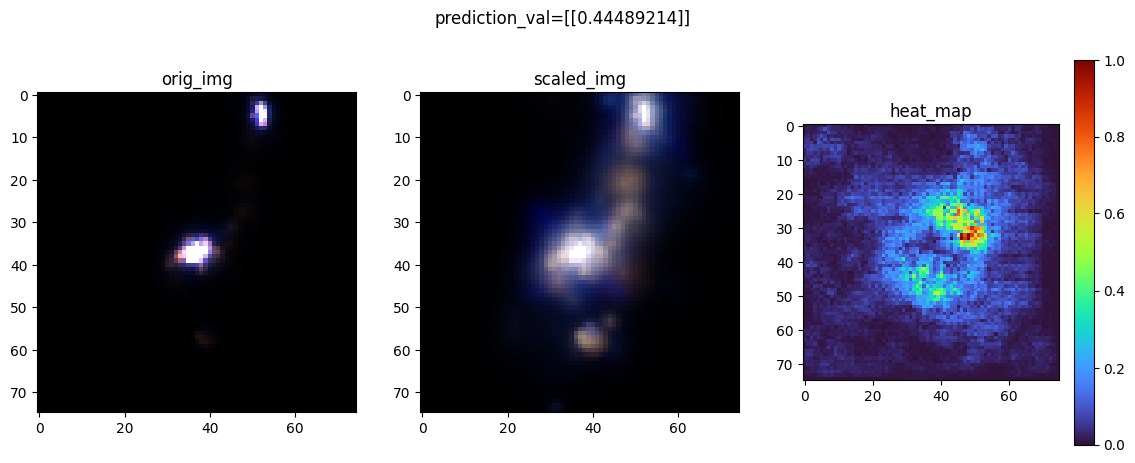

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

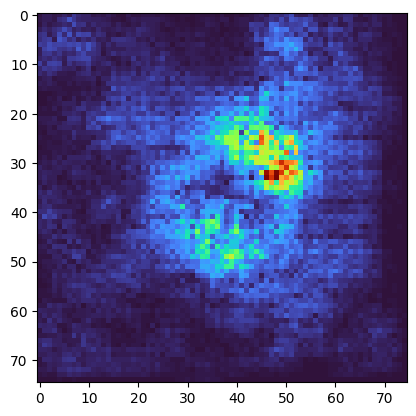

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-07-31 19:34:51.433745: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-31 19:34:52.270617: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-31 19:34:52.342941: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-31 19:34:52.383343: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-31 19:34:53.874679: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

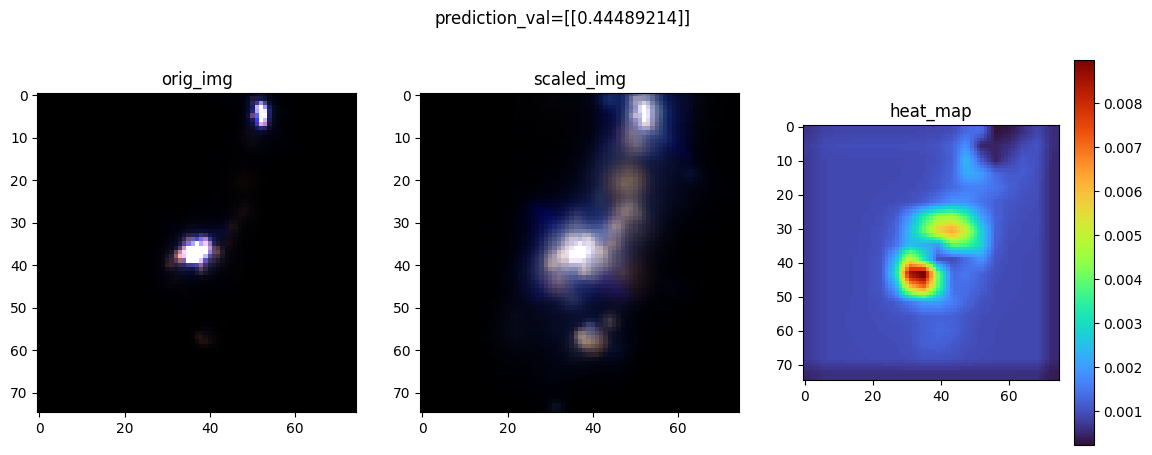

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 4/32 [==>...........................] - ETA: 0s

 7/32 [=====>........................] - ETA: 0s

10/32 [========>.....................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 1s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

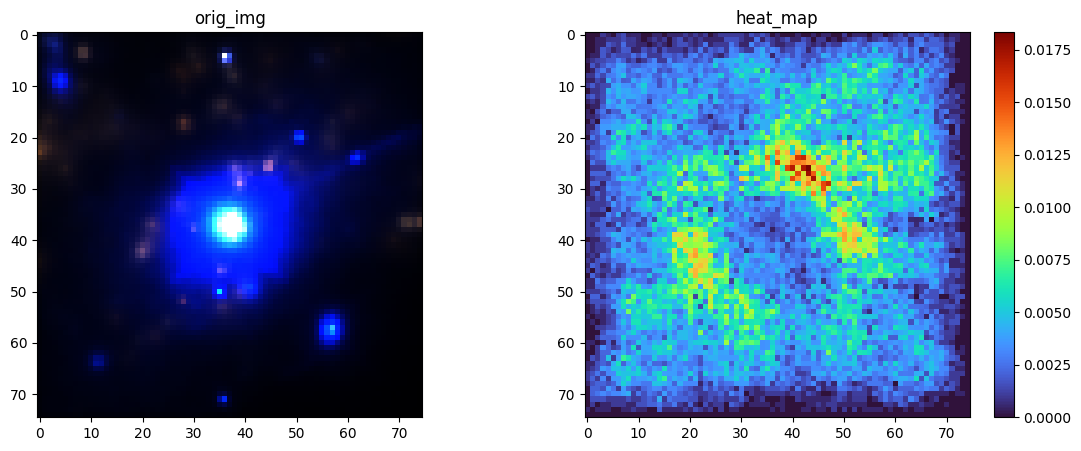

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:18 - loss: 0.7103 - accuracy: 0.5000

  2/338 [..............................] - ETA: 19s - loss: 0.7097 - accuracy: 0.5156 

  3/338 [..............................] - ETA: 18s - loss: 0.7093 - accuracy: 0.5521

  4/338 [..............................] - ETA: 19s - loss: 0.7088 - accuracy: 0.5781

  5/338 [..............................] - ETA: 18s - loss: 0.7087 - accuracy: 0.5562

  6/338 [..............................] - ETA: 18s - loss: 0.7085 - accuracy: 0.5417

  7/338 [..............................] - ETA: 18s - loss: 0.7082 - accuracy: 0.5446

  8/338 [..............................] - ETA: 18s - loss: 0.7079 - accuracy: 0.5391

  9/338 [..............................] - ETA: 18s - loss: 0.7078 - accuracy: 0.5208

 10/338 [..............................] - ETA: 18s - loss: 0.7075 - accuracy: 0.5281

 11/338 [..............................] - ETA: 18s - loss: 0.7070 - accuracy: 0.5455

 12/338 [>.............................] - ETA: 18s - loss: 0.7069 - accuracy: 0.5365

 13/338 [>.............................] - ETA: 18s - loss: 0.7065 - accuracy: 0.5409

 14/338 [>.............................] - ETA: 18s - loss: 0.7063 - accuracy: 0.5357

 15/338 [>.............................] - ETA: 18s - loss: 0.7061 - accuracy: 0.5354

 16/338 [>.............................] - ETA: 18s - loss: 0.7058 - accuracy: 0.5391

 17/338 [>.............................] - ETA: 17s - loss: 0.7056 - accuracy: 0.5349

 18/338 [>.............................] - ETA: 17s - loss: 0.7053 - accuracy: 0.5365

 19/338 [>.............................] - ETA: 17s - loss: 0.7051 - accuracy: 0.5345

 20/338 [>.............................] - ETA: 17s - loss: 0.7050 - accuracy: 0.5297

 21/338 [>.............................] - ETA: 17s - loss: 0.7048 - accuracy: 0.5283

 22/338 [>.............................] - ETA: 17s - loss: 0.7046 - accuracy: 0.5284

 23/338 [=>............................] - ETA: 17s - loss: 0.7043 - accuracy: 0.5340

 24/338 [=>............................] - ETA: 17s - loss: 0.7041 - accuracy: 0.5326

 25/338 [=>............................] - ETA: 17s - loss: 0.7040 - accuracy: 0.5325

 26/338 [=>............................] - ETA: 17s - loss: 0.7038 - accuracy: 0.5325

 27/338 [=>............................] - ETA: 17s - loss: 0.7035 - accuracy: 0.5336

 28/338 [=>............................] - ETA: 17s - loss: 0.7033 - accuracy: 0.5368

 29/338 [=>............................] - ETA: 17s - loss: 0.7031 - accuracy: 0.5356

 30/338 [=>............................] - ETA: 17s - loss: 0.7029 - accuracy: 0.5354

 31/338 [=>............................] - ETA: 17s - loss: 0.7028 - accuracy: 0.5343

 32/338 [=>............................] - ETA: 17s - loss: 0.7026 - accuracy: 0.5352

 33/338 [=>............................] - ETA: 16s - loss: 0.7025 - accuracy: 0.5322

 34/338 [==>...........................] - ETA: 16s - loss: 0.7023 - accuracy: 0.5358

 35/338 [==>...........................] - ETA: 16s - loss: 0.7020 - accuracy: 0.5384

 36/338 [==>...........................] - ETA: 16s - loss: 0.7018 - accuracy: 0.5408

 37/338 [==>...........................] - ETA: 16s - loss: 0.7017 - accuracy: 0.5397

 38/338 [==>...........................] - ETA: 16s - loss: 0.7016 - accuracy: 0.5387

 39/338 [==>...........................] - ETA: 16s - loss: 0.7016 - accuracy: 0.5345

 40/338 [==>...........................] - ETA: 16s - loss: 0.7013 - accuracy: 0.5391

 41/338 [==>...........................] - ETA: 16s - loss: 0.7011 - accuracy: 0.5404

 42/338 [==>...........................] - ETA: 16s - loss: 0.7010 - accuracy: 0.5387

 43/338 [==>...........................] - ETA: 16s - loss: 0.7008 - accuracy: 0.5407

 44/338 [==>...........................] - ETA: 16s - loss: 0.7007 - accuracy: 0.5398

 45/338 [==>...........................] - ETA: 16s - loss: 0.7006 - accuracy: 0.5403

 46/338 [===>..........................] - ETA: 16s - loss: 0.7004 - accuracy: 0.5414

 47/338 [===>..........................] - ETA: 16s - loss: 0.7002 - accuracy: 0.5426

 48/338 [===>..........................] - ETA: 16s - loss: 0.7003 - accuracy: 0.5391

 49/338 [===>..........................] - ETA: 16s - loss: 0.7000 - accuracy: 0.5415

 50/338 [===>..........................] - ETA: 15s - loss: 0.6998 - accuracy: 0.5431

 51/338 [===>..........................] - ETA: 15s - loss: 0.6997 - accuracy: 0.5441

 52/338 [===>..........................] - ETA: 15s - loss: 0.6997 - accuracy: 0.5433

 53/338 [===>..........................] - ETA: 15s - loss: 0.6998 - accuracy: 0.5389

 54/338 [===>..........................] - ETA: 15s - loss: 0.6997 - accuracy: 0.5394

 55/338 [===>..........................] - ETA: 15s - loss: 0.6995 - accuracy: 0.5403

 56/338 [===>..........................] - ETA: 15s - loss: 0.6994 - accuracy: 0.5419

 57/338 [====>.........................] - ETA: 15s - loss: 0.6994 - accuracy: 0.5400

 58/338 [====>.........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5404

 59/338 [====>.........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5403

 60/338 [====>.........................] - ETA: 15s - loss: 0.6989 - accuracy: 0.5427

 61/338 [====>.........................] - ETA: 15s - loss: 0.6987 - accuracy: 0.5446

 62/338 [====>.........................] - ETA: 15s - loss: 0.6987 - accuracy: 0.5439

 63/338 [====>.........................] - ETA: 15s - loss: 0.6986 - accuracy: 0.5432

 64/338 [====>.........................] - ETA: 15s - loss: 0.6985 - accuracy: 0.5435

 65/338 [====>.........................] - ETA: 15s - loss: 0.6985 - accuracy: 0.5428

 66/338 [====>.........................] - ETA: 15s - loss: 0.6984 - accuracy: 0.5436

 67/338 [====>.........................] - ETA: 14s - loss: 0.6981 - accuracy: 0.5466

 68/338 [=====>........................] - ETA: 14s - loss: 0.6980 - accuracy: 0.5469

 69/338 [=====>........................] - ETA: 14s - loss: 0.6979 - accuracy: 0.5466

 70/338 [=====>........................] - ETA: 14s - loss: 0.6979 - accuracy: 0.5464

 71/338 [=====>........................] - ETA: 14s - loss: 0.6977 - accuracy: 0.5480

 72/338 [=====>........................] - ETA: 14s - loss: 0.6976 - accuracy: 0.5486

 73/338 [=====>........................] - ETA: 14s - loss: 0.6976 - accuracy: 0.5475

 74/338 [=====>........................] - ETA: 14s - loss: 0.6976 - accuracy: 0.5465

 75/338 [=====>........................] - ETA: 14s - loss: 0.6977 - accuracy: 0.5446

 76/338 [=====>........................] - ETA: 14s - loss: 0.6978 - accuracy: 0.5428

 77/338 [=====>........................] - ETA: 14s - loss: 0.6977 - accuracy: 0.5426

 78/338 [=====>........................] - ETA: 14s - loss: 0.6977 - accuracy: 0.5421

 79/338 [======>.......................] - ETA: 14s - loss: 0.6975 - accuracy: 0.5427

 80/338 [======>.......................] - ETA: 14s - loss: 0.6975 - accuracy: 0.5422

 81/338 [======>.......................] - ETA: 14s - loss: 0.6974 - accuracy: 0.5428

 82/338 [======>.......................] - ETA: 14s - loss: 0.6973 - accuracy: 0.5431

 83/338 [======>.......................] - ETA: 14s - loss: 0.6972 - accuracy: 0.5437

 84/338 [======>.......................] - ETA: 14s - loss: 0.6972 - accuracy: 0.5435

 85/338 [======>.......................] - ETA: 14s - loss: 0.6971 - accuracy: 0.5434

 86/338 [======>.......................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5436

 87/338 [======>.......................] - ETA: 13s - loss: 0.6969 - accuracy: 0.5442

 88/338 [======>.......................] - ETA: 13s - loss: 0.6971 - accuracy: 0.5419

 89/338 [======>.......................] - ETA: 13s - loss: 0.6969 - accuracy: 0.5435

 90/338 [======>.......................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5413

 91/338 [=======>......................] - ETA: 13s - loss: 0.6971 - accuracy: 0.5398

 92/338 [=======>......................] - ETA: 13s - loss: 0.6971 - accuracy: 0.5391

 93/338 [=======>......................] - ETA: 13s - loss: 0.6971 - accuracy: 0.5383

 94/338 [=======>......................] - ETA: 13s - loss: 0.6971 - accuracy: 0.5372

 95/338 [=======>......................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5388

 96/338 [=======>......................] - ETA: 13s - loss: 0.6969 - accuracy: 0.5394

 97/338 [=======>......................] - ETA: 13s - loss: 0.6969 - accuracy: 0.5387

 98/338 [=======>......................] - ETA: 13s - loss: 0.6967 - accuracy: 0.5399

 99/338 [=======>......................] - ETA: 13s - loss: 0.6968 - accuracy: 0.5388

100/338 [=======>......................] - ETA: 13s - loss: 0.6969 - accuracy: 0.5372

101/338 [=======>......................] - ETA: 13s - loss: 0.6969 - accuracy: 0.5368

102/338 [========>.....................] - ETA: 13s - loss: 0.6968 - accuracy: 0.5368

103/338 [========>.....................] - ETA: 13s - loss: 0.6967 - accuracy: 0.5373

104/338 [========>.....................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5367

105/338 [========>.....................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5387

106/338 [========>.....................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5380

107/338 [========>.....................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5380

108/338 [========>.....................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5373

109/338 [========>.....................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5370

110/338 [========>.....................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5369

111/338 [========>.....................] - ETA: 12s - loss: 0.6964 - accuracy: 0.5374

112/338 [========>.....................] - ETA: 12s - loss: 0.6963 - accuracy: 0.5379

113/338 [=========>....................] - ETA: 12s - loss: 0.6963 - accuracy: 0.5376

114/338 [=========>....................] - ETA: 12s - loss: 0.6962 - accuracy: 0.5381

115/338 [=========>....................] - ETA: 12s - loss: 0.6961 - accuracy: 0.5389

116/338 [=========>....................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5407

117/338 [=========>....................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5403

118/338 [=========>....................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5392

119/338 [=========>....................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5383

120/338 [=========>....................] - ETA: 12s - loss: 0.6961 - accuracy: 0.5375

121/338 [=========>....................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5374

122/338 [=========>....................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5371

123/338 [=========>....................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5361

124/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5363

125/338 [==========>...................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5372

126/338 [==========>...................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5370

127/338 [==========>...................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5372

128/338 [==========>...................] - ETA: 11s - loss: 0.6958 - accuracy: 0.5371

129/338 [==========>...................] - ETA: 11s - loss: 0.6958 - accuracy: 0.5363

130/338 [==========>...................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5356

131/338 [==========>...................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5351

132/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5334

133/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5327

134/338 [==========>...................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5333

135/338 [==========>...................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5331

136/338 [===========>..................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5324

137/338 [===========>..................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5328

138/338 [===========>..................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5326

139/338 [===========>..................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5328

140/338 [===========>..................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5330

141/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5315

142/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5317

143/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5312

144/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5302

145/338 [===========>..................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5293

146/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5302

147/338 [============>.................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5302

148/338 [============>.................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5296

149/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5300

150/338 [============>.................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5294

151/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5296

152/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5296

153/338 [============>.................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5304

154/338 [============>.................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5306

155/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5308

156/338 [============>.................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5315

157/338 [============>.................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5297

158/338 [=============>................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5307

159/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5305 

160/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5295

161/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5285

162/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5287

163/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5282

164/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5286

165/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5278

166/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5279

167/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5277

168/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5272

169/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5276

170/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5283

171/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5281

172/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5280

173/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5280

174/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5278

175/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5275

176/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5277

177/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5286

178/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5284

179/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5272

180/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5274

181/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5271

182/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5280

183/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5290

184/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5287

185/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5284

186/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5284

187/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5274

188/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5276

189/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5273

190/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5276

191/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5273

192/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5272

193/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5269

194/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5271

195/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5268

196/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5265

197/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5265

198/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5264

199/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5264

200/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5269

201/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5266

202/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5268

203/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5266

204/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5268

205/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5276

206/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5278

207/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5281

208/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5284

209/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5286

210/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5277

211/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5278

212/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5284

213/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5282

214/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5286

215/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5286

216/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5288

217/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5285

218/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5280

219/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5278

220/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5273

221/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5271

222/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5266

223/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5263

224/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5266

225/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5264

226/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5271

227/338 [===================>..........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5273

228/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5263

229/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5259

230/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5265

231/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5269

232/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5269

233/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5270

234/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5271

235/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5273

236/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5278

237/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5282

238/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5281

239/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5288

240/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5283

241/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5281

242/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5279

243/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5278

244/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5272

245/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5265

246/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5269

247/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5276

248/338 [=====================>........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5280

249/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5277

250/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5275

251/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5275

252/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5273

253/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5269

254/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5269

255/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5279

256/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5277

257/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5275

258/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5281

259/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5281

260/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5276

261/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5281

262/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5280

263/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5279

264/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5284

265/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5282

266/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5281

267/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5279

268/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5276

269/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5280

270/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5287

271/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5284

272/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5285

273/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5283

274/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5283

275/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5278

276/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5277

277/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5282

278/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5286

279/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5287

280/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5289

281/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5282

282/338 [========================>.....] - ETA: 3s - loss: 0.6937 - accuracy: 0.5286

283/338 [========================>.....] - ETA: 3s - loss: 0.6937 - accuracy: 0.5285

284/338 [========================>.....] - ETA: 3s - loss: 0.6937 - accuracy: 0.5287

285/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5285

286/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5283

287/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5282

288/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5275

289/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5271

290/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5276

291/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5279

292/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5281

293/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5279

294/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5277

295/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5281

296/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5282

297/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5283

298/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5283

299/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5284

300/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5285

301/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5281

302/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5282

303/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5282

304/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5279

305/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5276

306/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5277

307/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5272

308/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5273

309/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5267

310/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5263

311/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5265

312/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5265

313/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5262

314/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5260

315/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5266

316/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5265

317/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5268

318/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5269

319/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5270

320/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5270

321/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5269

322/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5269

323/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5268

324/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5267

325/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5267

326/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5266

327/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5267

328/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5267

329/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5268

330/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5267

331/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5268

332/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5267

333/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5272

334/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5274

335/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5274

336/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5272

337/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5268

338/338 [==============================] - 22s 61ms/step - loss: 0.6933 - accuracy: 0.5271 - val_loss: 0.6916 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 19s - loss: 0.6908 - accuracy: 0.4688

  2/338 [..............................] - ETA: 19s - loss: 0.6896 - accuracy: 0.5000

  3/338 [..............................] - ETA: 19s - loss: 0.6900 - accuracy: 0.4896

  4/338 [..............................] - ETA: 18s - loss: 0.6899 - accuracy: 0.4922

  5/338 [..............................] - ETA: 18s - loss: 0.6885 - accuracy: 0.5188

  6/338 [..............................] - ETA: 18s - loss: 0.6891 - accuracy: 0.5156

  7/338 [..............................] - ETA: 18s - loss: 0.6896 - accuracy: 0.5089

  8/338 [..............................] - ETA: 18s - loss: 0.6891 - accuracy: 0.5156

  9/338 [..............................] - ETA: 18s - loss: 0.6903 - accuracy: 0.5035

 10/338 [..............................] - ETA: 18s - loss: 0.6884 - accuracy: 0.5312

 11/338 [..............................] - ETA: 18s - loss: 0.6883 - accuracy: 0.5341

 12/338 [>.............................] - ETA: 18s - loss: 0.6890 - accuracy: 0.5260

 13/338 [>.............................] - ETA: 18s - loss: 0.6890 - accuracy: 0.5288

 14/338 [>.............................] - ETA: 18s - loss: 0.6881 - accuracy: 0.5402

 15/338 [>.............................] - ETA: 18s - loss: 0.6888 - accuracy: 0.5312

 16/338 [>.............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5391

 17/338 [>.............................] - ETA: 17s - loss: 0.6881 - accuracy: 0.5423

 18/338 [>.............................] - ETA: 17s - loss: 0.6881 - accuracy: 0.5382

 19/338 [>.............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5428

 20/338 [>.............................] - ETA: 17s - loss: 0.6873 - accuracy: 0.5437

 21/338 [>.............................] - ETA: 17s - loss: 0.6877 - accuracy: 0.5402

 22/338 [>.............................] - ETA: 17s - loss: 0.6877 - accuracy: 0.5412

 23/338 [=>............................] - ETA: 17s - loss: 0.6877 - accuracy: 0.5408

 24/338 [=>............................] - ETA: 17s - loss: 0.6879 - accuracy: 0.5391

 25/338 [=>............................] - ETA: 17s - loss: 0.6875 - accuracy: 0.5425

 26/338 [=>............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5421

 27/338 [=>............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5417

 28/338 [=>............................] - ETA: 17s - loss: 0.6870 - accuracy: 0.5446

 29/338 [=>............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5442

 30/338 [=>............................] - ETA: 17s - loss: 0.6870 - accuracy: 0.5458

 31/338 [=>............................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5484

 32/338 [=>............................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5498

 33/338 [=>............................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5445

 34/338 [==>...........................] - ETA: 16s - loss: 0.6876 - accuracy: 0.5432

 35/338 [==>...........................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5437

 36/338 [==>...........................] - ETA: 16s - loss: 0.6878 - accuracy: 0.5417

 37/338 [==>...........................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5397

 38/338 [==>...........................] - ETA: 16s - loss: 0.6877 - accuracy: 0.5436

 39/338 [==>...........................] - ETA: 16s - loss: 0.6876 - accuracy: 0.5441

 40/338 [==>...........................] - ETA: 16s - loss: 0.6877 - accuracy: 0.5430

 41/338 [==>...........................] - ETA: 16s - loss: 0.6878 - accuracy: 0.5427

 42/338 [==>...........................] - ETA: 16s - loss: 0.6871 - accuracy: 0.5484

 43/338 [==>...........................] - ETA: 16s - loss: 0.6870 - accuracy: 0.5501

 44/338 [==>...........................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5490

 45/338 [==>...........................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5479

 46/338 [===>..........................] - ETA: 16s - loss: 0.6878 - accuracy: 0.5462

 47/338 [===>..........................] - ETA: 16s - loss: 0.6876 - accuracy: 0.5465

 48/338 [===>..........................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5482

 49/338 [===>..........................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5478

 50/338 [===>..........................] - ETA: 16s - loss: 0.6871 - accuracy: 0.5494

 51/338 [===>..........................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5515

 52/338 [===>..........................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5475

 53/338 [===>..........................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5472

 54/338 [===>..........................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5469

 55/338 [===>..........................] - ETA: 15s - loss: 0.6872 - accuracy: 0.5483

 56/338 [===>..........................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5485

 57/338 [====>.........................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5461

 58/338 [====>.........................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5442

 59/338 [====>.........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5413

 60/338 [====>.........................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5401

 61/338 [====>.........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5410

 62/338 [====>.........................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5398

 63/338 [====>.........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5407

 64/338 [====>.........................] - ETA: 15s - loss: 0.6882 - accuracy: 0.5391

 65/338 [====>.........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5375

 66/338 [====>.........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5360

 67/338 [====>.........................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5345

 68/338 [=====>........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5345

 69/338 [=====>........................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5344

 70/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5348

 71/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5361

 72/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5356

 73/338 [=====>........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5355

 74/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5346

 75/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5350

 76/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5354

 77/338 [=====>........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5325

 78/338 [=====>........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5329

 79/338 [======>.......................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5332

 80/338 [======>.......................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5332

 81/338 [======>.......................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5343

 82/338 [======>.......................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5332

 83/338 [======>.......................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5339

 84/338 [======>.......................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5324

 85/338 [======>.......................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5324

 86/338 [======>.......................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5342

 87/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5330

 88/338 [======>.......................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5298

 89/338 [======>.......................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5305

 90/338 [======>.......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5319

 91/338 [=======>......................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5302

 92/338 [=======>......................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5289

 93/338 [=======>......................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5296

 94/338 [=======>......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5322

 95/338 [=======>......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5316

 96/338 [=======>......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5335

 97/338 [=======>......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5345

 98/338 [=======>......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5344

 99/338 [=======>......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5347

100/338 [=======>......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5337

101/338 [=======>......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5340

102/338 [========>.....................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5340

103/338 [========>.....................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5343

104/338 [========>.....................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5343

105/338 [========>.....................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5354

106/338 [========>.....................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5354

107/338 [========>.....................] - ETA: 12s - loss: 0.6878 - accuracy: 0.5356

108/338 [========>.....................] - ETA: 12s - loss: 0.6877 - accuracy: 0.5362

109/338 [========>.....................] - ETA: 12s - loss: 0.6877 - accuracy: 0.5361

110/338 [========>.....................] - ETA: 12s - loss: 0.6876 - accuracy: 0.5364

111/338 [========>.....................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5369

112/338 [========>.....................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5371

113/338 [=========>....................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5371

114/338 [=========>....................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5373

115/338 [=========>....................] - ETA: 12s - loss: 0.6872 - accuracy: 0.5389

116/338 [=========>....................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5369

117/338 [=========>....................] - ETA: 12s - loss: 0.6872 - accuracy: 0.5382

118/338 [=========>....................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5371

119/338 [=========>....................] - ETA: 12s - loss: 0.6872 - accuracy: 0.5373

120/338 [=========>....................] - ETA: 12s - loss: 0.6872 - accuracy: 0.5375

121/338 [=========>....................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5364

122/338 [=========>....................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5359

123/338 [=========>....................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5376

124/338 [==========>...................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5381

125/338 [==========>...................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5380

126/338 [==========>...................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5379

127/338 [==========>...................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5374

128/338 [==========>...................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5366

129/338 [==========>...................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5359

130/338 [==========>...................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5368

131/338 [==========>...................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5365

132/338 [==========>...................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5362

133/338 [==========>...................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5362

134/338 [==========>...................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5361

135/338 [==========>...................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5361

136/338 [===========>..................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5358

137/338 [===========>..................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5358

138/338 [===========>..................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5362

139/338 [===========>..................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5364

140/338 [===========>..................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5359

141/338 [===========>..................] - ETA: 10s - loss: 0.6869 - accuracy: 0.5363

142/338 [===========>..................] - ETA: 10s - loss: 0.6868 - accuracy: 0.5365

143/338 [===========>..................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5367

144/338 [===========>..................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5371

145/338 [===========>..................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5371

146/338 [===========>..................] - ETA: 10s - loss: 0.6866 - accuracy: 0.5379

147/338 [============>.................] - ETA: 10s - loss: 0.6865 - accuracy: 0.5383

148/338 [============>.................] - ETA: 10s - loss: 0.6865 - accuracy: 0.5382

149/338 [============>.................] - ETA: 10s - loss: 0.6865 - accuracy: 0.5382

150/338 [============>.................] - ETA: 10s - loss: 0.6864 - accuracy: 0.5387

151/338 [============>.................] - ETA: 10s - loss: 0.6864 - accuracy: 0.5383

152/338 [============>.................] - ETA: 10s - loss: 0.6865 - accuracy: 0.5380

153/338 [============>.................] - ETA: 10s - loss: 0.6864 - accuracy: 0.5386

154/338 [============>.................] - ETA: 10s - loss: 0.6863 - accuracy: 0.5392

155/338 [============>.................] - ETA: 10s - loss: 0.6865 - accuracy: 0.5381

156/338 [============>.................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5371

157/338 [============>.................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5368

158/338 [=============>................] - ETA: 10s - loss: 0.6868 - accuracy: 0.5364

159/338 [=============>................] - ETA: 9s - loss: 0.6868 - accuracy: 0.5360 

160/338 [=============>................] - ETA: 9s - loss: 0.6868 - accuracy: 0.5357

161/338 [=============>................] - ETA: 9s - loss: 0.6869 - accuracy: 0.5349

162/338 [=============>................] - ETA: 9s - loss: 0.6870 - accuracy: 0.5340

163/338 [=============>................] - ETA: 9s - loss: 0.6870 - accuracy: 0.5339

164/338 [=============>................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5333

165/338 [=============>................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5330

166/338 [=============>................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5335

167/338 [=============>................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5324

168/338 [=============>................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5318

169/338 [==============>...............] - ETA: 9s - loss: 0.6872 - accuracy: 0.5318

170/338 [==============>...............] - ETA: 9s - loss: 0.6872 - accuracy: 0.5320

171/338 [==============>...............] - ETA: 9s - loss: 0.6871 - accuracy: 0.5331

172/338 [==============>...............] - ETA: 9s - loss: 0.6871 - accuracy: 0.5327

173/338 [==============>...............] - ETA: 9s - loss: 0.6872 - accuracy: 0.5318

174/338 [==============>...............] - ETA: 9s - loss: 0.6872 - accuracy: 0.5314

175/338 [==============>...............] - ETA: 9s - loss: 0.6871 - accuracy: 0.5316

176/338 [==============>...............] - ETA: 9s - loss: 0.6871 - accuracy: 0.5312

177/338 [==============>...............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5314

178/338 [==============>...............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5312

179/338 [==============>...............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5309

180/338 [==============>...............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5318

181/338 [===============>..............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5314

182/338 [===============>..............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5311

183/338 [===============>..............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5311

184/338 [===============>..............] - ETA: 8s - loss: 0.6869 - accuracy: 0.5314

185/338 [===============>..............] - ETA: 8s - loss: 0.6869 - accuracy: 0.5309

186/338 [===============>..............] - ETA: 8s - loss: 0.6869 - accuracy: 0.5307

187/338 [===============>..............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5306

188/338 [===============>..............] - ETA: 8s - loss: 0.6868 - accuracy: 0.5311

189/338 [===============>..............] - ETA: 8s - loss: 0.6869 - accuracy: 0.5308

190/338 [===============>..............] - ETA: 8s - loss: 0.6869 - accuracy: 0.5304

191/338 [===============>..............] - ETA: 8s - loss: 0.6868 - accuracy: 0.5309

192/338 [================>.............] - ETA: 8s - loss: 0.6867 - accuracy: 0.5311

193/338 [================>.............] - ETA: 8s - loss: 0.6867 - accuracy: 0.5316

194/338 [================>.............] - ETA: 8s - loss: 0.6865 - accuracy: 0.5325

195/338 [================>.............] - ETA: 7s - loss: 0.6866 - accuracy: 0.5322

196/338 [================>.............] - ETA: 7s - loss: 0.6865 - accuracy: 0.5324

197/338 [================>.............] - ETA: 7s - loss: 0.6866 - accuracy: 0.5322

198/338 [================>.............] - ETA: 7s - loss: 0.6866 - accuracy: 0.5320

199/338 [================>.............] - ETA: 7s - loss: 0.6865 - accuracy: 0.5323

200/338 [================>.............] - ETA: 7s - loss: 0.6866 - accuracy: 0.5320

201/338 [================>.............] - ETA: 7s - loss: 0.6866 - accuracy: 0.5314

202/338 [================>.............] - ETA: 7s - loss: 0.6866 - accuracy: 0.5311

203/338 [=================>............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5303

204/338 [=================>............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5299

205/338 [=================>............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5294

206/338 [=================>............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5291

207/338 [=================>............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5296

208/338 [=================>............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5302

209/338 [=================>............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5307

210/338 [=================>............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5302

211/338 [=================>............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5305

212/338 [=================>............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5305

213/338 [=================>............] - ETA: 6s - loss: 0.6869 - accuracy: 0.5307

214/338 [=================>............] - ETA: 6s - loss: 0.6869 - accuracy: 0.5314

215/338 [==================>...........] - ETA: 6s - loss: 0.6869 - accuracy: 0.5318

216/338 [==================>...........] - ETA: 6s - loss: 0.6868 - accuracy: 0.5323

217/338 [==================>...........] - ETA: 6s - loss: 0.6867 - accuracy: 0.5334

218/338 [==================>...........] - ETA: 6s - loss: 0.6867 - accuracy: 0.5345

219/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5355

220/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5359

221/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5369

222/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5370

223/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5378

224/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5384

225/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5381

226/338 [===================>..........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5384

227/338 [===================>..........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5388

228/338 [===================>..........] - ETA: 6s - loss: 0.6867 - accuracy: 0.5384

229/338 [===================>..........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5390

230/338 [===================>..........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5393

231/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5394

232/338 [===================>..........] - ETA: 5s - loss: 0.6865 - accuracy: 0.5400

233/338 [===================>..........] - ETA: 5s - loss: 0.6865 - accuracy: 0.5404

234/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5402

235/338 [===================>..........] - ETA: 5s - loss: 0.6867 - accuracy: 0.5400

236/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5404

237/338 [====================>.........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5407

238/338 [====================>.........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5412

239/338 [====================>.........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5416

240/338 [====================>.........] - ETA: 5s - loss: 0.6865 - accuracy: 0.5424

241/338 [====================>.........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5430

242/338 [====================>.........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5433

243/338 [====================>.........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5437

244/338 [====================>.........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5438

245/338 [====================>.........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5444

246/338 [====================>.........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5446

247/338 [====================>.........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5445

248/338 [=====================>........] - ETA: 5s - loss: 0.6861 - accuracy: 0.5459

249/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5458

250/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5466

251/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5469

252/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5469

253/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5474

254/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5482

255/338 [=====================>........] - ETA: 4s - loss: 0.6859 - accuracy: 0.5490

256/338 [=====================>........] - ETA: 4s - loss: 0.6859 - accuracy: 0.5493

257/338 [=====================>........] - ETA: 4s - loss: 0.6859 - accuracy: 0.5495

258/338 [=====================>........] - ETA: 4s - loss: 0.6858 - accuracy: 0.5501

259/338 [=====================>........] - ETA: 4s - loss: 0.6858 - accuracy: 0.5506

260/338 [======================>.......] - ETA: 4s - loss: 0.6858 - accuracy: 0.5511

261/338 [======================>.......] - ETA: 4s - loss: 0.6858 - accuracy: 0.5511

262/338 [======================>.......] - ETA: 4s - loss: 0.6858 - accuracy: 0.5512

263/338 [======================>.......] - ETA: 4s - loss: 0.6858 - accuracy: 0.5505

264/338 [======================>.......] - ETA: 4s - loss: 0.6858 - accuracy: 0.5513

265/338 [======================>.......] - ETA: 4s - loss: 0.6858 - accuracy: 0.5515

266/338 [======================>.......] - ETA: 4s - loss: 0.6858 - accuracy: 0.5517

267/338 [======================>.......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5527

268/338 [======================>.......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5528

269/338 [======================>.......] - ETA: 3s - loss: 0.6858 - accuracy: 0.5524

270/338 [======================>.......] - ETA: 3s - loss: 0.6858 - accuracy: 0.5530

271/338 [=======================>......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5532

272/338 [=======================>......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5535

273/338 [=======================>......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5536

274/338 [=======================>......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5541

275/338 [=======================>......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5544

276/338 [=======================>......] - ETA: 3s - loss: 0.6858 - accuracy: 0.5539

277/338 [=======================>......] - ETA: 3s - loss: 0.6858 - accuracy: 0.5540

278/338 [=======================>......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5542

279/338 [=======================>......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5545

280/338 [=======================>......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5555

281/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5557

282/338 [========================>.....] - ETA: 3s - loss: 0.6856 - accuracy: 0.5562

283/338 [========================>.....] - ETA: 3s - loss: 0.6856 - accuracy: 0.5563

284/338 [========================>.....] - ETA: 3s - loss: 0.6856 - accuracy: 0.5563

285/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5561

286/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5562

287/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5561

288/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5564

289/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5561

290/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5564

291/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5564

292/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5563

293/338 [=========================>....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5565

294/338 [=========================>....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5569

295/338 [=========================>....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5570

296/338 [=========================>....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5573

297/338 [=========================>....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5576

298/338 [=========================>....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5577

299/338 [=========================>....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5580

300/338 [=========================>....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5580

301/338 [=========================>....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5585

302/338 [=========================>....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5587

303/338 [=========================>....] - ETA: 1s - loss: 0.6854 - accuracy: 0.5590

304/338 [=========================>....] - ETA: 1s - loss: 0.6853 - accuracy: 0.5592

305/338 [==========================>...] - ETA: 1s - loss: 0.6853 - accuracy: 0.5595

306/338 [==========================>...] - ETA: 1s - loss: 0.6852 - accuracy: 0.5602

307/338 [==========================>...] - ETA: 1s - loss: 0.6852 - accuracy: 0.5604

308/338 [==========================>...] - ETA: 1s - loss: 0.6852 - accuracy: 0.5604

309/338 [==========================>...] - ETA: 1s - loss: 0.6852 - accuracy: 0.5607

310/338 [==========================>...] - ETA: 1s - loss: 0.6851 - accuracy: 0.5613

311/338 [==========================>...] - ETA: 1s - loss: 0.6851 - accuracy: 0.5612

312/338 [==========================>...] - ETA: 1s - loss: 0.6851 - accuracy: 0.5616

313/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5618

314/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5621

315/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5623

316/338 [===========================>..] - ETA: 1s - loss: 0.6850 - accuracy: 0.5623

317/338 [===========================>..] - ETA: 1s - loss: 0.6850 - accuracy: 0.5624

318/338 [===========================>..] - ETA: 1s - loss: 0.6850 - accuracy: 0.5626

319/338 [===========================>..] - ETA: 1s - loss: 0.6850 - accuracy: 0.5627

320/338 [===========================>..] - ETA: 1s - loss: 0.6850 - accuracy: 0.5629

321/338 [===========================>..] - ETA: 0s - loss: 0.6850 - accuracy: 0.5631

322/338 [===========================>..] - ETA: 0s - loss: 0.6849 - accuracy: 0.5634

323/338 [===========================>..] - ETA: 0s - loss: 0.6849 - accuracy: 0.5635

324/338 [===========================>..] - ETA: 0s - loss: 0.6849 - accuracy: 0.5636

325/338 [===========================>..] - ETA: 0s - loss: 0.6849 - accuracy: 0.5639

326/338 [===========================>..] - ETA: 0s - loss: 0.6848 - accuracy: 0.5646

327/338 [============================>.] - ETA: 0s - loss: 0.6848 - accuracy: 0.5651

328/338 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5655

329/338 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5655

330/338 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5658

331/338 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5658

332/338 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5657

333/338 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5659

334/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5662

335/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5664

336/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5663

337/338 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5663

338/338 [==============================] - 20s 60ms/step - loss: 0.6846 - accuracy: 0.5666 - val_loss: 0.6940 - val_accuracy: 0.5028


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6615 - accuracy: 0.7500

  2/338 [..............................] - ETA: 18s - loss: 0.6680 - accuracy: 0.6719

  3/338 [..............................] - ETA: 18s - loss: 0.6697 - accuracy: 0.6458

  4/338 [..............................] - ETA: 18s - loss: 0.6762 - accuracy: 0.6328

  5/338 [..............................] - ETA: 18s - loss: 0.6747 - accuracy: 0.6438

  6/338 [..............................] - ETA: 18s - loss: 0.6715 - accuracy: 0.6510

  7/338 [..............................] - ETA: 18s - loss: 0.6775 - accuracy: 0.6205

  8/338 [..............................] - ETA: 18s - loss: 0.6811 - accuracy: 0.5977

  9/338 [..............................] - ETA: 18s - loss: 0.6799 - accuracy: 0.6042

 10/338 [..............................] - ETA: 18s - loss: 0.6810 - accuracy: 0.6000

 11/338 [..............................] - ETA: 18s - loss: 0.6790 - accuracy: 0.6051

 12/338 [>.............................] - ETA: 18s - loss: 0.6778 - accuracy: 0.6146

 13/338 [>.............................] - ETA: 18s - loss: 0.6752 - accuracy: 0.6298

 14/338 [>.............................] - ETA: 17s - loss: 0.6727 - accuracy: 0.6429

 15/338 [>.............................] - ETA: 17s - loss: 0.6705 - accuracy: 0.6542

 16/338 [>.............................] - ETA: 17s - loss: 0.6720 - accuracy: 0.6504

 17/338 [>.............................] - ETA: 17s - loss: 0.6722 - accuracy: 0.6507

 18/338 [>.............................] - ETA: 17s - loss: 0.6725 - accuracy: 0.6476

 19/338 [>.............................] - ETA: 17s - loss: 0.6734 - accuracy: 0.6431

 20/338 [>.............................] - ETA: 17s - loss: 0.6732 - accuracy: 0.6500

 21/338 [>.............................] - ETA: 17s - loss: 0.6733 - accuracy: 0.6503

 22/338 [>.............................] - ETA: 17s - loss: 0.6750 - accuracy: 0.6435

 23/338 [=>............................] - ETA: 17s - loss: 0.6738 - accuracy: 0.6495

 24/338 [=>............................] - ETA: 17s - loss: 0.6746 - accuracy: 0.6445

 25/338 [=>............................] - ETA: 17s - loss: 0.6740 - accuracy: 0.6488

 26/338 [=>............................] - ETA: 17s - loss: 0.6733 - accuracy: 0.6526

 27/338 [=>............................] - ETA: 17s - loss: 0.6731 - accuracy: 0.6528

 28/338 [=>............................] - ETA: 17s - loss: 0.6741 - accuracy: 0.6507

 29/338 [=>............................] - ETA: 17s - loss: 0.6748 - accuracy: 0.6455

 30/338 [=>............................] - ETA: 17s - loss: 0.6749 - accuracy: 0.6469

 31/338 [=>............................] - ETA: 17s - loss: 0.6749 - accuracy: 0.6462

 32/338 [=>............................] - ETA: 17s - loss: 0.6743 - accuracy: 0.6475

 33/338 [=>............................] - ETA: 16s - loss: 0.6751 - accuracy: 0.6439

 34/338 [==>...........................] - ETA: 16s - loss: 0.6744 - accuracy: 0.6461

 35/338 [==>...........................] - ETA: 16s - loss: 0.6749 - accuracy: 0.6438

 36/338 [==>...........................] - ETA: 16s - loss: 0.6751 - accuracy: 0.6424

 37/338 [==>...........................] - ETA: 16s - loss: 0.6748 - accuracy: 0.6419

 38/338 [==>...........................] - ETA: 16s - loss: 0.6748 - accuracy: 0.6406

 39/338 [==>...........................] - ETA: 16s - loss: 0.6744 - accuracy: 0.6426

 40/338 [==>...........................] - ETA: 16s - loss: 0.6742 - accuracy: 0.6445

 41/338 [==>...........................] - ETA: 16s - loss: 0.6744 - accuracy: 0.6433

 42/338 [==>...........................] - ETA: 16s - loss: 0.6739 - accuracy: 0.6451

 43/338 [==>...........................] - ETA: 16s - loss: 0.6741 - accuracy: 0.6446

 44/338 [==>...........................] - ETA: 16s - loss: 0.6740 - accuracy: 0.6442

 45/338 [==>...........................] - ETA: 16s - loss: 0.6739 - accuracy: 0.6451

 46/338 [===>..........................] - ETA: 16s - loss: 0.6737 - accuracy: 0.6467

 47/338 [===>..........................] - ETA: 16s - loss: 0.6739 - accuracy: 0.6456

 48/338 [===>..........................] - ETA: 16s - loss: 0.6740 - accuracy: 0.6458

 49/338 [===>..........................] - ETA: 16s - loss: 0.6739 - accuracy: 0.6473

 50/338 [===>..........................] - ETA: 16s - loss: 0.6737 - accuracy: 0.6481

 51/338 [===>..........................] - ETA: 15s - loss: 0.6729 - accuracy: 0.6520

 52/338 [===>..........................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6502

 53/338 [===>..........................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6474

 54/338 [===>..........................] - ETA: 15s - loss: 0.6744 - accuracy: 0.6453

 55/338 [===>..........................] - ETA: 15s - loss: 0.6743 - accuracy: 0.6455

 56/338 [===>..........................] - ETA: 15s - loss: 0.6741 - accuracy: 0.6456

 57/338 [====>.........................] - ETA: 15s - loss: 0.6746 - accuracy: 0.6447

 58/338 [====>.........................] - ETA: 15s - loss: 0.6748 - accuracy: 0.6444

 59/338 [====>.........................] - ETA: 15s - loss: 0.6749 - accuracy: 0.6441

 60/338 [====>.........................] - ETA: 15s - loss: 0.6746 - accuracy: 0.6453

 61/338 [====>.........................] - ETA: 15s - loss: 0.6746 - accuracy: 0.6440

 62/338 [====>.........................] - ETA: 15s - loss: 0.6751 - accuracy: 0.6421

 63/338 [====>.........................] - ETA: 15s - loss: 0.6749 - accuracy: 0.6434

 64/338 [====>.........................] - ETA: 15s - loss: 0.6749 - accuracy: 0.6426

 65/338 [====>.........................] - ETA: 15s - loss: 0.6750 - accuracy: 0.6418

 66/338 [====>.........................] - ETA: 15s - loss: 0.6751 - accuracy: 0.6406

 67/338 [====>.........................] - ETA: 15s - loss: 0.6755 - accuracy: 0.6385

 68/338 [=====>........................] - ETA: 15s - loss: 0.6757 - accuracy: 0.6379

 69/338 [=====>........................] - ETA: 14s - loss: 0.6758 - accuracy: 0.6372

 70/338 [=====>........................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6375

 71/338 [=====>........................] - ETA: 14s - loss: 0.6755 - accuracy: 0.6386

 72/338 [=====>........................] - ETA: 14s - loss: 0.6752 - accuracy: 0.6402

 73/338 [=====>........................] - ETA: 14s - loss: 0.6752 - accuracy: 0.6408

 74/338 [=====>........................] - ETA: 14s - loss: 0.6751 - accuracy: 0.6398

 75/338 [=====>........................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6400

 76/338 [=====>........................] - ETA: 14s - loss: 0.6747 - accuracy: 0.6410

 77/338 [=====>........................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6416

 78/338 [=====>........................] - ETA: 14s - loss: 0.6749 - accuracy: 0.6394

 79/338 [======>.......................] - ETA: 14s - loss: 0.6747 - accuracy: 0.6392

 80/338 [======>.......................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6383

 81/338 [======>.......................] - ETA: 14s - loss: 0.6751 - accuracy: 0.6362

 82/338 [======>.......................] - ETA: 14s - loss: 0.6751 - accuracy: 0.6357

 83/338 [======>.......................] - ETA: 14s - loss: 0.6749 - accuracy: 0.6370

 84/338 [======>.......................] - ETA: 14s - loss: 0.6752 - accuracy: 0.6354

 85/338 [======>.......................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6353

 86/338 [======>.......................] - ETA: 14s - loss: 0.6748 - accuracy: 0.6363

 87/338 [======>.......................] - ETA: 13s - loss: 0.6746 - accuracy: 0.6376

 88/338 [======>.......................] - ETA: 13s - loss: 0.6743 - accuracy: 0.6388

 89/338 [======>.......................] - ETA: 13s - loss: 0.6742 - accuracy: 0.6401

 90/338 [======>.......................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6410

 91/338 [=======>......................] - ETA: 13s - loss: 0.6745 - accuracy: 0.6398

 92/338 [=======>......................] - ETA: 13s - loss: 0.6743 - accuracy: 0.6406

 93/338 [=======>......................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6401

 94/338 [=======>......................] - ETA: 13s - loss: 0.6739 - accuracy: 0.6410

 95/338 [=======>......................] - ETA: 13s - loss: 0.6739 - accuracy: 0.6411

 96/338 [=======>......................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6406

 97/338 [=======>......................] - ETA: 13s - loss: 0.6740 - accuracy: 0.6401

 98/338 [=======>......................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6397

 99/338 [=======>......................] - ETA: 13s - loss: 0.6739 - accuracy: 0.6405

100/338 [=======>......................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6391

101/338 [=======>......................] - ETA: 13s - loss: 0.6739 - accuracy: 0.6399

102/338 [========>.....................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6388

103/338 [========>.....................] - ETA: 13s - loss: 0.6740 - accuracy: 0.6399

104/338 [========>.....................] - ETA: 13s - loss: 0.6740 - accuracy: 0.6400

105/338 [========>.....................] - ETA: 12s - loss: 0.6742 - accuracy: 0.6387

106/338 [========>.....................] - ETA: 12s - loss: 0.6742 - accuracy: 0.6386

107/338 [========>.....................] - ETA: 12s - loss: 0.6742 - accuracy: 0.6384

108/338 [========>.....................] - ETA: 12s - loss: 0.6741 - accuracy: 0.6389

109/338 [========>.....................] - ETA: 12s - loss: 0.6741 - accuracy: 0.6390

110/338 [========>.....................] - ETA: 12s - loss: 0.6739 - accuracy: 0.6401

111/338 [========>.....................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6410

112/338 [========>.....................] - ETA: 12s - loss: 0.6738 - accuracy: 0.6403

113/338 [=========>....................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6408

114/338 [=========>....................] - ETA: 12s - loss: 0.6738 - accuracy: 0.6406

115/338 [=========>....................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6413

116/338 [=========>....................] - ETA: 12s - loss: 0.6738 - accuracy: 0.6412

117/338 [=========>....................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6421

118/338 [=========>....................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6419

119/338 [=========>....................] - ETA: 12s - loss: 0.6738 - accuracy: 0.6408

120/338 [=========>....................] - ETA: 12s - loss: 0.6740 - accuracy: 0.6396

121/338 [=========>....................] - ETA: 12s - loss: 0.6739 - accuracy: 0.6402

122/338 [=========>....................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6411

123/338 [=========>....................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6397

124/338 [==========>...................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6406

125/338 [==========>...................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6400

126/338 [==========>...................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6396

127/338 [==========>...................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6388

128/338 [==========>...................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6404

129/338 [==========>...................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6388

130/338 [==========>...................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6392

131/338 [==========>...................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6391

132/338 [==========>...................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6397

133/338 [==========>...................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6396

134/338 [==========>...................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6404

135/338 [==========>...................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6398

136/338 [===========>..................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6388

137/338 [===========>..................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6391

138/338 [===========>..................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6390

139/338 [===========>..................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6396

140/338 [===========>..................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6397

141/338 [===========>..................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6390

142/338 [===========>..................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6406

143/338 [===========>..................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6405

144/338 [===========>..................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6400

145/338 [===========>..................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6409

146/338 [===========>..................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6411

147/338 [============>.................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6409

148/338 [============>.................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6402

149/338 [============>.................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6395

150/338 [============>.................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6394

151/338 [============>.................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6393

152/338 [============>.................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6390

153/338 [============>.................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6383

154/338 [============>.................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6376

155/338 [============>.................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6369

156/338 [============>.................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6372

157/338 [============>.................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6367

158/338 [=============>................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6365 

159/338 [=============>................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6362

160/338 [=============>................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6359

161/338 [=============>................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6359

162/338 [=============>................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6356

163/338 [=============>................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6365

164/338 [=============>................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6362

165/338 [=============>................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6358

166/338 [=============>................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6361

167/338 [=============>................] - ETA: 9s - loss: 0.6733 - accuracy: 0.6370

168/338 [=============>................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6371

169/338 [==============>...............] - ETA: 9s - loss: 0.6733 - accuracy: 0.6376

170/338 [==============>...............] - ETA: 9s - loss: 0.6733 - accuracy: 0.6373

171/338 [==============>...............] - ETA: 9s - loss: 0.6731 - accuracy: 0.6382

172/338 [==============>...............] - ETA: 9s - loss: 0.6731 - accuracy: 0.6379

173/338 [==============>...............] - ETA: 9s - loss: 0.6731 - accuracy: 0.6382

174/338 [==============>...............] - ETA: 9s - loss: 0.6731 - accuracy: 0.6385

175/338 [==============>...............] - ETA: 9s - loss: 0.6730 - accuracy: 0.6388

176/338 [==============>...............] - ETA: 9s - loss: 0.6731 - accuracy: 0.6381

177/338 [==============>...............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6384

178/338 [==============>...............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6383

179/338 [==============>...............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6384

180/338 [==============>...............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6380

181/338 [===============>..............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6383

182/338 [===============>..............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6380

183/338 [===============>..............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6375

184/338 [===============>..............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6377

185/338 [===============>..............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6382

186/338 [===============>..............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6376

187/338 [===============>..............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6377

188/338 [===============>..............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6375

189/338 [===============>..............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6374

190/338 [===============>..............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6365

191/338 [===============>..............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6358

192/338 [================>.............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6353

193/338 [================>.............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6350

194/338 [================>.............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6353

195/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6356

196/338 [================>.............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6355

197/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6353

198/338 [================>.............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6360

199/338 [================>.............] - ETA: 7s - loss: 0.6731 - accuracy: 0.6366

200/338 [================>.............] - ETA: 7s - loss: 0.6730 - accuracy: 0.6369

201/338 [================>.............] - ETA: 7s - loss: 0.6731 - accuracy: 0.6367

202/338 [================>.............] - ETA: 7s - loss: 0.6730 - accuracy: 0.6374

203/338 [=================>............] - ETA: 7s - loss: 0.6730 - accuracy: 0.6372

204/338 [=================>............] - ETA: 7s - loss: 0.6731 - accuracy: 0.6371

205/338 [=================>............] - ETA: 7s - loss: 0.6730 - accuracy: 0.6372

206/338 [=================>............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6377

207/338 [=================>............] - ETA: 7s - loss: 0.6728 - accuracy: 0.6380

208/338 [=================>............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6379

209/338 [=================>............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6377

210/338 [=================>............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6375

211/338 [=================>............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6373

212/338 [=================>............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6374

213/338 [=================>............] - ETA: 6s - loss: 0.6728 - accuracy: 0.6378

214/338 [=================>............] - ETA: 6s - loss: 0.6728 - accuracy: 0.6377

215/338 [==================>...........] - ETA: 6s - loss: 0.6729 - accuracy: 0.6372

216/338 [==================>...........] - ETA: 6s - loss: 0.6730 - accuracy: 0.6369

217/338 [==================>...........] - ETA: 6s - loss: 0.6729 - accuracy: 0.6370

218/338 [==================>...........] - ETA: 6s - loss: 0.6729 - accuracy: 0.6372

219/338 [==================>...........] - ETA: 6s - loss: 0.6728 - accuracy: 0.6376

220/338 [==================>...........] - ETA: 6s - loss: 0.6728 - accuracy: 0.6374

221/338 [==================>...........] - ETA: 6s - loss: 0.6728 - accuracy: 0.6374

222/338 [==================>...........] - ETA: 6s - loss: 0.6727 - accuracy: 0.6374

223/338 [==================>...........] - ETA: 6s - loss: 0.6728 - accuracy: 0.6373

224/338 [==================>...........] - ETA: 6s - loss: 0.6728 - accuracy: 0.6373

225/338 [==================>...........] - ETA: 6s - loss: 0.6729 - accuracy: 0.6367

226/338 [===================>..........] - ETA: 6s - loss: 0.6728 - accuracy: 0.6372

227/338 [===================>..........] - ETA: 6s - loss: 0.6727 - accuracy: 0.6373

228/338 [===================>..........] - ETA: 6s - loss: 0.6726 - accuracy: 0.6376

229/338 [===================>..........] - ETA: 6s - loss: 0.6725 - accuracy: 0.6376

230/338 [===================>..........] - ETA: 5s - loss: 0.6726 - accuracy: 0.6374

231/338 [===================>..........] - ETA: 5s - loss: 0.6725 - accuracy: 0.6373

232/338 [===================>..........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6378

233/338 [===================>..........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6377

234/338 [===================>..........] - ETA: 5s - loss: 0.6725 - accuracy: 0.6376

235/338 [===================>..........] - ETA: 5s - loss: 0.6725 - accuracy: 0.6375

236/338 [===================>..........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6374

237/338 [====================>.........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6375

238/338 [====================>.........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6376

239/338 [====================>.........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6378

240/338 [====================>.........] - ETA: 5s - loss: 0.6722 - accuracy: 0.6380

241/338 [====================>.........] - ETA: 5s - loss: 0.6723 - accuracy: 0.6378

242/338 [====================>.........] - ETA: 5s - loss: 0.6722 - accuracy: 0.6378

243/338 [====================>.........] - ETA: 5s - loss: 0.6723 - accuracy: 0.6376

244/338 [====================>.........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6372

245/338 [====================>.........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6371

246/338 [====================>.........] - ETA: 5s - loss: 0.6726 - accuracy: 0.6366

247/338 [====================>.........] - ETA: 5s - loss: 0.6726 - accuracy: 0.6363

248/338 [=====================>........] - ETA: 4s - loss: 0.6727 - accuracy: 0.6358

249/338 [=====================>........] - ETA: 4s - loss: 0.6727 - accuracy: 0.6355

250/338 [=====================>........] - ETA: 4s - loss: 0.6727 - accuracy: 0.6355

251/338 [=====================>........] - ETA: 4s - loss: 0.6727 - accuracy: 0.6356

252/338 [=====================>........] - ETA: 4s - loss: 0.6728 - accuracy: 0.6353

253/338 [=====================>........] - ETA: 4s - loss: 0.6726 - accuracy: 0.6359

254/338 [=====================>........] - ETA: 4s - loss: 0.6726 - accuracy: 0.6358

255/338 [=====================>........] - ETA: 4s - loss: 0.6726 - accuracy: 0.6355

256/338 [=====================>........] - ETA: 4s - loss: 0.6726 - accuracy: 0.6353

257/338 [=====================>........] - ETA: 4s - loss: 0.6727 - accuracy: 0.6351

258/338 [=====================>........] - ETA: 4s - loss: 0.6728 - accuracy: 0.6346

259/338 [=====================>........] - ETA: 4s - loss: 0.6728 - accuracy: 0.6344

260/338 [======================>.......] - ETA: 4s - loss: 0.6727 - accuracy: 0.6350

261/338 [======================>.......] - ETA: 4s - loss: 0.6726 - accuracy: 0.6349

262/338 [======================>.......] - ETA: 4s - loss: 0.6726 - accuracy: 0.6350

263/338 [======================>.......] - ETA: 4s - loss: 0.6726 - accuracy: 0.6351

264/338 [======================>.......] - ETA: 4s - loss: 0.6725 - accuracy: 0.6352

265/338 [======================>.......] - ETA: 4s - loss: 0.6725 - accuracy: 0.6349

266/338 [======================>.......] - ETA: 3s - loss: 0.6725 - accuracy: 0.6351

267/338 [======================>.......] - ETA: 3s - loss: 0.6726 - accuracy: 0.6349

268/338 [======================>.......] - ETA: 3s - loss: 0.6725 - accuracy: 0.6354

269/338 [======================>.......] - ETA: 3s - loss: 0.6723 - accuracy: 0.6362

270/338 [======================>.......] - ETA: 3s - loss: 0.6721 - accuracy: 0.6367

271/338 [=======================>......] - ETA: 3s - loss: 0.6720 - accuracy: 0.6368

272/338 [=======================>......] - ETA: 3s - loss: 0.6720 - accuracy: 0.6369

273/338 [=======================>......] - ETA: 3s - loss: 0.6719 - accuracy: 0.6371

274/338 [=======================>......] - ETA: 3s - loss: 0.6720 - accuracy: 0.6367

275/338 [=======================>......] - ETA: 3s - loss: 0.6721 - accuracy: 0.6364

276/338 [=======================>......] - ETA: 3s - loss: 0.6721 - accuracy: 0.6364

277/338 [=======================>......] - ETA: 3s - loss: 0.6720 - accuracy: 0.6365

278/338 [=======================>......] - ETA: 3s - loss: 0.6718 - accuracy: 0.6371

279/338 [=======================>......] - ETA: 3s - loss: 0.6718 - accuracy: 0.6373

280/338 [=======================>......] - ETA: 3s - loss: 0.6718 - accuracy: 0.6374

281/338 [=======================>......] - ETA: 3s - loss: 0.6716 - accuracy: 0.6378

282/338 [========================>.....] - ETA: 3s - loss: 0.6716 - accuracy: 0.6376

283/338 [========================>.....] - ETA: 3s - loss: 0.6717 - accuracy: 0.6374

284/338 [========================>.....] - ETA: 2s - loss: 0.6719 - accuracy: 0.6367

285/338 [========================>.....] - ETA: 2s - loss: 0.6720 - accuracy: 0.6362

286/338 [========================>.....] - ETA: 2s - loss: 0.6719 - accuracy: 0.6366

287/338 [========================>.....] - ETA: 2s - loss: 0.6721 - accuracy: 0.6360

288/338 [========================>.....] - ETA: 2s - loss: 0.6721 - accuracy: 0.6361

289/338 [========================>.....] - ETA: 2s - loss: 0.6723 - accuracy: 0.6353

290/338 [========================>.....] - ETA: 2s - loss: 0.6723 - accuracy: 0.6353

291/338 [========================>.....] - ETA: 2s - loss: 0.6723 - accuracy: 0.6350

292/338 [========================>.....] - ETA: 2s - loss: 0.6723 - accuracy: 0.6350

293/338 [=========================>....] - ETA: 2s - loss: 0.6723 - accuracy: 0.6349

294/338 [=========================>....] - ETA: 2s - loss: 0.6723 - accuracy: 0.6349

295/338 [=========================>....] - ETA: 2s - loss: 0.6723 - accuracy: 0.6349

296/338 [=========================>....] - ETA: 2s - loss: 0.6724 - accuracy: 0.6348

297/338 [=========================>....] - ETA: 2s - loss: 0.6723 - accuracy: 0.6350

298/338 [=========================>....] - ETA: 2s - loss: 0.6723 - accuracy: 0.6349

299/338 [=========================>....] - ETA: 2s - loss: 0.6723 - accuracy: 0.6349

300/338 [=========================>....] - ETA: 2s - loss: 0.6722 - accuracy: 0.6353

301/338 [=========================>....] - ETA: 2s - loss: 0.6721 - accuracy: 0.6352

302/338 [=========================>....] - ETA: 1s - loss: 0.6721 - accuracy: 0.6351

303/338 [=========================>....] - ETA: 1s - loss: 0.6721 - accuracy: 0.6350

304/338 [=========================>....] - ETA: 1s - loss: 0.6721 - accuracy: 0.6350

305/338 [==========================>...] - ETA: 1s - loss: 0.6722 - accuracy: 0.6346

306/338 [==========================>...] - ETA: 1s - loss: 0.6722 - accuracy: 0.6346

307/338 [==========================>...] - ETA: 1s - loss: 0.6721 - accuracy: 0.6348

308/338 [==========================>...] - ETA: 1s - loss: 0.6721 - accuracy: 0.6346

309/338 [==========================>...] - ETA: 1s - loss: 0.6721 - accuracy: 0.6345

310/338 [==========================>...] - ETA: 1s - loss: 0.6721 - accuracy: 0.6346

311/338 [==========================>...] - ETA: 1s - loss: 0.6720 - accuracy: 0.6349

312/338 [==========================>...] - ETA: 1s - loss: 0.6720 - accuracy: 0.6349

313/338 [==========================>...] - ETA: 1s - loss: 0.6719 - accuracy: 0.6353

314/338 [==========================>...] - ETA: 1s - loss: 0.6719 - accuracy: 0.6355

315/338 [==========================>...] - ETA: 1s - loss: 0.6719 - accuracy: 0.6354

316/338 [===========================>..] - ETA: 1s - loss: 0.6720 - accuracy: 0.6350

317/338 [===========================>..] - ETA: 1s - loss: 0.6719 - accuracy: 0.6354

318/338 [===========================>..] - ETA: 1s - loss: 0.6718 - accuracy: 0.6356

319/338 [===========================>..] - ETA: 1s - loss: 0.6717 - accuracy: 0.6359

320/338 [===========================>..] - ETA: 0s - loss: 0.6717 - accuracy: 0.6358

321/338 [===========================>..] - ETA: 0s - loss: 0.6718 - accuracy: 0.6356

322/338 [===========================>..] - ETA: 0s - loss: 0.6717 - accuracy: 0.6360

323/338 [===========================>..] - ETA: 0s - loss: 0.6717 - accuracy: 0.6358

324/338 [===========================>..] - ETA: 0s - loss: 0.6716 - accuracy: 0.6361

325/338 [===========================>..] - ETA: 0s - loss: 0.6716 - accuracy: 0.6359

326/338 [===========================>..] - ETA: 0s - loss: 0.6717 - accuracy: 0.6354

327/338 [============================>.] - ETA: 0s - loss: 0.6717 - accuracy: 0.6354

328/338 [============================>.] - ETA: 0s - loss: 0.6717 - accuracy: 0.6354

329/338 [============================>.] - ETA: 0s - loss: 0.6717 - accuracy: 0.6354

330/338 [============================>.] - ETA: 0s - loss: 0.6716 - accuracy: 0.6355

331/338 [============================>.] - ETA: 0s - loss: 0.6716 - accuracy: 0.6356

332/338 [============================>.] - ETA: 0s - loss: 0.6717 - accuracy: 0.6354

333/338 [============================>.] - ETA: 0s - loss: 0.6718 - accuracy: 0.6350

334/338 [============================>.] - ETA: 0s - loss: 0.6717 - accuracy: 0.6354

335/338 [============================>.] - ETA: 0s - loss: 0.6716 - accuracy: 0.6354

336/338 [============================>.] - ETA: 0s - loss: 0.6716 - accuracy: 0.6356

337/338 [============================>.] - ETA: 0s - loss: 0.6718 - accuracy: 0.6351

338/338 [==============================] - 20s 60ms/step - loss: 0.6717 - accuracy: 0.6352 - val_loss: 0.6918 - val_accuracy: 0.5456


Epoch 4/5


  1/338 [..............................] - ETA: 19s - loss: 0.6526 - accuracy: 0.6562

  2/338 [..............................] - ETA: 18s - loss: 0.6431 - accuracy: 0.7031

  3/338 [..............................] - ETA: 18s - loss: 0.6514 - accuracy: 0.6771

  4/338 [..............................] - ETA: 18s - loss: 0.6559 - accuracy: 0.6719

  5/338 [..............................] - ETA: 18s - loss: 0.6571 - accuracy: 0.6625

  6/338 [..............................] - ETA: 18s - loss: 0.6511 - accuracy: 0.6823

  7/338 [..............................] - ETA: 18s - loss: 0.6514 - accuracy: 0.6830

  8/338 [..............................] - ETA: 18s - loss: 0.6515 - accuracy: 0.6836

  9/338 [..............................] - ETA: 17s - loss: 0.6486 - accuracy: 0.6944

 10/338 [..............................] - ETA: 17s - loss: 0.6456 - accuracy: 0.7031

 11/338 [..............................] - ETA: 17s - loss: 0.6474 - accuracy: 0.6989

 12/338 [>.............................] - ETA: 17s - loss: 0.6489 - accuracy: 0.6927

 13/338 [>.............................] - ETA: 17s - loss: 0.6458 - accuracy: 0.7019

 14/338 [>.............................] - ETA: 17s - loss: 0.6486 - accuracy: 0.6942

 15/338 [>.............................] - ETA: 17s - loss: 0.6514 - accuracy: 0.6854

 16/338 [>.............................] - ETA: 17s - loss: 0.6512 - accuracy: 0.6875

 17/338 [>.............................] - ETA: 18s - loss: 0.6535 - accuracy: 0.6801

 18/338 [>.............................] - ETA: 17s - loss: 0.6534 - accuracy: 0.6806

 19/338 [>.............................] - ETA: 17s - loss: 0.6531 - accuracy: 0.6826

 20/338 [>.............................] - ETA: 17s - loss: 0.6569 - accuracy: 0.6719

 21/338 [>.............................] - ETA: 17s - loss: 0.6580 - accuracy: 0.6667

 22/338 [>.............................] - ETA: 17s - loss: 0.6585 - accuracy: 0.6648

 23/338 [=>............................] - ETA: 17s - loss: 0.6579 - accuracy: 0.6658

 24/338 [=>............................] - ETA: 17s - loss: 0.6586 - accuracy: 0.6628

 25/338 [=>............................] - ETA: 17s - loss: 0.6573 - accuracy: 0.6662

 26/338 [=>............................] - ETA: 17s - loss: 0.6584 - accuracy: 0.6635

 27/338 [=>............................] - ETA: 17s - loss: 0.6571 - accuracy: 0.6678

 28/338 [=>............................] - ETA: 17s - loss: 0.6571 - accuracy: 0.6674

 29/338 [=>............................] - ETA: 17s - loss: 0.6578 - accuracy: 0.6659

 30/338 [=>............................] - ETA: 17s - loss: 0.6581 - accuracy: 0.6646

 31/338 [=>............................] - ETA: 17s - loss: 0.6575 - accuracy: 0.6663

 32/338 [=>............................] - ETA: 17s - loss: 0.6568 - accuracy: 0.6689

 33/338 [=>............................] - ETA: 16s - loss: 0.6579 - accuracy: 0.6657

 34/338 [==>...........................] - ETA: 16s - loss: 0.6575 - accuracy: 0.6673

 35/338 [==>...........................] - ETA: 16s - loss: 0.6575 - accuracy: 0.6679

 36/338 [==>...........................] - ETA: 16s - loss: 0.6579 - accuracy: 0.6658

 37/338 [==>...........................] - ETA: 16s - loss: 0.6588 - accuracy: 0.6630

 38/338 [==>...........................] - ETA: 16s - loss: 0.6575 - accuracy: 0.6669

 39/338 [==>...........................] - ETA: 16s - loss: 0.6587 - accuracy: 0.6627

 40/338 [==>...........................] - ETA: 16s - loss: 0.6596 - accuracy: 0.6602

 41/338 [==>...........................] - ETA: 16s - loss: 0.6585 - accuracy: 0.6623

 42/338 [==>...........................] - ETA: 16s - loss: 0.6581 - accuracy: 0.6637

 43/338 [==>...........................] - ETA: 16s - loss: 0.6589 - accuracy: 0.6606

 44/338 [==>...........................] - ETA: 16s - loss: 0.6584 - accuracy: 0.6626

 45/338 [==>...........................] - ETA: 16s - loss: 0.6584 - accuracy: 0.6618

 46/338 [===>..........................] - ETA: 16s - loss: 0.6580 - accuracy: 0.6630

 47/338 [===>..........................] - ETA: 16s - loss: 0.6584 - accuracy: 0.6622

 48/338 [===>..........................] - ETA: 16s - loss: 0.6589 - accuracy: 0.6608

 49/338 [===>..........................] - ETA: 16s - loss: 0.6581 - accuracy: 0.6626

 50/338 [===>..........................] - ETA: 15s - loss: 0.6592 - accuracy: 0.6594

 51/338 [===>..........................] - ETA: 15s - loss: 0.6592 - accuracy: 0.6587

 52/338 [===>..........................] - ETA: 15s - loss: 0.6594 - accuracy: 0.6581

 53/338 [===>..........................] - ETA: 15s - loss: 0.6586 - accuracy: 0.6604

 54/338 [===>..........................] - ETA: 15s - loss: 0.6588 - accuracy: 0.6597

 55/338 [===>..........................] - ETA: 15s - loss: 0.6587 - accuracy: 0.6597

 56/338 [===>..........................] - ETA: 15s - loss: 0.6585 - accuracy: 0.6602

 57/338 [====>.........................] - ETA: 15s - loss: 0.6589 - accuracy: 0.6590

 58/338 [====>.........................] - ETA: 15s - loss: 0.6591 - accuracy: 0.6584

 59/338 [====>.........................] - ETA: 15s - loss: 0.6591 - accuracy: 0.6578

 60/338 [====>.........................] - ETA: 15s - loss: 0.6592 - accuracy: 0.6573

 61/338 [====>.........................] - ETA: 15s - loss: 0.6587 - accuracy: 0.6593

 62/338 [====>.........................] - ETA: 15s - loss: 0.6589 - accuracy: 0.6578

 63/338 [====>.........................] - ETA: 15s - loss: 0.6586 - accuracy: 0.6582

 64/338 [====>.........................] - ETA: 15s - loss: 0.6583 - accuracy: 0.6592

 65/338 [====>.........................] - ETA: 15s - loss: 0.6582 - accuracy: 0.6591

 66/338 [====>.........................] - ETA: 15s - loss: 0.6588 - accuracy: 0.6572

 67/338 [====>.........................] - ETA: 15s - loss: 0.6598 - accuracy: 0.6544

 68/338 [=====>........................] - ETA: 14s - loss: 0.6605 - accuracy: 0.6526

 69/338 [=====>........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.6531

 70/338 [=====>........................] - ETA: 14s - loss: 0.6608 - accuracy: 0.6527

 71/338 [=====>........................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6523

 72/338 [=====>........................] - ETA: 14s - loss: 0.6603 - accuracy: 0.6536

 73/338 [=====>........................] - ETA: 14s - loss: 0.6599 - accuracy: 0.6550

 74/338 [=====>........................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6524

 75/338 [=====>........................] - ETA: 14s - loss: 0.6609 - accuracy: 0.6513

 76/338 [=====>........................] - ETA: 14s - loss: 0.6611 - accuracy: 0.6505

 77/338 [=====>........................] - ETA: 14s - loss: 0.6612 - accuracy: 0.6502

 78/338 [=====>........................] - ETA: 14s - loss: 0.6621 - accuracy: 0.6470

 79/338 [======>.......................] - ETA: 14s - loss: 0.6619 - accuracy: 0.6475

 80/338 [======>.......................] - ETA: 14s - loss: 0.6617 - accuracy: 0.6480

 81/338 [======>.......................] - ETA: 14s - loss: 0.6615 - accuracy: 0.6485

 82/338 [======>.......................] - ETA: 14s - loss: 0.6613 - accuracy: 0.6494

 83/338 [======>.......................] - ETA: 14s - loss: 0.6615 - accuracy: 0.6487

 84/338 [======>.......................] - ETA: 14s - loss: 0.6614 - accuracy: 0.6488

 85/338 [======>.......................] - ETA: 14s - loss: 0.6614 - accuracy: 0.6485

 86/338 [======>.......................] - ETA: 13s - loss: 0.6612 - accuracy: 0.6490

 87/338 [======>.......................] - ETA: 13s - loss: 0.6615 - accuracy: 0.6480

 88/338 [======>.......................] - ETA: 13s - loss: 0.6620 - accuracy: 0.6463

 89/338 [======>.......................] - ETA: 13s - loss: 0.6623 - accuracy: 0.6457

 90/338 [======>.......................] - ETA: 13s - loss: 0.6621 - accuracy: 0.6458

 91/338 [=======>......................] - ETA: 13s - loss: 0.6623 - accuracy: 0.6453

 92/338 [=======>......................] - ETA: 13s - loss: 0.6617 - accuracy: 0.6471

 93/338 [=======>......................] - ETA: 13s - loss: 0.6618 - accuracy: 0.6462

 94/338 [=======>......................] - ETA: 13s - loss: 0.6617 - accuracy: 0.6466

 95/338 [=======>......................] - ETA: 13s - loss: 0.6617 - accuracy: 0.6467

 96/338 [=======>......................] - ETA: 13s - loss: 0.6616 - accuracy: 0.6471

 97/338 [=======>......................] - ETA: 13s - loss: 0.6615 - accuracy: 0.6476

 98/338 [=======>......................] - ETA: 13s - loss: 0.6621 - accuracy: 0.6454

 99/338 [=======>......................] - ETA: 13s - loss: 0.6624 - accuracy: 0.6446

100/338 [=======>......................] - ETA: 13s - loss: 0.6622 - accuracy: 0.6450

101/338 [=======>......................] - ETA: 13s - loss: 0.6626 - accuracy: 0.6439

102/338 [========>.....................] - ETA: 13s - loss: 0.6624 - accuracy: 0.6443

103/338 [========>.....................] - ETA: 13s - loss: 0.6618 - accuracy: 0.6462

104/338 [========>.....................] - ETA: 12s - loss: 0.6615 - accuracy: 0.6472

105/338 [========>.....................] - ETA: 12s - loss: 0.6614 - accuracy: 0.6479

106/338 [========>.....................] - ETA: 12s - loss: 0.6614 - accuracy: 0.6474

107/338 [========>.....................] - ETA: 12s - loss: 0.6610 - accuracy: 0.6484

108/338 [========>.....................] - ETA: 12s - loss: 0.6608 - accuracy: 0.6484

109/338 [========>.....................] - ETA: 12s - loss: 0.6607 - accuracy: 0.6491

110/338 [========>.....................] - ETA: 12s - loss: 0.6609 - accuracy: 0.6486

111/338 [========>.....................] - ETA: 12s - loss: 0.6606 - accuracy: 0.6492

112/338 [========>.....................] - ETA: 12s - loss: 0.6607 - accuracy: 0.6490

113/338 [=========>....................] - ETA: 12s - loss: 0.6604 - accuracy: 0.6499

114/338 [=========>....................] - ETA: 12s - loss: 0.6612 - accuracy: 0.6478

115/338 [=========>....................] - ETA: 12s - loss: 0.6610 - accuracy: 0.6484

116/338 [=========>....................] - ETA: 12s - loss: 0.6616 - accuracy: 0.6468

117/338 [=========>....................] - ETA: 12s - loss: 0.6615 - accuracy: 0.6472

118/338 [=========>....................] - ETA: 12s - loss: 0.6617 - accuracy: 0.6467

119/338 [=========>....................] - ETA: 12s - loss: 0.6625 - accuracy: 0.6447

120/338 [=========>....................] - ETA: 12s - loss: 0.6621 - accuracy: 0.6458

121/338 [=========>....................] - ETA: 12s - loss: 0.6624 - accuracy: 0.6449

122/338 [=========>....................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6437

123/338 [=========>....................] - ETA: 11s - loss: 0.6627 - accuracy: 0.6435

124/338 [==========>...................] - ETA: 11s - loss: 0.6625 - accuracy: 0.6439

125/338 [==========>...................] - ETA: 11s - loss: 0.6625 - accuracy: 0.6438

126/338 [==========>...................] - ETA: 11s - loss: 0.6624 - accuracy: 0.6443

127/338 [==========>...................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6432

128/338 [==========>...................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6433

129/338 [==========>...................] - ETA: 11s - loss: 0.6627 - accuracy: 0.6434

130/338 [==========>...................] - ETA: 11s - loss: 0.6631 - accuracy: 0.6423

131/338 [==========>...................] - ETA: 11s - loss: 0.6629 - accuracy: 0.6434

132/338 [==========>...................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6435

133/338 [==========>...................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6436

134/338 [==========>...................] - ETA: 11s - loss: 0.6626 - accuracy: 0.6439

135/338 [==========>...................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6426

136/338 [===========>..................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6427

137/338 [===========>..................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6428

138/338 [===========>..................] - ETA: 11s - loss: 0.6626 - accuracy: 0.6433

139/338 [===========>..................] - ETA: 11s - loss: 0.6630 - accuracy: 0.6421

140/338 [===========>..................] - ETA: 10s - loss: 0.6630 - accuracy: 0.6424

141/338 [===========>..................] - ETA: 10s - loss: 0.6631 - accuracy: 0.6421

142/338 [===========>..................] - ETA: 10s - loss: 0.6630 - accuracy: 0.6424

143/338 [===========>..................] - ETA: 10s - loss: 0.6629 - accuracy: 0.6425

144/338 [===========>..................] - ETA: 10s - loss: 0.6628 - accuracy: 0.6428

145/338 [===========>..................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6435

146/338 [===========>..................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6434

147/338 [============>.................] - ETA: 10s - loss: 0.6628 - accuracy: 0.6429

148/338 [============>.................] - ETA: 10s - loss: 0.6628 - accuracy: 0.6427

149/338 [============>.................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6435

150/338 [============>.................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6429

151/338 [============>.................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6434

152/338 [============>.................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6433

153/338 [============>.................] - ETA: 10s - loss: 0.6628 - accuracy: 0.6430

154/338 [============>.................] - ETA: 10s - loss: 0.6631 - accuracy: 0.6422

155/338 [============>.................] - ETA: 10s - loss: 0.6632 - accuracy: 0.6415

156/338 [============>.................] - ETA: 10s - loss: 0.6630 - accuracy: 0.6422

157/338 [============>.................] - ETA: 10s - loss: 0.6628 - accuracy: 0.6429

158/338 [=============>................] - ETA: 9s - loss: 0.6626 - accuracy: 0.6432 

159/338 [=============>................] - ETA: 9s - loss: 0.6626 - accuracy: 0.6431

160/338 [=============>................] - ETA: 9s - loss: 0.6627 - accuracy: 0.6430

161/338 [=============>................] - ETA: 9s - loss: 0.6626 - accuracy: 0.6432

162/338 [=============>................] - ETA: 9s - loss: 0.6627 - accuracy: 0.6427

163/338 [=============>................] - ETA: 9s - loss: 0.6627 - accuracy: 0.6426

164/338 [=============>................] - ETA: 9s - loss: 0.6629 - accuracy: 0.6421

165/338 [=============>................] - ETA: 9s - loss: 0.6628 - accuracy: 0.6426

166/338 [=============>................] - ETA: 9s - loss: 0.6628 - accuracy: 0.6425

167/338 [=============>................] - ETA: 9s - loss: 0.6627 - accuracy: 0.6430

168/338 [=============>................] - ETA: 9s - loss: 0.6627 - accuracy: 0.6432

169/338 [==============>...............] - ETA: 9s - loss: 0.6627 - accuracy: 0.6428

170/338 [==============>...............] - ETA: 9s - loss: 0.6629 - accuracy: 0.6419

171/338 [==============>...............] - ETA: 9s - loss: 0.6629 - accuracy: 0.6414

172/338 [==============>...............] - ETA: 9s - loss: 0.6632 - accuracy: 0.6406

173/338 [==============>...............] - ETA: 9s - loss: 0.6633 - accuracy: 0.6404

174/338 [==============>...............] - ETA: 9s - loss: 0.6630 - accuracy: 0.6412

175/338 [==============>...............] - ETA: 9s - loss: 0.6630 - accuracy: 0.6413

176/338 [==============>...............] - ETA: 8s - loss: 0.6630 - accuracy: 0.6413

177/338 [==============>...............] - ETA: 8s - loss: 0.6629 - accuracy: 0.6412

178/338 [==============>...............] - ETA: 8s - loss: 0.6630 - accuracy: 0.6410

179/338 [==============>...............] - ETA: 8s - loss: 0.6627 - accuracy: 0.6418

180/338 [==============>...............] - ETA: 8s - loss: 0.6628 - accuracy: 0.6415

181/338 [===============>..............] - ETA: 8s - loss: 0.6629 - accuracy: 0.6409

182/338 [===============>..............] - ETA: 8s - loss: 0.6630 - accuracy: 0.6408

183/338 [===============>..............] - ETA: 8s - loss: 0.6631 - accuracy: 0.6405

184/338 [===============>..............] - ETA: 8s - loss: 0.6633 - accuracy: 0.6401

185/338 [===============>..............] - ETA: 8s - loss: 0.6635 - accuracy: 0.6395

186/338 [===============>..............] - ETA: 8s - loss: 0.6634 - accuracy: 0.6398

187/338 [===============>..............] - ETA: 8s - loss: 0.6633 - accuracy: 0.6400

188/338 [===============>..............] - ETA: 8s - loss: 0.6633 - accuracy: 0.6400

189/338 [===============>..............] - ETA: 8s - loss: 0.6631 - accuracy: 0.6404

190/338 [===============>..............] - ETA: 8s - loss: 0.6630 - accuracy: 0.6405

191/338 [===============>..............] - ETA: 8s - loss: 0.6629 - accuracy: 0.6409

192/338 [================>.............] - ETA: 8s - loss: 0.6629 - accuracy: 0.6410

193/338 [================>.............] - ETA: 8s - loss: 0.6631 - accuracy: 0.6405

194/338 [================>.............] - ETA: 7s - loss: 0.6631 - accuracy: 0.6408

195/338 [================>.............] - ETA: 7s - loss: 0.6634 - accuracy: 0.6399

196/338 [================>.............] - ETA: 7s - loss: 0.6633 - accuracy: 0.6401

197/338 [================>.............] - ETA: 7s - loss: 0.6631 - accuracy: 0.6409

198/338 [================>.............] - ETA: 7s - loss: 0.6632 - accuracy: 0.6408

199/338 [================>.............] - ETA: 7s - loss: 0.6632 - accuracy: 0.6407

200/338 [================>.............] - ETA: 7s - loss: 0.6629 - accuracy: 0.6417

201/338 [================>.............] - ETA: 7s - loss: 0.6631 - accuracy: 0.6412

202/338 [================>.............] - ETA: 7s - loss: 0.6632 - accuracy: 0.6411

203/338 [=================>............] - ETA: 7s - loss: 0.6632 - accuracy: 0.6412

204/338 [=================>............] - ETA: 7s - loss: 0.6629 - accuracy: 0.6419

205/338 [=================>............] - ETA: 7s - loss: 0.6629 - accuracy: 0.6421

206/338 [=================>............] - ETA: 7s - loss: 0.6628 - accuracy: 0.6424

207/338 [=================>............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6428

208/338 [=================>............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6426

209/338 [=================>............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6425

210/338 [=================>............] - ETA: 7s - loss: 0.6626 - accuracy: 0.6429

211/338 [=================>............] - ETA: 7s - loss: 0.6625 - accuracy: 0.6429

212/338 [=================>............] - ETA: 6s - loss: 0.6625 - accuracy: 0.6427

213/338 [=================>............] - ETA: 6s - loss: 0.6626 - accuracy: 0.6423

214/338 [=================>............] - ETA: 6s - loss: 0.6626 - accuracy: 0.6424

215/338 [==================>...........] - ETA: 6s - loss: 0.6624 - accuracy: 0.6429

216/338 [==================>...........] - ETA: 6s - loss: 0.6628 - accuracy: 0.6419

217/338 [==================>...........] - ETA: 6s - loss: 0.6626 - accuracy: 0.6426

218/338 [==================>...........] - ETA: 6s - loss: 0.6623 - accuracy: 0.6431

219/338 [==================>...........] - ETA: 6s - loss: 0.6622 - accuracy: 0.6436

220/338 [==================>...........] - ETA: 6s - loss: 0.6621 - accuracy: 0.6436

221/338 [==================>...........] - ETA: 6s - loss: 0.6621 - accuracy: 0.6438

222/338 [==================>...........] - ETA: 6s - loss: 0.6620 - accuracy: 0.6439

223/338 [==================>...........] - ETA: 6s - loss: 0.6619 - accuracy: 0.6442

224/338 [==================>...........] - ETA: 6s - loss: 0.6618 - accuracy: 0.6441

225/338 [==================>...........] - ETA: 6s - loss: 0.6620 - accuracy: 0.6439

226/338 [===================>..........] - ETA: 6s - loss: 0.6619 - accuracy: 0.6441

227/338 [===================>..........] - ETA: 6s - loss: 0.6617 - accuracy: 0.6444

228/338 [===================>..........] - ETA: 6s - loss: 0.6619 - accuracy: 0.6439

229/338 [===================>..........] - ETA: 6s - loss: 0.6617 - accuracy: 0.6442

230/338 [===================>..........] - ETA: 5s - loss: 0.6618 - accuracy: 0.6440

231/338 [===================>..........] - ETA: 5s - loss: 0.6615 - accuracy: 0.6448

232/338 [===================>..........] - ETA: 5s - loss: 0.6618 - accuracy: 0.6440

233/338 [===================>..........] - ETA: 5s - loss: 0.6619 - accuracy: 0.6438

234/338 [===================>..........] - ETA: 5s - loss: 0.6619 - accuracy: 0.6437

235/338 [===================>..........] - ETA: 5s - loss: 0.6618 - accuracy: 0.6436

236/338 [===================>..........] - ETA: 5s - loss: 0.6620 - accuracy: 0.6435

237/338 [====================>.........] - ETA: 5s - loss: 0.6619 - accuracy: 0.6436

238/338 [====================>.........] - ETA: 5s - loss: 0.6618 - accuracy: 0.6439

239/338 [====================>.........] - ETA: 5s - loss: 0.6620 - accuracy: 0.6436

240/338 [====================>.........] - ETA: 5s - loss: 0.6621 - accuracy: 0.6432

241/338 [====================>.........] - ETA: 5s - loss: 0.6622 - accuracy: 0.6430

242/338 [====================>.........] - ETA: 5s - loss: 0.6623 - accuracy: 0.6428

243/338 [====================>.........] - ETA: 5s - loss: 0.6620 - accuracy: 0.6434

244/338 [====================>.........] - ETA: 5s - loss: 0.6617 - accuracy: 0.6441

245/338 [====================>.........] - ETA: 5s - loss: 0.6618 - accuracy: 0.6439

246/338 [====================>.........] - ETA: 5s - loss: 0.6618 - accuracy: 0.6439

247/338 [====================>.........] - ETA: 5s - loss: 0.6616 - accuracy: 0.6444

248/338 [=====================>........] - ETA: 4s - loss: 0.6615 - accuracy: 0.6447

249/338 [=====================>........] - ETA: 4s - loss: 0.6615 - accuracy: 0.6446

250/338 [=====================>........] - ETA: 4s - loss: 0.6613 - accuracy: 0.6449

251/338 [=====================>........] - ETA: 4s - loss: 0.6612 - accuracy: 0.6452

252/338 [=====================>........] - ETA: 4s - loss: 0.6612 - accuracy: 0.6452

253/338 [=====================>........] - ETA: 4s - loss: 0.6612 - accuracy: 0.6451

254/338 [=====================>........] - ETA: 4s - loss: 0.6613 - accuracy: 0.6449

255/338 [=====================>........] - ETA: 4s - loss: 0.6613 - accuracy: 0.6449

256/338 [=====================>........] - ETA: 4s - loss: 0.6613 - accuracy: 0.6450

257/338 [=====================>........] - ETA: 4s - loss: 0.6612 - accuracy: 0.6451

258/338 [=====================>........] - ETA: 4s - loss: 0.6612 - accuracy: 0.6451

259/338 [=====================>........] - ETA: 4s - loss: 0.6612 - accuracy: 0.6453

260/338 [======================>.......] - ETA: 4s - loss: 0.6610 - accuracy: 0.6458

261/338 [======================>.......] - ETA: 4s - loss: 0.6610 - accuracy: 0.6457

262/338 [======================>.......] - ETA: 4s - loss: 0.6611 - accuracy: 0.6455

263/338 [======================>.......] - ETA: 4s - loss: 0.6611 - accuracy: 0.6454

264/338 [======================>.......] - ETA: 4s - loss: 0.6611 - accuracy: 0.6455

265/338 [======================>.......] - ETA: 4s - loss: 0.6610 - accuracy: 0.6458

266/338 [======================>.......] - ETA: 3s - loss: 0.6610 - accuracy: 0.6458

267/338 [======================>.......] - ETA: 3s - loss: 0.6610 - accuracy: 0.6457

268/338 [======================>.......] - ETA: 3s - loss: 0.6611 - accuracy: 0.6456

269/338 [======================>.......] - ETA: 3s - loss: 0.6609 - accuracy: 0.6460

270/338 [======================>.......] - ETA: 3s - loss: 0.6607 - accuracy: 0.6466

271/338 [=======================>......] - ETA: 3s - loss: 0.6606 - accuracy: 0.6468

272/338 [=======================>......] - ETA: 3s - loss: 0.6605 - accuracy: 0.6473

273/338 [=======================>......] - ETA: 3s - loss: 0.6605 - accuracy: 0.6471

274/338 [=======================>......] - ETA: 3s - loss: 0.6605 - accuracy: 0.6472

275/338 [=======================>......] - ETA: 3s - loss: 0.6605 - accuracy: 0.6473

276/338 [=======================>......] - ETA: 3s - loss: 0.6607 - accuracy: 0.6466

277/338 [=======================>......] - ETA: 3s - loss: 0.6604 - accuracy: 0.6472

278/338 [=======================>......] - ETA: 3s - loss: 0.6606 - accuracy: 0.6469

279/338 [=======================>......] - ETA: 3s - loss: 0.6603 - accuracy: 0.6474

280/338 [=======================>......] - ETA: 3s - loss: 0.6602 - accuracy: 0.6477

281/338 [=======================>......] - ETA: 3s - loss: 0.6602 - accuracy: 0.6476

282/338 [========================>.....] - ETA: 3s - loss: 0.6602 - accuracy: 0.6477

283/338 [========================>.....] - ETA: 3s - loss: 0.6604 - accuracy: 0.6475

284/338 [========================>.....] - ETA: 2s - loss: 0.6602 - accuracy: 0.6479

285/338 [========================>.....] - ETA: 2s - loss: 0.6603 - accuracy: 0.6476

286/338 [========================>.....] - ETA: 2s - loss: 0.6603 - accuracy: 0.6476

287/338 [========================>.....] - ETA: 2s - loss: 0.6606 - accuracy: 0.6469

288/338 [========================>.....] - ETA: 2s - loss: 0.6608 - accuracy: 0.6462

289/338 [========================>.....] - ETA: 2s - loss: 0.6607 - accuracy: 0.6462

290/338 [========================>.....] - ETA: 2s - loss: 0.6608 - accuracy: 0.6461

291/338 [========================>.....] - ETA: 2s - loss: 0.6609 - accuracy: 0.6458

292/338 [========================>.....] - ETA: 2s - loss: 0.6610 - accuracy: 0.6455

293/338 [=========================>....] - ETA: 2s - loss: 0.6610 - accuracy: 0.6453

294/338 [=========================>....] - ETA: 2s - loss: 0.6611 - accuracy: 0.6452

295/338 [=========================>....] - ETA: 2s - loss: 0.6611 - accuracy: 0.6451

296/338 [=========================>....] - ETA: 2s - loss: 0.6611 - accuracy: 0.6452

297/338 [=========================>....] - ETA: 2s - loss: 0.6611 - accuracy: 0.6453

298/338 [=========================>....] - ETA: 2s - loss: 0.6610 - accuracy: 0.6454

299/338 [=========================>....] - ETA: 2s - loss: 0.6611 - accuracy: 0.6454

300/338 [=========================>....] - ETA: 2s - loss: 0.6611 - accuracy: 0.6454

301/338 [=========================>....] - ETA: 2s - loss: 0.6608 - accuracy: 0.6463

302/338 [=========================>....] - ETA: 1s - loss: 0.6607 - accuracy: 0.6464

303/338 [=========================>....] - ETA: 1s - loss: 0.6607 - accuracy: 0.6463

304/338 [=========================>....] - ETA: 1s - loss: 0.6608 - accuracy: 0.6462

305/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6459

306/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6458

307/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6457

308/338 [==========================>...] - ETA: 1s - loss: 0.6611 - accuracy: 0.6454

309/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6456

310/338 [==========================>...] - ETA: 1s - loss: 0.6611 - accuracy: 0.6454

311/338 [==========================>...] - ETA: 1s - loss: 0.6611 - accuracy: 0.6453

312/338 [==========================>...] - ETA: 1s - loss: 0.6611 - accuracy: 0.6453

313/338 [==========================>...] - ETA: 1s - loss: 0.6611 - accuracy: 0.6454

314/338 [==========================>...] - ETA: 1s - loss: 0.6610 - accuracy: 0.6456

315/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6459

316/338 [===========================>..] - ETA: 1s - loss: 0.6610 - accuracy: 0.6455

317/338 [===========================>..] - ETA: 1s - loss: 0.6610 - accuracy: 0.6456

318/338 [===========================>..] - ETA: 1s - loss: 0.6609 - accuracy: 0.6457

319/338 [===========================>..] - ETA: 1s - loss: 0.6608 - accuracy: 0.6461

320/338 [===========================>..] - ETA: 0s - loss: 0.6609 - accuracy: 0.6458

321/338 [===========================>..] - ETA: 0s - loss: 0.6607 - accuracy: 0.6461

322/338 [===========================>..] - ETA: 0s - loss: 0.6605 - accuracy: 0.6465

323/338 [===========================>..] - ETA: 0s - loss: 0.6604 - accuracy: 0.6469

324/338 [===========================>..] - ETA: 0s - loss: 0.6605 - accuracy: 0.6467

325/338 [===========================>..] - ETA: 0s - loss: 0.6605 - accuracy: 0.6469

326/338 [===========================>..] - ETA: 0s - loss: 0.6605 - accuracy: 0.6469

327/338 [============================>.] - ETA: 0s - loss: 0.6604 - accuracy: 0.6471

328/338 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.6473

329/338 [============================>.] - ETA: 0s - loss: 0.6601 - accuracy: 0.6476

330/338 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.6480

331/338 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.6478

332/338 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.6482

333/338 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.6482

334/338 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.6485

335/338 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.6486

336/338 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.6483

337/338 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.6482

338/338 [==============================] - 20s 60ms/step - loss: 0.6599 - accuracy: 0.6483 - val_loss: 0.6978 - val_accuracy: 0.5572


Epoch 5/5


  1/338 [..............................] - ETA: 19s - loss: 0.6383 - accuracy: 0.6875

  2/338 [..............................] - ETA: 18s - loss: 0.6333 - accuracy: 0.7031

  3/338 [..............................] - ETA: 17s - loss: 0.6400 - accuracy: 0.6875

  4/338 [..............................] - ETA: 18s - loss: 0.6429 - accuracy: 0.6875

  5/338 [..............................] - ETA: 18s - loss: 0.6354 - accuracy: 0.6938

  6/338 [..............................] - ETA: 18s - loss: 0.6456 - accuracy: 0.6719

  7/338 [..............................] - ETA: 18s - loss: 0.6438 - accuracy: 0.6741

  8/338 [..............................] - ETA: 18s - loss: 0.6473 - accuracy: 0.6680

  9/338 [..............................] - ETA: 17s - loss: 0.6430 - accuracy: 0.6771

 10/338 [..............................] - ETA: 17s - loss: 0.6466 - accuracy: 0.6687

 11/338 [..............................] - ETA: 17s - loss: 0.6444 - accuracy: 0.6705

 12/338 [>.............................] - ETA: 17s - loss: 0.6494 - accuracy: 0.6562

 13/338 [>.............................] - ETA: 17s - loss: 0.6484 - accuracy: 0.6611

 14/338 [>.............................] - ETA: 17s - loss: 0.6440 - accuracy: 0.6696

 15/338 [>.............................] - ETA: 17s - loss: 0.6494 - accuracy: 0.6542

 16/338 [>.............................] - ETA: 17s - loss: 0.6501 - accuracy: 0.6543

 17/338 [>.............................] - ETA: 17s - loss: 0.6520 - accuracy: 0.6489

 18/338 [>.............................] - ETA: 17s - loss: 0.6553 - accuracy: 0.6424

 19/338 [>.............................] - ETA: 17s - loss: 0.6543 - accuracy: 0.6464

 20/338 [>.............................] - ETA: 17s - loss: 0.6547 - accuracy: 0.6438

 21/338 [>.............................] - ETA: 17s - loss: 0.6563 - accuracy: 0.6414

 22/338 [>.............................] - ETA: 17s - loss: 0.6557 - accuracy: 0.6449

 23/338 [=>............................] - ETA: 17s - loss: 0.6543 - accuracy: 0.6481

 24/338 [=>............................] - ETA: 17s - loss: 0.6528 - accuracy: 0.6536

 25/338 [=>............................] - ETA: 17s - loss: 0.6515 - accuracy: 0.6562

 26/338 [=>............................] - ETA: 17s - loss: 0.6495 - accuracy: 0.6599

 27/338 [=>............................] - ETA: 17s - loss: 0.6495 - accuracy: 0.6597

 28/338 [=>............................] - ETA: 17s - loss: 0.6510 - accuracy: 0.6574

 29/338 [=>............................] - ETA: 16s - loss: 0.6512 - accuracy: 0.6562

 30/338 [=>............................] - ETA: 16s - loss: 0.6520 - accuracy: 0.6542

 31/338 [=>............................] - ETA: 16s - loss: 0.6511 - accuracy: 0.6562

 32/338 [=>............................] - ETA: 16s - loss: 0.6482 - accuracy: 0.6631

 33/338 [=>............................] - ETA: 16s - loss: 0.6500 - accuracy: 0.6591

 34/338 [==>...........................] - ETA: 16s - loss: 0.6514 - accuracy: 0.6553

 35/338 [==>...........................] - ETA: 16s - loss: 0.6511 - accuracy: 0.6554

 36/338 [==>...........................] - ETA: 16s - loss: 0.6518 - accuracy: 0.6545

 37/338 [==>...........................] - ETA: 16s - loss: 0.6531 - accuracy: 0.6503

 38/338 [==>...........................] - ETA: 16s - loss: 0.6532 - accuracy: 0.6505

 39/338 [==>...........................] - ETA: 16s - loss: 0.6526 - accuracy: 0.6530

 40/338 [==>...........................] - ETA: 16s - loss: 0.6534 - accuracy: 0.6508

 41/338 [==>...........................] - ETA: 16s - loss: 0.6536 - accuracy: 0.6502

 42/338 [==>...........................] - ETA: 16s - loss: 0.6547 - accuracy: 0.6481

 43/338 [==>...........................] - ETA: 16s - loss: 0.6552 - accuracy: 0.6468

 44/338 [==>...........................] - ETA: 16s - loss: 0.6555 - accuracy: 0.6470

 45/338 [==>...........................] - ETA: 16s - loss: 0.6554 - accuracy: 0.6486

 46/338 [===>..........................] - ETA: 16s - loss: 0.6540 - accuracy: 0.6515

 47/338 [===>..........................] - ETA: 16s - loss: 0.6537 - accuracy: 0.6523

 48/338 [===>..........................] - ETA: 15s - loss: 0.6525 - accuracy: 0.6549

 49/338 [===>..........................] - ETA: 15s - loss: 0.6526 - accuracy: 0.6550

 50/338 [===>..........................] - ETA: 15s - loss: 0.6531 - accuracy: 0.6544

 51/338 [===>..........................] - ETA: 15s - loss: 0.6516 - accuracy: 0.6581

 52/338 [===>..........................] - ETA: 15s - loss: 0.6512 - accuracy: 0.6593

 53/338 [===>..........................] - ETA: 15s - loss: 0.6527 - accuracy: 0.6562

 54/338 [===>..........................] - ETA: 15s - loss: 0.6518 - accuracy: 0.6591

 55/338 [===>..........................] - ETA: 15s - loss: 0.6529 - accuracy: 0.6562

 56/338 [===>..........................] - ETA: 15s - loss: 0.6541 - accuracy: 0.6535

 57/338 [====>.........................] - ETA: 15s - loss: 0.6540 - accuracy: 0.6541

 58/338 [====>.........................] - ETA: 15s - loss: 0.6539 - accuracy: 0.6530

 59/338 [====>.........................] - ETA: 15s - loss: 0.6537 - accuracy: 0.6536

 60/338 [====>.........................] - ETA: 15s - loss: 0.6530 - accuracy: 0.6547

 61/338 [====>.........................] - ETA: 15s - loss: 0.6523 - accuracy: 0.6557

 62/338 [====>.........................] - ETA: 15s - loss: 0.6533 - accuracy: 0.6537

 63/338 [====>.........................] - ETA: 15s - loss: 0.6545 - accuracy: 0.6503

 64/338 [====>.........................] - ETA: 15s - loss: 0.6540 - accuracy: 0.6514

 65/338 [====>.........................] - ETA: 15s - loss: 0.6542 - accuracy: 0.6505

 66/338 [====>.........................] - ETA: 14s - loss: 0.6549 - accuracy: 0.6496

 67/338 [====>.........................] - ETA: 14s - loss: 0.6542 - accuracy: 0.6507

 68/338 [=====>........................] - ETA: 14s - loss: 0.6542 - accuracy: 0.6507

 69/338 [=====>........................] - ETA: 14s - loss: 0.6544 - accuracy: 0.6504

 70/338 [=====>........................] - ETA: 14s - loss: 0.6544 - accuracy: 0.6509

 71/338 [=====>........................] - ETA: 14s - loss: 0.6542 - accuracy: 0.6510

 72/338 [=====>........................] - ETA: 14s - loss: 0.6552 - accuracy: 0.6489

 73/338 [=====>........................] - ETA: 14s - loss: 0.6554 - accuracy: 0.6485

 74/338 [=====>........................] - ETA: 14s - loss: 0.6557 - accuracy: 0.6474

 75/338 [=====>........................] - ETA: 14s - loss: 0.6555 - accuracy: 0.6479

 76/338 [=====>........................] - ETA: 14s - loss: 0.6554 - accuracy: 0.6480

 77/338 [=====>........................] - ETA: 14s - loss: 0.6552 - accuracy: 0.6481

 78/338 [=====>........................] - ETA: 14s - loss: 0.6554 - accuracy: 0.6478

 79/338 [======>.......................] - ETA: 14s - loss: 0.6562 - accuracy: 0.6464

 80/338 [======>.......................] - ETA: 14s - loss: 0.6557 - accuracy: 0.6473

 81/338 [======>.......................] - ETA: 14s - loss: 0.6555 - accuracy: 0.6470

 82/338 [======>.......................] - ETA: 14s - loss: 0.6562 - accuracy: 0.6456

 83/338 [======>.......................] - ETA: 14s - loss: 0.6555 - accuracy: 0.6472

 84/338 [======>.......................] - ETA: 13s - loss: 0.6560 - accuracy: 0.6462

 85/338 [======>.......................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6441

 86/338 [======>.......................] - ETA: 13s - loss: 0.6573 - accuracy: 0.6428

 87/338 [======>.......................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6440

 88/338 [======>.......................] - ETA: 13s - loss: 0.6568 - accuracy: 0.6438

 89/338 [======>.......................] - ETA: 13s - loss: 0.6569 - accuracy: 0.6440

 90/338 [======>.......................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6451

 91/338 [=======>......................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6446

 92/338 [=======>......................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6444

 93/338 [=======>......................] - ETA: 13s - loss: 0.6558 - accuracy: 0.6458

 94/338 [=======>......................] - ETA: 13s - loss: 0.6557 - accuracy: 0.6459

 95/338 [=======>......................] - ETA: 13s - loss: 0.6557 - accuracy: 0.6461

 96/338 [=======>......................] - ETA: 13s - loss: 0.6553 - accuracy: 0.6465

 97/338 [=======>......................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6466

 98/338 [=======>......................] - ETA: 13s - loss: 0.6550 - accuracy: 0.6464

 99/338 [=======>......................] - ETA: 13s - loss: 0.6555 - accuracy: 0.6446

100/338 [=======>......................] - ETA: 13s - loss: 0.6559 - accuracy: 0.6444

101/338 [=======>......................] - ETA: 13s - loss: 0.6565 - accuracy: 0.6426

102/338 [========>.....................] - ETA: 12s - loss: 0.6569 - accuracy: 0.6419

103/338 [========>.....................] - ETA: 12s - loss: 0.6574 - accuracy: 0.6408

104/338 [========>.....................] - ETA: 12s - loss: 0.6580 - accuracy: 0.6391

105/338 [========>.....................] - ETA: 12s - loss: 0.6581 - accuracy: 0.6387

106/338 [========>.....................] - ETA: 12s - loss: 0.6580 - accuracy: 0.6392

107/338 [========>.....................] - ETA: 12s - loss: 0.6580 - accuracy: 0.6390

108/338 [========>.....................] - ETA: 12s - loss: 0.6580 - accuracy: 0.6389

109/338 [========>.....................] - ETA: 12s - loss: 0.6580 - accuracy: 0.6390

110/338 [========>.....................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6381

111/338 [========>.....................] - ETA: 12s - loss: 0.6581 - accuracy: 0.6391

112/338 [========>.....................] - ETA: 12s - loss: 0.6579 - accuracy: 0.6395

113/338 [=========>....................] - ETA: 12s - loss: 0.6582 - accuracy: 0.6394

114/338 [=========>....................] - ETA: 12s - loss: 0.6582 - accuracy: 0.6393

115/338 [=========>....................] - ETA: 12s - loss: 0.6577 - accuracy: 0.6405

116/338 [=========>....................] - ETA: 12s - loss: 0.6582 - accuracy: 0.6398

117/338 [=========>....................] - ETA: 12s - loss: 0.6577 - accuracy: 0.6410

118/338 [=========>....................] - ETA: 12s - loss: 0.6575 - accuracy: 0.6412

119/338 [=========>....................] - ETA: 12s - loss: 0.6577 - accuracy: 0.6405

120/338 [=========>....................] - ETA: 12s - loss: 0.6572 - accuracy: 0.6417

121/338 [=========>....................] - ETA: 11s - loss: 0.6570 - accuracy: 0.6420

122/338 [=========>....................] - ETA: 11s - loss: 0.6567 - accuracy: 0.6427

123/338 [=========>....................] - ETA: 11s - loss: 0.6569 - accuracy: 0.6425

124/338 [==========>...................] - ETA: 11s - loss: 0.6568 - accuracy: 0.6429

125/338 [==========>...................] - ETA: 11s - loss: 0.6569 - accuracy: 0.6425

126/338 [==========>...................] - ETA: 11s - loss: 0.6568 - accuracy: 0.6429

127/338 [==========>...................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6437

128/338 [==========>...................] - ETA: 11s - loss: 0.6562 - accuracy: 0.6443

129/338 [==========>...................] - ETA: 11s - loss: 0.6557 - accuracy: 0.6453

130/338 [==========>...................] - ETA: 11s - loss: 0.6552 - accuracy: 0.6464

131/338 [==========>...................] - ETA: 11s - loss: 0.6547 - accuracy: 0.6474

132/338 [==========>...................] - ETA: 11s - loss: 0.6551 - accuracy: 0.6463

133/338 [==========>...................] - ETA: 11s - loss: 0.6548 - accuracy: 0.6471

134/338 [==========>...................] - ETA: 11s - loss: 0.6548 - accuracy: 0.6472

135/338 [==========>...................] - ETA: 11s - loss: 0.6547 - accuracy: 0.6475

136/338 [===========>..................] - ETA: 11s - loss: 0.6547 - accuracy: 0.6473

137/338 [===========>..................] - ETA: 11s - loss: 0.6546 - accuracy: 0.6476

138/338 [===========>..................] - ETA: 11s - loss: 0.6548 - accuracy: 0.6472

139/338 [===========>..................] - ETA: 10s - loss: 0.6545 - accuracy: 0.6475

140/338 [===========>..................] - ETA: 10s - loss: 0.6546 - accuracy: 0.6475

141/338 [===========>..................] - ETA: 10s - loss: 0.6549 - accuracy: 0.6467

142/338 [===========>..................] - ETA: 10s - loss: 0.6550 - accuracy: 0.6466

143/338 [===========>..................] - ETA: 10s - loss: 0.6549 - accuracy: 0.6469

144/338 [===========>..................] - ETA: 10s - loss: 0.6549 - accuracy: 0.6467

145/338 [===========>..................] - ETA: 10s - loss: 0.6552 - accuracy: 0.6461

146/338 [===========>..................] - ETA: 10s - loss: 0.6554 - accuracy: 0.6458

147/338 [============>.................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6448

148/338 [============>.................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6446

149/338 [============>.................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6443

150/338 [============>.................] - ETA: 10s - loss: 0.6557 - accuracy: 0.6452

151/338 [============>.................] - ETA: 10s - loss: 0.6557 - accuracy: 0.6449

152/338 [============>.................] - ETA: 10s - loss: 0.6557 - accuracy: 0.6449

153/338 [============>.................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6448

154/338 [============>.................] - ETA: 10s - loss: 0.6555 - accuracy: 0.6457

155/338 [============>.................] - ETA: 10s - loss: 0.6550 - accuracy: 0.6468

156/338 [============>.................] - ETA: 10s - loss: 0.6549 - accuracy: 0.6472

157/338 [============>.................] - ETA: 9s - loss: 0.6547 - accuracy: 0.6475 

158/338 [=============>................] - ETA: 9s - loss: 0.6546 - accuracy: 0.6479

159/338 [=============>................] - ETA: 9s - loss: 0.6547 - accuracy: 0.6476

160/338 [=============>................] - ETA: 9s - loss: 0.6549 - accuracy: 0.6473

161/338 [=============>................] - ETA: 9s - loss: 0.6546 - accuracy: 0.6479

162/338 [=============>................] - ETA: 9s - loss: 0.6547 - accuracy: 0.6478

163/338 [=============>................] - ETA: 9s - loss: 0.6546 - accuracy: 0.6478

164/338 [=============>................] - ETA: 9s - loss: 0.6543 - accuracy: 0.6484

165/338 [=============>................] - ETA: 9s - loss: 0.6548 - accuracy: 0.6473

166/338 [=============>................] - ETA: 9s - loss: 0.6546 - accuracy: 0.6478

167/338 [=============>................] - ETA: 9s - loss: 0.6546 - accuracy: 0.6475

168/338 [=============>................] - ETA: 9s - loss: 0.6541 - accuracy: 0.6486

169/338 [==============>...............] - ETA: 9s - loss: 0.6535 - accuracy: 0.6498

170/338 [==============>...............] - ETA: 9s - loss: 0.6534 - accuracy: 0.6502

171/338 [==============>...............] - ETA: 9s - loss: 0.6535 - accuracy: 0.6499

172/338 [==============>...............] - ETA: 9s - loss: 0.6537 - accuracy: 0.6495

173/338 [==============>...............] - ETA: 9s - loss: 0.6539 - accuracy: 0.6488

174/338 [==============>...............] - ETA: 9s - loss: 0.6537 - accuracy: 0.6492

175/338 [==============>...............] - ETA: 8s - loss: 0.6539 - accuracy: 0.6489

176/338 [==============>...............] - ETA: 8s - loss: 0.6542 - accuracy: 0.6484

177/338 [==============>...............] - ETA: 8s - loss: 0.6542 - accuracy: 0.6485

178/338 [==============>...............] - ETA: 8s - loss: 0.6537 - accuracy: 0.6492

179/338 [==============>...............] - ETA: 8s - loss: 0.6538 - accuracy: 0.6489

180/338 [==============>...............] - ETA: 8s - loss: 0.6543 - accuracy: 0.6481

181/338 [===============>..............] - ETA: 8s - loss: 0.6538 - accuracy: 0.6492

182/338 [===============>..............] - ETA: 8s - loss: 0.6539 - accuracy: 0.6489

183/338 [===============>..............] - ETA: 8s - loss: 0.6539 - accuracy: 0.6489

184/338 [===============>..............] - ETA: 8s - loss: 0.6541 - accuracy: 0.6484

185/338 [===============>..............] - ETA: 8s - loss: 0.6542 - accuracy: 0.6481

186/338 [===============>..............] - ETA: 8s - loss: 0.6540 - accuracy: 0.6487

187/338 [===============>..............] - ETA: 8s - loss: 0.6538 - accuracy: 0.6491

188/338 [===============>..............] - ETA: 8s - loss: 0.6535 - accuracy: 0.6498

189/338 [===============>..............] - ETA: 8s - loss: 0.6538 - accuracy: 0.6490

190/338 [===============>..............] - ETA: 8s - loss: 0.6539 - accuracy: 0.6488

191/338 [===============>..............] - ETA: 8s - loss: 0.6541 - accuracy: 0.6484

192/338 [================>.............] - ETA: 8s - loss: 0.6543 - accuracy: 0.6483

193/338 [================>.............] - ETA: 7s - loss: 0.6542 - accuracy: 0.6486

194/338 [================>.............] - ETA: 7s - loss: 0.6540 - accuracy: 0.6492

195/338 [================>.............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6486

196/338 [================>.............] - ETA: 7s - loss: 0.6542 - accuracy: 0.6486

197/338 [================>.............] - ETA: 7s - loss: 0.6541 - accuracy: 0.6486

198/338 [================>.............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6484

199/338 [================>.............] - ETA: 7s - loss: 0.6544 - accuracy: 0.6479

200/338 [================>.............] - ETA: 7s - loss: 0.6545 - accuracy: 0.6477

201/338 [================>.............] - ETA: 7s - loss: 0.6545 - accuracy: 0.6477

202/338 [================>.............] - ETA: 7s - loss: 0.6545 - accuracy: 0.6476

203/338 [=================>............] - ETA: 7s - loss: 0.6545 - accuracy: 0.6473

204/338 [=================>............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6477

205/338 [=================>............] - ETA: 7s - loss: 0.6546 - accuracy: 0.6473

206/338 [=================>............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6478

207/338 [=================>............] - ETA: 7s - loss: 0.6545 - accuracy: 0.6470

208/338 [=================>............] - ETA: 7s - loss: 0.6546 - accuracy: 0.6469

209/338 [=================>............] - ETA: 7s - loss: 0.6547 - accuracy: 0.6465

210/338 [=================>............] - ETA: 7s - loss: 0.6547 - accuracy: 0.6467

211/338 [=================>............] - ETA: 7s - loss: 0.6548 - accuracy: 0.6466

212/338 [=================>............] - ETA: 6s - loss: 0.6547 - accuracy: 0.6468

213/338 [=================>............] - ETA: 6s - loss: 0.6545 - accuracy: 0.6469

214/338 [=================>............] - ETA: 6s - loss: 0.6543 - accuracy: 0.6473

215/338 [==================>...........] - ETA: 6s - loss: 0.6540 - accuracy: 0.6481

216/338 [==================>...........] - ETA: 6s - loss: 0.6542 - accuracy: 0.6477

217/338 [==================>...........] - ETA: 6s - loss: 0.6541 - accuracy: 0.6479

218/338 [==================>...........] - ETA: 6s - loss: 0.6539 - accuracy: 0.6482

219/338 [==================>...........] - ETA: 6s - loss: 0.6539 - accuracy: 0.6483

220/338 [==================>...........] - ETA: 6s - loss: 0.6542 - accuracy: 0.6479

221/338 [==================>...........] - ETA: 6s - loss: 0.6542 - accuracy: 0.6478

222/338 [==================>...........] - ETA: 6s - loss: 0.6541 - accuracy: 0.6479

223/338 [==================>...........] - ETA: 6s - loss: 0.6541 - accuracy: 0.6480

224/338 [==================>...........] - ETA: 6s - loss: 0.6542 - accuracy: 0.6477

225/338 [==================>...........] - ETA: 6s - loss: 0.6540 - accuracy: 0.6481

226/338 [===================>..........] - ETA: 6s - loss: 0.6539 - accuracy: 0.6484

227/338 [===================>..........] - ETA: 6s - loss: 0.6540 - accuracy: 0.6484

228/338 [===================>..........] - ETA: 6s - loss: 0.6539 - accuracy: 0.6484

229/338 [===================>..........] - ETA: 6s - loss: 0.6537 - accuracy: 0.6489

230/338 [===================>..........] - ETA: 5s - loss: 0.6536 - accuracy: 0.6490

231/338 [===================>..........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6495

232/338 [===================>..........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6495

233/338 [===================>..........] - ETA: 5s - loss: 0.6532 - accuracy: 0.6497

234/338 [===================>..........] - ETA: 5s - loss: 0.6531 - accuracy: 0.6497

235/338 [===================>..........] - ETA: 5s - loss: 0.6530 - accuracy: 0.6500

236/338 [===================>..........] - ETA: 5s - loss: 0.6529 - accuracy: 0.6503

237/338 [====================>.........] - ETA: 5s - loss: 0.6528 - accuracy: 0.6507

238/338 [====================>.........] - ETA: 5s - loss: 0.6530 - accuracy: 0.6502

239/338 [====================>.........] - ETA: 5s - loss: 0.6529 - accuracy: 0.6504

240/338 [====================>.........] - ETA: 5s - loss: 0.6528 - accuracy: 0.6507

241/338 [====================>.........] - ETA: 5s - loss: 0.6528 - accuracy: 0.6507

242/338 [====================>.........] - ETA: 5s - loss: 0.6528 - accuracy: 0.6504

243/338 [====================>.........] - ETA: 5s - loss: 0.6529 - accuracy: 0.6505

244/338 [====================>.........] - ETA: 5s - loss: 0.6531 - accuracy: 0.6501

245/338 [====================>.........] - ETA: 5s - loss: 0.6529 - accuracy: 0.6505

246/338 [====================>.........] - ETA: 5s - loss: 0.6529 - accuracy: 0.6505

247/338 [====================>.........] - ETA: 5s - loss: 0.6529 - accuracy: 0.6507

248/338 [=====================>........] - ETA: 4s - loss: 0.6527 - accuracy: 0.6508

249/338 [=====================>........] - ETA: 4s - loss: 0.6528 - accuracy: 0.6507

250/338 [=====================>........] - ETA: 4s - loss: 0.6527 - accuracy: 0.6510

251/338 [=====================>........] - ETA: 4s - loss: 0.6527 - accuracy: 0.6509

252/338 [=====================>........] - ETA: 4s - loss: 0.6526 - accuracy: 0.6510

253/338 [=====================>........] - ETA: 4s - loss: 0.6528 - accuracy: 0.6507

254/338 [=====================>........] - ETA: 4s - loss: 0.6527 - accuracy: 0.6510

255/338 [=====================>........] - ETA: 4s - loss: 0.6530 - accuracy: 0.6502

256/338 [=====================>........] - ETA: 4s - loss: 0.6531 - accuracy: 0.6500

257/338 [=====================>........] - ETA: 4s - loss: 0.6534 - accuracy: 0.6494

258/338 [=====================>........] - ETA: 4s - loss: 0.6533 - accuracy: 0.6495

259/338 [=====================>........] - ETA: 4s - loss: 0.6532 - accuracy: 0.6497

260/338 [======================>.......] - ETA: 4s - loss: 0.6530 - accuracy: 0.6500

261/338 [======================>.......] - ETA: 4s - loss: 0.6533 - accuracy: 0.6495

262/338 [======================>.......] - ETA: 4s - loss: 0.6534 - accuracy: 0.6492

263/338 [======================>.......] - ETA: 4s - loss: 0.6535 - accuracy: 0.6490

264/338 [======================>.......] - ETA: 4s - loss: 0.6533 - accuracy: 0.6491

265/338 [======================>.......] - ETA: 4s - loss: 0.6532 - accuracy: 0.6494

266/338 [======================>.......] - ETA: 3s - loss: 0.6535 - accuracy: 0.6488

267/338 [======================>.......] - ETA: 3s - loss: 0.6533 - accuracy: 0.6492

268/338 [======================>.......] - ETA: 3s - loss: 0.6531 - accuracy: 0.6494

269/338 [======================>.......] - ETA: 3s - loss: 0.6532 - accuracy: 0.6493

270/338 [======================>.......] - ETA: 3s - loss: 0.6532 - accuracy: 0.6493

271/338 [=======================>......] - ETA: 3s - loss: 0.6533 - accuracy: 0.6490

272/338 [=======================>......] - ETA: 3s - loss: 0.6532 - accuracy: 0.6491

273/338 [=======================>......] - ETA: 3s - loss: 0.6532 - accuracy: 0.6492

274/338 [=======================>......] - ETA: 3s - loss: 0.6529 - accuracy: 0.6495

275/338 [=======================>......] - ETA: 3s - loss: 0.6529 - accuracy: 0.6494

276/338 [=======================>......] - ETA: 3s - loss: 0.6526 - accuracy: 0.6501

277/338 [=======================>......] - ETA: 3s - loss: 0.6525 - accuracy: 0.6502

278/338 [=======================>......] - ETA: 3s - loss: 0.6527 - accuracy: 0.6498

279/338 [=======================>......] - ETA: 3s - loss: 0.6526 - accuracy: 0.6499

280/338 [=======================>......] - ETA: 3s - loss: 0.6525 - accuracy: 0.6500

281/338 [=======================>......] - ETA: 3s - loss: 0.6525 - accuracy: 0.6501

282/338 [========================>.....] - ETA: 3s - loss: 0.6526 - accuracy: 0.6499

283/338 [========================>.....] - ETA: 3s - loss: 0.6527 - accuracy: 0.6496

284/338 [========================>.....] - ETA: 2s - loss: 0.6527 - accuracy: 0.6498

285/338 [========================>.....] - ETA: 2s - loss: 0.6525 - accuracy: 0.6500

286/338 [========================>.....] - ETA: 2s - loss: 0.6528 - accuracy: 0.6496

287/338 [========================>.....] - ETA: 2s - loss: 0.6528 - accuracy: 0.6494

288/338 [========================>.....] - ETA: 2s - loss: 0.6527 - accuracy: 0.6495

289/338 [========================>.....] - ETA: 2s - loss: 0.6529 - accuracy: 0.6492

290/338 [========================>.....] - ETA: 2s - loss: 0.6528 - accuracy: 0.6492

291/338 [========================>.....] - ETA: 2s - loss: 0.6529 - accuracy: 0.6488

292/338 [========================>.....] - ETA: 2s - loss: 0.6527 - accuracy: 0.6493

293/338 [=========================>....] - ETA: 2s - loss: 0.6528 - accuracy: 0.6491

294/338 [=========================>....] - ETA: 2s - loss: 0.6527 - accuracy: 0.6493

295/338 [=========================>....] - ETA: 2s - loss: 0.6531 - accuracy: 0.6486

296/338 [=========================>....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6485

297/338 [=========================>....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6484

298/338 [=========================>....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6486

299/338 [=========================>....] - ETA: 2s - loss: 0.6530 - accuracy: 0.6490

300/338 [=========================>....] - ETA: 2s - loss: 0.6529 - accuracy: 0.6493

301/338 [=========================>....] - ETA: 2s - loss: 0.6529 - accuracy: 0.6493

302/338 [=========================>....] - ETA: 1s - loss: 0.6531 - accuracy: 0.6487

303/338 [=========================>....] - ETA: 1s - loss: 0.6531 - accuracy: 0.6488

304/338 [=========================>....] - ETA: 1s - loss: 0.6529 - accuracy: 0.6494

305/338 [==========================>...] - ETA: 1s - loss: 0.6531 - accuracy: 0.6490

306/338 [==========================>...] - ETA: 1s - loss: 0.6530 - accuracy: 0.6491

307/338 [==========================>...] - ETA: 1s - loss: 0.6530 - accuracy: 0.6492

308/338 [==========================>...] - ETA: 1s - loss: 0.6528 - accuracy: 0.6497

309/338 [==========================>...] - ETA: 1s - loss: 0.6526 - accuracy: 0.6500

310/338 [==========================>...] - ETA: 1s - loss: 0.6528 - accuracy: 0.6496

311/338 [==========================>...] - ETA: 1s - loss: 0.6529 - accuracy: 0.6494

312/338 [==========================>...] - ETA: 1s - loss: 0.6527 - accuracy: 0.6496

313/338 [==========================>...] - ETA: 1s - loss: 0.6527 - accuracy: 0.6498

314/338 [==========================>...] - ETA: 1s - loss: 0.6526 - accuracy: 0.6498

315/338 [==========================>...] - ETA: 1s - loss: 0.6526 - accuracy: 0.6499

316/338 [===========================>..] - ETA: 1s - loss: 0.6525 - accuracy: 0.6501

317/338 [===========================>..] - ETA: 1s - loss: 0.6525 - accuracy: 0.6500

318/338 [===========================>..] - ETA: 1s - loss: 0.6527 - accuracy: 0.6497

319/338 [===========================>..] - ETA: 1s - loss: 0.6527 - accuracy: 0.6494

320/338 [===========================>..] - ETA: 0s - loss: 0.6527 - accuracy: 0.6494

321/338 [===========================>..] - ETA: 0s - loss: 0.6530 - accuracy: 0.6489

322/338 [===========================>..] - ETA: 0s - loss: 0.6530 - accuracy: 0.6490

323/338 [===========================>..] - ETA: 0s - loss: 0.6527 - accuracy: 0.6495

324/338 [===========================>..] - ETA: 0s - loss: 0.6525 - accuracy: 0.6500

325/338 [===========================>..] - ETA: 0s - loss: 0.6524 - accuracy: 0.6500

326/338 [===========================>..] - ETA: 0s - loss: 0.6524 - accuracy: 0.6502

327/338 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 0.6502

328/338 [============================>.] - ETA: 0s - loss: 0.6522 - accuracy: 0.6505

329/338 [============================>.] - ETA: 0s - loss: 0.6523 - accuracy: 0.6506

330/338 [============================>.] - ETA: 0s - loss: 0.6523 - accuracy: 0.6506

331/338 [============================>.] - ETA: 0s - loss: 0.6522 - accuracy: 0.6508

332/338 [============================>.] - ETA: 0s - loss: 0.6523 - accuracy: 0.6506

333/338 [============================>.] - ETA: 0s - loss: 0.6522 - accuracy: 0.6508

334/338 [============================>.] - ETA: 0s - loss: 0.6522 - accuracy: 0.6507

335/338 [============================>.] - ETA: 0s - loss: 0.6522 - accuracy: 0.6505

336/338 [============================>.] - ETA: 0s - loss: 0.6521 - accuracy: 0.6506

337/338 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.6510

338/338 [==============================] - 20s 60ms/step - loss: 0.6519 - accuracy: 0.6510 - val_loss: 0.6790 - val_accuracy: 0.6085


 1/97 [..............................] - ETA: 2s - loss: 0.6235 - accuracy: 0.6562

 5/97 [>.............................] - ETA: 1s - loss: 0.6849 - accuracy: 0.5938

 9/97 [=>............................] - ETA: 1s - loss: 0.7000 - accuracy: 0.5694

13/97 [===>..........................] - ETA: 1s - loss: 0.6963 - accuracy: 0.5769

17/97 [====>.........................] - ETA: 1s - loss: 0.6926 - accuracy: 0.5864

21/97 [=====>........................] - ETA: 1s - loss: 0.6900 - accuracy: 0.5908

25/97 [======>.......................] - ETA: 1s - loss: 0.6887 - accuracy: 0.5950

29/97 [=======>......................] - ETA: 1s - loss: 0.6888 - accuracy: 0.5948

33/97 [=========>....................] - ETA: 1s - loss: 0.6847 - accuracy: 0.6004

37/97 [==========>...................] - ETA: 0s - loss: 0.6815 - accuracy: 0.6056

41/97 [===========>..................] - ETA: 0s - loss: 0.6826 - accuracy: 0.6037

45/97 [============>.................] - ETA: 0s - loss: 0.6843 - accuracy: 0.6007

49/97 [==============>...............] - ETA: 0s - loss: 0.6845 - accuracy: 0.6001

53/97 [===============>..............] - ETA: 0s - loss: 0.6823 - accuracy: 0.6032

57/97 [================>.............] - ETA: 0s - loss: 0.6807 - accuracy: 0.6047

61/97 [=================>............] - ETA: 0s - loss: 0.6840 - accuracy: 0.5994

65/97 [===================>..........] - ETA: 0s - loss: 0.6831 - accuracy: 0.6014

69/97 [====================>.........] - ETA: 0s - loss: 0.6833 - accuracy: 0.6014

73/97 [=====================>........] - ETA: 0s - loss: 0.6812 - accuracy: 0.6049

77/97 [======================>.......] - ETA: 0s - loss: 0.6822 - accuracy: 0.6031

81/97 [========================>.....] - ETA: 0s - loss: 0.6803 - accuracy: 0.6065

85/97 [=========================>....] - ETA: 0s - loss: 0.6807 - accuracy: 0.6055

89/97 [==========================>...] - ETA: 0s - loss: 0.6803 - accuracy: 0.6067

93/97 [===========================>..] - ETA: 0s - loss: 0.6800 - accuracy: 0.6072

97/97 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.6085

97/97 [==============================] - 2s 16ms/step - loss: 0.6790 - accuracy: 0.6085


Epoch 1/5


  1/338 [..............................] - ETA: 5:29 - loss: 0.7130 - accuracy: 0.4375

  3/338 [..............................] - ETA: 11s - loss: 0.7102 - accuracy: 0.4896 

  5/338 [..............................] - ETA: 11s - loss: 0.7081 - accuracy: 0.5250

  7/338 [..............................] - ETA: 11s - loss: 0.7078 - accuracy: 0.5179

  9/338 [..............................] - ETA: 11s - loss: 0.7070 - accuracy: 0.5243

 11/338 [..............................] - ETA: 11s - loss: 0.7060 - accuracy: 0.5341

 13/338 [>.............................] - ETA: 11s - loss: 0.7049 - accuracy: 0.5457

 15/338 [>.............................] - ETA: 10s - loss: 0.7044 - accuracy: 0.5458

 17/338 [>.............................] - ETA: 10s - loss: 0.7046 - accuracy: 0.5331

 19/338 [>.............................] - ETA: 10s - loss: 0.7043 - accuracy: 0.5312

 21/338 [>.............................] - ETA: 10s - loss: 0.7035 - accuracy: 0.5372

 23/338 [=>............................] - ETA: 10s - loss: 0.7034 - accuracy: 0.5312

 25/338 [=>............................] - ETA: 10s - loss: 0.7030 - accuracy: 0.5325

 27/338 [=>............................] - ETA: 10s - loss: 0.7023 - accuracy: 0.5370

 29/338 [=>............................] - ETA: 10s - loss: 0.7022 - accuracy: 0.5334

 31/338 [=>............................] - ETA: 10s - loss: 0.7021 - accuracy: 0.5292

 33/338 [=>............................] - ETA: 10s - loss: 0.7021 - accuracy: 0.5256

 35/338 [==>...........................] - ETA: 10s - loss: 0.7019 - accuracy: 0.5232

 37/338 [==>...........................] - ETA: 10s - loss: 0.7012 - accuracy: 0.5304

 39/338 [==>...........................] - ETA: 10s - loss: 0.7009 - accuracy: 0.5312

 41/338 [==>...........................] - ETA: 10s - loss: 0.7006 - accuracy: 0.5320

 43/338 [==>...........................] - ETA: 10s - loss: 0.7003 - accuracy: 0.5327

 45/338 [==>...........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5347 

 47/338 [===>..........................] - ETA: 9s - loss: 0.7002 - accuracy: 0.5279

 49/338 [===>..........................] - ETA: 9s - loss: 0.7000 - accuracy: 0.5274

 51/338 [===>..........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5270

 53/338 [===>..........................] - ETA: 9s - loss: 0.6995 - accuracy: 0.5289

 55/338 [===>..........................] - ETA: 9s - loss: 0.6995 - accuracy: 0.5273

 57/338 [====>.........................] - ETA: 9s - loss: 0.6993 - accuracy: 0.5280

 59/338 [====>.........................] - ETA: 9s - loss: 0.6989 - accuracy: 0.5302

 61/338 [====>.........................] - ETA: 9s - loss: 0.6987 - accuracy: 0.5312

 63/338 [====>.........................] - ETA: 9s - loss: 0.6988 - accuracy: 0.5283

 65/338 [====>.........................] - ETA: 9s - loss: 0.6987 - accuracy: 0.5274

 67/338 [====>.........................] - ETA: 9s - loss: 0.6986 - accuracy: 0.5266

 69/338 [=====>........................] - ETA: 9s - loss: 0.6984 - accuracy: 0.5281

 71/338 [=====>........................] - ETA: 9s - loss: 0.6982 - accuracy: 0.5290

 73/338 [=====>........................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5295

 75/338 [=====>........................] - ETA: 8s - loss: 0.6979 - accuracy: 0.5296

 77/338 [=====>........................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5304

 79/338 [======>.......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5301

 81/338 [======>.......................] - ETA: 8s - loss: 0.6976 - accuracy: 0.5293

 83/338 [======>.......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5264

 85/338 [======>.......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5257

 87/338 [======>.......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5248

 89/338 [======>.......................] - ETA: 8s - loss: 0.6976 - accuracy: 0.5246

 91/338 [=======>......................] - ETA: 8s - loss: 0.6975 - accuracy: 0.5254

 93/338 [=======>......................] - ETA: 8s - loss: 0.6974 - accuracy: 0.5259

 95/338 [=======>......................] - ETA: 8s - loss: 0.6973 - accuracy: 0.5263

 97/338 [=======>......................] - ETA: 8s - loss: 0.6974 - accuracy: 0.5232

 99/338 [=======>......................] - ETA: 8s - loss: 0.6973 - accuracy: 0.5230

101/338 [=======>......................] - ETA: 8s - loss: 0.6973 - accuracy: 0.5229

103/338 [========>.....................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5221

105/338 [========>.....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5232

107/338 [========>.....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5219

109/338 [========>.....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5209

111/338 [========>.....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5208

113/338 [=========>....................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5188

115/338 [=========>....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5182

117/338 [=========>....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5190

119/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5192

121/338 [=========>....................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5214

123/338 [=========>....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5196

125/338 [==========>...................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5165

127/338 [==========>...................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5167

129/338 [==========>...................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5177

131/338 [==========>...................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5188

133/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5204

135/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5197

137/338 [===========>..................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5201

139/338 [===========>..................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5198

141/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5219

143/338 [===========>..................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5210

145/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5211

147/338 [============>.................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5193

149/338 [============>.................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5212

151/338 [============>.................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5207

153/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5212

155/338 [============>.................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5212

157/338 [============>.................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5223

159/338 [=============>................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5224

161/338 [=============>................] - ETA: 5s - loss: 0.6958 - accuracy: 0.5217

163/338 [=============>................] - ETA: 5s - loss: 0.6957 - accuracy: 0.5222

165/338 [=============>................] - ETA: 5s - loss: 0.6957 - accuracy: 0.5227

167/338 [=============>................] - ETA: 5s - loss: 0.6956 - accuracy: 0.5226

169/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5242

171/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5238

173/338 [==============>...............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5242

175/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5245

177/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5245

179/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5241

181/338 [===============>..............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5243

183/338 [===============>..............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5237

185/338 [===============>..............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5236

187/338 [===============>..............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5237

189/338 [===============>..............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5248

191/338 [===============>..............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5250

193/338 [================>.............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5257

195/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5264

197/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5266

199/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5265

201/338 [================>.............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5272

203/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5265

205/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5264

207/338 [=================>............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5269

209/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5263

211/338 [=================>............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5262

213/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5257

215/338 [==================>...........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5244

217/338 [==================>...........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5249

219/338 [==================>...........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5255

221/338 [==================>...........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5263

223/338 [==================>...........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5266

225/338 [==================>...........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5264

227/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5263

229/338 [===================>..........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5269

231/338 [===================>..........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5267

233/338 [===================>..........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5268

235/338 [===================>..........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5273

237/338 [====================>.........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5276

239/338 [====================>.........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5284

241/338 [====================>.........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5285

243/338 [====================>.........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5276

245/338 [====================>.........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5277

247/338 [====================>.........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5273

249/338 [=====================>........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5269

251/338 [=====================>........] - ETA: 2s - loss: 0.6940 - accuracy: 0.5271

253/338 [=====================>........] - ETA: 2s - loss: 0.6939 - accuracy: 0.5279

255/338 [=====================>........] - ETA: 2s - loss: 0.6939 - accuracy: 0.5278

257/338 [=====================>........] - ETA: 2s - loss: 0.6939 - accuracy: 0.5274

259/338 [=====================>........] - ETA: 2s - loss: 0.6938 - accuracy: 0.5279

261/338 [======================>.......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5275

263/338 [======================>.......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5282

265/338 [======================>.......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5281

267/338 [======================>.......] - ETA: 2s - loss: 0.6936 - accuracy: 0.5281

269/338 [======================>.......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5274

271/338 [=======================>......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5271

273/338 [=======================>......] - ETA: 2s - loss: 0.6936 - accuracy: 0.5277

275/338 [=======================>......] - ETA: 2s - loss: 0.6936 - accuracy: 0.5278

277/338 [=======================>......] - ETA: 2s - loss: 0.6935 - accuracy: 0.5285

279/338 [=======================>......] - ETA: 1s - loss: 0.6936 - accuracy: 0.5276

281/338 [=======================>......] - ETA: 1s - loss: 0.6935 - accuracy: 0.5278

283/338 [========================>.....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5284

285/338 [========================>.....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5288

287/338 [========================>.....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5283

289/338 [========================>.....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5287

291/338 [========================>.....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5285

293/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5273

295/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5272

297/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5268

299/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5271

301/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5276

303/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5267

305/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5265

307/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5270

309/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5274

311/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5268

313/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5268

315/338 [==========================>...] - ETA: 0s - loss: 0.6932 - accuracy: 0.5268

317/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5272

319/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5277

321/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5279

323/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5279

325/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5274

327/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5265

329/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5269

331/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5266

333/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5266

335/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5271

337/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5270

338/338 [==============================] - 13s 37ms/step - loss: 0.6930 - accuracy: 0.5271 - val_loss: 0.6903 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.6974 - accuracy: 0.4375

  3/338 [..............................] - ETA: 11s - loss: 0.6995 - accuracy: 0.4062

  5/338 [..............................] - ETA: 11s - loss: 0.6967 - accuracy: 0.4437

  7/338 [..............................] - ETA: 11s - loss: 0.6923 - accuracy: 0.4821

  9/338 [..............................] - ETA: 11s - loss: 0.6912 - accuracy: 0.4931

 11/338 [..............................] - ETA: 11s - loss: 0.6908 - accuracy: 0.4943

 13/338 [>.............................] - ETA: 11s - loss: 0.6903 - accuracy: 0.5072

 15/338 [>.............................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5167

 17/338 [>.............................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5221

 19/338 [>.............................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5296

 21/338 [>.............................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5312

 23/338 [=>............................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5285

 25/338 [=>............................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5250

 27/338 [=>............................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5185

 29/338 [=>............................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5162

 31/338 [=>............................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5161

 33/338 [=>............................] - ETA: 10s - loss: 0.6909 - accuracy: 0.5104

 35/338 [==>...........................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5170

 37/338 [==>...........................] - ETA: 10s - loss: 0.6907 - accuracy: 0.5160

 39/338 [==>...........................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5200

 41/338 [==>...........................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5229

 43/338 [==>...........................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5254

 45/338 [==>...........................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5215

 47/338 [===>..........................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5226 

 49/338 [===>..........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5255

 51/338 [===>..........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5276

 53/338 [===>..........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5271

 55/338 [===>..........................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5312

 57/338 [====>.........................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5329

 59/338 [====>.........................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5318

 61/338 [====>.........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5277

 63/338 [====>.........................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5278

 65/338 [====>.........................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5274

 67/338 [====>.........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5294

 69/338 [=====>........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5290

 71/338 [=====>........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5308

 73/338 [=====>........................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5257

 75/338 [=====>........................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5275

 77/338 [=====>........................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5276

 79/338 [======>.......................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5269

 81/338 [======>.......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5247

 83/338 [======>.......................] - ETA: 8s - loss: 0.6900 - accuracy: 0.5245

 85/338 [======>.......................] - ETA: 8s - loss: 0.6902 - accuracy: 0.5221

 87/338 [======>.......................] - ETA: 8s - loss: 0.6901 - accuracy: 0.5223

 89/338 [======>.......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5239

 91/338 [=======>......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5230

 93/338 [=======>......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5235

 95/338 [=======>......................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5237

 97/338 [=======>......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5219

 99/338 [=======>......................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5243

101/338 [=======>......................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5238

103/338 [========>.....................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5246

105/338 [========>.....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5253

107/338 [========>.....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5245

109/338 [========>.....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5244

111/338 [========>.....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5251

113/338 [=========>....................] - ETA: 7s - loss: 0.6894 - accuracy: 0.5271

115/338 [=========>....................] - ETA: 7s - loss: 0.6894 - accuracy: 0.5269

117/338 [=========>....................] - ETA: 7s - loss: 0.6894 - accuracy: 0.5267

119/338 [=========>....................] - ETA: 7s - loss: 0.6892 - accuracy: 0.5291

121/338 [=========>....................] - ETA: 7s - loss: 0.6894 - accuracy: 0.5271

123/338 [=========>....................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5274

125/338 [==========>...................] - ETA: 7s - loss: 0.6891 - accuracy: 0.5288

127/338 [==========>...................] - ETA: 7s - loss: 0.6890 - accuracy: 0.5295

129/338 [==========>...................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5274

131/338 [==========>...................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5274

133/338 [==========>...................] - ETA: 6s - loss: 0.6891 - accuracy: 0.5287

135/338 [==========>...................] - ETA: 6s - loss: 0.6892 - accuracy: 0.5273

137/338 [===========>..................] - ETA: 6s - loss: 0.6895 - accuracy: 0.5258

139/338 [===========>..................] - ETA: 6s - loss: 0.6895 - accuracy: 0.5256

141/338 [===========>..................] - ETA: 6s - loss: 0.6894 - accuracy: 0.5264

143/338 [===========>..................] - ETA: 6s - loss: 0.6894 - accuracy: 0.5256

145/338 [===========>..................] - ETA: 6s - loss: 0.6896 - accuracy: 0.5246

147/338 [============>.................] - ETA: 6s - loss: 0.6896 - accuracy: 0.5238

149/338 [============>.................] - ETA: 6s - loss: 0.6895 - accuracy: 0.5235

151/338 [============>.................] - ETA: 6s - loss: 0.6896 - accuracy: 0.5215

153/338 [============>.................] - ETA: 6s - loss: 0.6897 - accuracy: 0.5208

155/338 [============>.................] - ETA: 6s - loss: 0.6897 - accuracy: 0.5214

157/338 [============>.................] - ETA: 6s - loss: 0.6898 - accuracy: 0.5207

159/338 [=============>................] - ETA: 6s - loss: 0.6898 - accuracy: 0.5210

161/338 [=============>................] - ETA: 6s - loss: 0.6897 - accuracy: 0.5214

163/338 [=============>................] - ETA: 5s - loss: 0.6897 - accuracy: 0.5220

165/338 [=============>................] - ETA: 5s - loss: 0.6896 - accuracy: 0.5227

167/338 [=============>................] - ETA: 5s - loss: 0.6896 - accuracy: 0.5232

169/338 [==============>...............] - ETA: 5s - loss: 0.6895 - accuracy: 0.5226

171/338 [==============>...............] - ETA: 5s - loss: 0.6895 - accuracy: 0.5230

173/338 [==============>...............] - ETA: 5s - loss: 0.6896 - accuracy: 0.5220

175/338 [==============>...............] - ETA: 5s - loss: 0.6897 - accuracy: 0.5209

177/338 [==============>...............] - ETA: 5s - loss: 0.6896 - accuracy: 0.5222

179/338 [==============>...............] - ETA: 5s - loss: 0.6895 - accuracy: 0.5229

181/338 [===============>..............] - ETA: 5s - loss: 0.6895 - accuracy: 0.5224

183/338 [===============>..............] - ETA: 5s - loss: 0.6894 - accuracy: 0.5232

185/338 [===============>..............] - ETA: 5s - loss: 0.6894 - accuracy: 0.5225

187/338 [===============>..............] - ETA: 5s - loss: 0.6895 - accuracy: 0.5219

189/338 [===============>..............] - ETA: 5s - loss: 0.6896 - accuracy: 0.5208

191/338 [===============>..............] - ETA: 5s - loss: 0.6894 - accuracy: 0.5223

193/338 [================>.............] - ETA: 4s - loss: 0.6894 - accuracy: 0.5225

195/338 [================>.............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5239

197/338 [================>.............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5236

199/338 [================>.............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5243

201/338 [================>.............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5238

203/338 [=================>............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5242

205/338 [=================>............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5245

207/338 [=================>............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5242

209/338 [=================>............] - ETA: 4s - loss: 0.6890 - accuracy: 0.5253

211/338 [=================>............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5246

213/338 [=================>............] - ETA: 4s - loss: 0.6890 - accuracy: 0.5257

215/338 [==================>...........] - ETA: 4s - loss: 0.6889 - accuracy: 0.5256

217/338 [==================>...........] - ETA: 4s - loss: 0.6887 - accuracy: 0.5265

219/338 [==================>...........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5260

221/338 [==================>...........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5250

223/338 [==================>...........] - ETA: 3s - loss: 0.6890 - accuracy: 0.5245

225/338 [==================>...........] - ETA: 3s - loss: 0.6890 - accuracy: 0.5247

227/338 [===================>..........] - ETA: 3s - loss: 0.6891 - accuracy: 0.5241

229/338 [===================>..........] - ETA: 3s - loss: 0.6890 - accuracy: 0.5242

231/338 [===================>..........] - ETA: 3s - loss: 0.6890 - accuracy: 0.5245

233/338 [===================>..........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5249

235/338 [===================>..........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5257

237/338 [====================>.........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5254

239/338 [====================>.........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5256

241/338 [====================>.........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5259

243/338 [====================>.........] - ETA: 3s - loss: 0.6887 - accuracy: 0.5267

245/338 [====================>.........] - ETA: 3s - loss: 0.6887 - accuracy: 0.5274

247/338 [====================>.........] - ETA: 3s - loss: 0.6887 - accuracy: 0.5276

249/338 [=====================>........] - ETA: 3s - loss: 0.6886 - accuracy: 0.5279

251/338 [=====================>........] - ETA: 2s - loss: 0.6885 - accuracy: 0.5284

253/338 [=====================>........] - ETA: 2s - loss: 0.6886 - accuracy: 0.5279

255/338 [=====================>........] - ETA: 2s - loss: 0.6885 - accuracy: 0.5282

257/338 [=====================>........] - ETA: 2s - loss: 0.6885 - accuracy: 0.5285

259/338 [=====================>........] - ETA: 2s - loss: 0.6884 - accuracy: 0.5292

261/338 [======================>.......] - ETA: 2s - loss: 0.6884 - accuracy: 0.5291

263/338 [======================>.......] - ETA: 2s - loss: 0.6885 - accuracy: 0.5286

265/338 [======================>.......] - ETA: 2s - loss: 0.6886 - accuracy: 0.5283

267/338 [======================>.......] - ETA: 2s - loss: 0.6884 - accuracy: 0.5290

269/338 [======================>.......] - ETA: 2s - loss: 0.6884 - accuracy: 0.5293

271/338 [=======================>......] - ETA: 2s - loss: 0.6884 - accuracy: 0.5292

273/338 [=======================>......] - ETA: 2s - loss: 0.6885 - accuracy: 0.5290

275/338 [=======================>......] - ETA: 2s - loss: 0.6885 - accuracy: 0.5289

277/338 [=======================>......] - ETA: 2s - loss: 0.6885 - accuracy: 0.5288

279/338 [=======================>......] - ETA: 2s - loss: 0.6886 - accuracy: 0.5287

281/338 [=======================>......] - ETA: 1s - loss: 0.6886 - accuracy: 0.5289

283/338 [========================>.....] - ETA: 1s - loss: 0.6886 - accuracy: 0.5284

285/338 [========================>.....] - ETA: 1s - loss: 0.6885 - accuracy: 0.5287

287/338 [========================>.....] - ETA: 1s - loss: 0.6886 - accuracy: 0.5283

289/338 [========================>.....] - ETA: 1s - loss: 0.6885 - accuracy: 0.5287

291/338 [========================>.....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5289

293/338 [=========================>....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5293

295/338 [=========================>....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5288

297/338 [=========================>....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5286

299/338 [=========================>....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5290

301/338 [=========================>....] - ETA: 1s - loss: 0.6883 - accuracy: 0.5297

303/338 [=========================>....] - ETA: 1s - loss: 0.6882 - accuracy: 0.5295

305/338 [==========================>...] - ETA: 1s - loss: 0.6882 - accuracy: 0.5295

307/338 [==========================>...] - ETA: 1s - loss: 0.6882 - accuracy: 0.5294

309/338 [==========================>...] - ETA: 0s - loss: 0.6882 - accuracy: 0.5290

311/338 [==========================>...] - ETA: 0s - loss: 0.6883 - accuracy: 0.5289

313/338 [==========================>...] - ETA: 0s - loss: 0.6884 - accuracy: 0.5285

315/338 [==========================>...] - ETA: 0s - loss: 0.6883 - accuracy: 0.5287

317/338 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.5286

319/338 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.5285

321/338 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.5281

323/338 [===========================>..] - ETA: 0s - loss: 0.6882 - accuracy: 0.5289

325/338 [===========================>..] - ETA: 0s - loss: 0.6881 - accuracy: 0.5290

327/338 [============================>.] - ETA: 0s - loss: 0.6881 - accuracy: 0.5288

329/338 [============================>.] - ETA: 0s - loss: 0.6881 - accuracy: 0.5284

331/338 [============================>.] - ETA: 0s - loss: 0.6881 - accuracy: 0.5283

333/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5286

335/338 [============================>.] - ETA: 0s - loss: 0.6882 - accuracy: 0.5273

337/338 [============================>.] - ETA: 0s - loss: 0.6882 - accuracy: 0.5272

338/338 [==============================] - 12s 36ms/step - loss: 0.6882 - accuracy: 0.5271 - val_loss: 0.6874 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6814 - accuracy: 0.5312

  3/338 [..............................] - ETA: 11s - loss: 0.6826 - accuracy: 0.4896

  5/338 [..............................] - ETA: 11s - loss: 0.6799 - accuracy: 0.5188

  7/338 [..............................] - ETA: 11s - loss: 0.6801 - accuracy: 0.5089

  9/338 [..............................] - ETA: 11s - loss: 0.6806 - accuracy: 0.5451

 11/338 [..............................] - ETA: 11s - loss: 0.6819 - accuracy: 0.5625

 13/338 [>.............................] - ETA: 11s - loss: 0.6830 - accuracy: 0.5433

 15/338 [>.............................] - ETA: 11s - loss: 0.6846 - accuracy: 0.5479

 17/338 [>.............................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5570

 19/338 [>.............................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5576

 21/338 [>.............................] - ETA: 10s - loss: 0.6864 - accuracy: 0.5595

 23/338 [=>............................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5652

 25/338 [=>............................] - ETA: 10s - loss: 0.6855 - accuracy: 0.5700

 27/338 [=>............................] - ETA: 10s - loss: 0.6864 - accuracy: 0.5683

 29/338 [=>............................] - ETA: 10s - loss: 0.6866 - accuracy: 0.5668

 31/338 [=>............................] - ETA: 10s - loss: 0.6866 - accuracy: 0.5696

 33/338 [=>............................] - ETA: 10s - loss: 0.6864 - accuracy: 0.5720

 35/338 [==>...........................] - ETA: 10s - loss: 0.6871 - accuracy: 0.5670

 37/338 [==>...........................] - ETA: 10s - loss: 0.6870 - accuracy: 0.5693

 39/338 [==>...........................] - ETA: 10s - loss: 0.6868 - accuracy: 0.5729

 41/338 [==>...........................] - ETA: 10s - loss: 0.6869 - accuracy: 0.5724

 43/338 [==>...........................] - ETA: 10s - loss: 0.6870 - accuracy: 0.5705

 45/338 [==>...........................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5701 

 47/338 [===>..........................] - ETA: 9s - loss: 0.6866 - accuracy: 0.5758

 49/338 [===>..........................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5772

 51/338 [===>..........................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5790

 53/338 [===>..........................] - ETA: 9s - loss: 0.6867 - accuracy: 0.5767

 55/338 [===>..........................] - ETA: 9s - loss: 0.6865 - accuracy: 0.5790

 57/338 [====>.........................] - ETA: 9s - loss: 0.6866 - accuracy: 0.5779

 59/338 [====>.........................] - ETA: 9s - loss: 0.6869 - accuracy: 0.5763

 61/338 [====>.........................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5743

 63/338 [====>.........................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5719

 65/338 [====>.........................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5726

 67/338 [====>.........................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5732

 69/338 [=====>........................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5747

 71/338 [=====>........................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5744

 73/338 [=====>........................] - ETA: 8s - loss: 0.6874 - accuracy: 0.5762

 75/338 [=====>........................] - ETA: 8s - loss: 0.6875 - accuracy: 0.5746

 77/338 [=====>........................] - ETA: 8s - loss: 0.6873 - accuracy: 0.5771

 79/338 [======>.......................] - ETA: 8s - loss: 0.6868 - accuracy: 0.5795

 81/338 [======>.......................] - ETA: 8s - loss: 0.6863 - accuracy: 0.5818

 83/338 [======>.......................] - ETA: 8s - loss: 0.6862 - accuracy: 0.5821

 85/338 [======>.......................] - ETA: 8s - loss: 0.6860 - accuracy: 0.5835

 87/338 [======>.......................] - ETA: 8s - loss: 0.6859 - accuracy: 0.5841

 89/338 [======>.......................] - ETA: 8s - loss: 0.6856 - accuracy: 0.5864

 91/338 [=======>......................] - ETA: 8s - loss: 0.6856 - accuracy: 0.5859

 93/338 [=======>......................] - ETA: 8s - loss: 0.6856 - accuracy: 0.5864

 95/338 [=======>......................] - ETA: 8s - loss: 0.6857 - accuracy: 0.5865

 97/338 [=======>......................] - ETA: 8s - loss: 0.6855 - accuracy: 0.5867

 99/338 [=======>......................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5887

101/338 [=======>......................] - ETA: 8s - loss: 0.6850 - accuracy: 0.5897

103/338 [========>.....................] - ETA: 7s - loss: 0.6848 - accuracy: 0.5892

105/338 [========>.....................] - ETA: 7s - loss: 0.6847 - accuracy: 0.5896

107/338 [========>.....................] - ETA: 7s - loss: 0.6847 - accuracy: 0.5882

109/338 [========>.....................] - ETA: 7s - loss: 0.6849 - accuracy: 0.5877

111/338 [========>.....................] - ETA: 7s - loss: 0.6850 - accuracy: 0.5864

113/338 [=========>....................] - ETA: 7s - loss: 0.6849 - accuracy: 0.5866

115/338 [=========>....................] - ETA: 7s - loss: 0.6847 - accuracy: 0.5875

117/338 [=========>....................] - ETA: 7s - loss: 0.6846 - accuracy: 0.5868

119/338 [=========>....................] - ETA: 7s - loss: 0.6846 - accuracy: 0.5867

121/338 [=========>....................] - ETA: 7s - loss: 0.6849 - accuracy: 0.5857

123/338 [=========>....................] - ETA: 7s - loss: 0.6850 - accuracy: 0.5854

125/338 [==========>...................] - ETA: 7s - loss: 0.6849 - accuracy: 0.5867

127/338 [==========>...................] - ETA: 7s - loss: 0.6849 - accuracy: 0.5871

129/338 [==========>...................] - ETA: 7s - loss: 0.6849 - accuracy: 0.5858

131/338 [==========>...................] - ETA: 7s - loss: 0.6848 - accuracy: 0.5878

133/338 [==========>...................] - ETA: 6s - loss: 0.6849 - accuracy: 0.5876

135/338 [==========>...................] - ETA: 6s - loss: 0.6849 - accuracy: 0.5870

137/338 [===========>..................] - ETA: 6s - loss: 0.6847 - accuracy: 0.5887

139/338 [===========>..................] - ETA: 6s - loss: 0.6847 - accuracy: 0.5890

141/338 [===========>..................] - ETA: 6s - loss: 0.6846 - accuracy: 0.5880

143/338 [===========>..................] - ETA: 6s - loss: 0.6845 - accuracy: 0.5887

145/338 [===========>..................] - ETA: 6s - loss: 0.6843 - accuracy: 0.5901

147/338 [============>.................] - ETA: 6s - loss: 0.6843 - accuracy: 0.5893

149/338 [============>.................] - ETA: 6s - loss: 0.6844 - accuracy: 0.5891

151/338 [============>.................] - ETA: 6s - loss: 0.6846 - accuracy: 0.5880

153/338 [============>.................] - ETA: 6s - loss: 0.6844 - accuracy: 0.5895

155/338 [============>.................] - ETA: 6s - loss: 0.6843 - accuracy: 0.5899

157/338 [============>.................] - ETA: 6s - loss: 0.6844 - accuracy: 0.5894

159/338 [=============>................] - ETA: 6s - loss: 0.6844 - accuracy: 0.5900

161/338 [=============>................] - ETA: 6s - loss: 0.6843 - accuracy: 0.5893

163/338 [=============>................] - ETA: 5s - loss: 0.6840 - accuracy: 0.5899

165/338 [=============>................] - ETA: 5s - loss: 0.6840 - accuracy: 0.5902

167/338 [=============>................] - ETA: 5s - loss: 0.6837 - accuracy: 0.5906

169/338 [==============>...............] - ETA: 5s - loss: 0.6840 - accuracy: 0.5897

171/338 [==============>...............] - ETA: 5s - loss: 0.6841 - accuracy: 0.5885

173/338 [==============>...............] - ETA: 5s - loss: 0.6841 - accuracy: 0.5882

175/338 [==============>...............] - ETA: 5s - loss: 0.6840 - accuracy: 0.5888

177/338 [==============>...............] - ETA: 5s - loss: 0.6841 - accuracy: 0.5883

179/338 [==============>...............] - ETA: 5s - loss: 0.6842 - accuracy: 0.5869

181/338 [===============>..............] - ETA: 5s - loss: 0.6843 - accuracy: 0.5870

183/338 [===============>..............] - ETA: 5s - loss: 0.6842 - accuracy: 0.5881

185/338 [===============>..............] - ETA: 5s - loss: 0.6844 - accuracy: 0.5872

187/338 [===============>..............] - ETA: 5s - loss: 0.6844 - accuracy: 0.5871

189/338 [===============>..............] - ETA: 5s - loss: 0.6843 - accuracy: 0.5873

191/338 [===============>..............] - ETA: 4s - loss: 0.6842 - accuracy: 0.5880

193/338 [================>.............] - ETA: 4s - loss: 0.6843 - accuracy: 0.5868

195/338 [================>.............] - ETA: 4s - loss: 0.6843 - accuracy: 0.5865

197/338 [================>.............] - ETA: 4s - loss: 0.6844 - accuracy: 0.5869

199/338 [================>.............] - ETA: 4s - loss: 0.6844 - accuracy: 0.5867

201/338 [================>.............] - ETA: 4s - loss: 0.6843 - accuracy: 0.5874

203/338 [=================>............] - ETA: 4s - loss: 0.6844 - accuracy: 0.5870

205/338 [=================>............] - ETA: 4s - loss: 0.6845 - accuracy: 0.5864

207/338 [=================>............] - ETA: 4s - loss: 0.6846 - accuracy: 0.5862

209/338 [=================>............] - ETA: 4s - loss: 0.6846 - accuracy: 0.5863

211/338 [=================>............] - ETA: 4s - loss: 0.6846 - accuracy: 0.5868

213/338 [=================>............] - ETA: 4s - loss: 0.6846 - accuracy: 0.5869

215/338 [==================>...........] - ETA: 4s - loss: 0.6846 - accuracy: 0.5874

217/338 [==================>...........] - ETA: 4s - loss: 0.6848 - accuracy: 0.5865

219/338 [==================>...........] - ETA: 4s - loss: 0.6848 - accuracy: 0.5865

221/338 [==================>...........] - ETA: 3s - loss: 0.6846 - accuracy: 0.5870

223/338 [==================>...........] - ETA: 3s - loss: 0.6846 - accuracy: 0.5873

225/338 [==================>...........] - ETA: 3s - loss: 0.6846 - accuracy: 0.5876

227/338 [===================>..........] - ETA: 3s - loss: 0.6846 - accuracy: 0.5878

229/338 [===================>..........] - ETA: 3s - loss: 0.6845 - accuracy: 0.5888

231/338 [===================>..........] - ETA: 3s - loss: 0.6844 - accuracy: 0.5896

233/338 [===================>..........] - ETA: 3s - loss: 0.6844 - accuracy: 0.5899

235/338 [===================>..........] - ETA: 3s - loss: 0.6846 - accuracy: 0.5891

237/338 [====================>.........] - ETA: 3s - loss: 0.6845 - accuracy: 0.5887

239/338 [====================>.........] - ETA: 3s - loss: 0.6845 - accuracy: 0.5892

241/338 [====================>.........] - ETA: 3s - loss: 0.6844 - accuracy: 0.5895

243/338 [====================>.........] - ETA: 3s - loss: 0.6843 - accuracy: 0.5909

245/338 [====================>.........] - ETA: 3s - loss: 0.6841 - accuracy: 0.5917

247/338 [====================>.........] - ETA: 3s - loss: 0.6841 - accuracy: 0.5924

249/338 [=====================>........] - ETA: 3s - loss: 0.6840 - accuracy: 0.5926

251/338 [=====================>........] - ETA: 2s - loss: 0.6840 - accuracy: 0.5929

253/338 [=====================>........] - ETA: 2s - loss: 0.6838 - accuracy: 0.5936

255/338 [=====================>........] - ETA: 2s - loss: 0.6838 - accuracy: 0.5938

257/338 [=====================>........] - ETA: 2s - loss: 0.6838 - accuracy: 0.5935

259/338 [=====================>........] - ETA: 2s - loss: 0.6838 - accuracy: 0.5936

261/338 [======================>.......] - ETA: 2s - loss: 0.6837 - accuracy: 0.5943

263/338 [======================>.......] - ETA: 2s - loss: 0.6837 - accuracy: 0.5946

265/338 [======================>.......] - ETA: 2s - loss: 0.6835 - accuracy: 0.5956

267/338 [======================>.......] - ETA: 2s - loss: 0.6834 - accuracy: 0.5962

269/338 [======================>.......] - ETA: 2s - loss: 0.6831 - accuracy: 0.5972

271/338 [=======================>......] - ETA: 2s - loss: 0.6830 - accuracy: 0.5974

273/338 [=======================>......] - ETA: 2s - loss: 0.6830 - accuracy: 0.5971

275/338 [=======================>......] - ETA: 2s - loss: 0.6830 - accuracy: 0.5976

277/338 [=======================>......] - ETA: 2s - loss: 0.6828 - accuracy: 0.5985

279/338 [=======================>......] - ETA: 2s - loss: 0.6828 - accuracy: 0.5988

281/338 [=======================>......] - ETA: 1s - loss: 0.6828 - accuracy: 0.5988

283/338 [========================>.....] - ETA: 1s - loss: 0.6827 - accuracy: 0.5988

285/338 [========================>.....] - ETA: 1s - loss: 0.6825 - accuracy: 0.5998

287/338 [========================>.....] - ETA: 1s - loss: 0.6826 - accuracy: 0.5992

289/338 [========================>.....] - ETA: 1s - loss: 0.6824 - accuracy: 0.5999

291/338 [========================>.....] - ETA: 1s - loss: 0.6824 - accuracy: 0.6004

293/338 [=========================>....] - ETA: 1s - loss: 0.6824 - accuracy: 0.6000

295/338 [=========================>....] - ETA: 1s - loss: 0.6823 - accuracy: 0.6002

297/338 [=========================>....] - ETA: 1s - loss: 0.6822 - accuracy: 0.6007

299/338 [=========================>....] - ETA: 1s - loss: 0.6822 - accuracy: 0.6009

301/338 [=========================>....] - ETA: 1s - loss: 0.6823 - accuracy: 0.6006

303/338 [=========================>....] - ETA: 1s - loss: 0.6822 - accuracy: 0.6005

305/338 [==========================>...] - ETA: 1s - loss: 0.6821 - accuracy: 0.6009

307/338 [==========================>...] - ETA: 1s - loss: 0.6821 - accuracy: 0.6007

309/338 [==========================>...] - ETA: 0s - loss: 0.6820 - accuracy: 0.6008

311/338 [==========================>...] - ETA: 0s - loss: 0.6819 - accuracy: 0.6015

313/338 [==========================>...] - ETA: 0s - loss: 0.6819 - accuracy: 0.6010

315/338 [==========================>...] - ETA: 0s - loss: 0.6819 - accuracy: 0.6011

317/338 [===========================>..] - ETA: 0s - loss: 0.6819 - accuracy: 0.6011

319/338 [===========================>..] - ETA: 0s - loss: 0.6819 - accuracy: 0.6019

321/338 [===========================>..] - ETA: 0s - loss: 0.6819 - accuracy: 0.6017

323/338 [===========================>..] - ETA: 0s - loss: 0.6819 - accuracy: 0.6018

325/338 [===========================>..] - ETA: 0s - loss: 0.6818 - accuracy: 0.6028

327/338 [============================>.] - ETA: 0s - loss: 0.6816 - accuracy: 0.6032

329/338 [============================>.] - ETA: 0s - loss: 0.6815 - accuracy: 0.6039

331/338 [============================>.] - ETA: 0s - loss: 0.6814 - accuracy: 0.6047

333/338 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.6050

335/338 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.6051

337/338 [============================>.] - ETA: 0s - loss: 0.6812 - accuracy: 0.6056

338/338 [==============================] - 12s 36ms/step - loss: 0.6811 - accuracy: 0.6058 - val_loss: 0.6717 - val_accuracy: 0.6562


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6594 - accuracy: 0.6875

  3/338 [..............................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5625

  5/338 [..............................] - ETA: 11s - loss: 0.6815 - accuracy: 0.6000

  7/338 [..............................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5714

  9/338 [..............................] - ETA: 11s - loss: 0.6821 - accuracy: 0.5833

 11/338 [..............................] - ETA: 11s - loss: 0.6770 - accuracy: 0.6023

 13/338 [>.............................] - ETA: 11s - loss: 0.6750 - accuracy: 0.6010

 15/338 [>.............................] - ETA: 10s - loss: 0.6748 - accuracy: 0.6083

 17/338 [>.............................] - ETA: 10s - loss: 0.6756 - accuracy: 0.6048

 19/338 [>.............................] - ETA: 10s - loss: 0.6774 - accuracy: 0.6003

 21/338 [>.............................] - ETA: 10s - loss: 0.6765 - accuracy: 0.6071

 23/338 [=>............................] - ETA: 10s - loss: 0.6766 - accuracy: 0.6087

 25/338 [=>............................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6162

 27/338 [=>............................] - ETA: 10s - loss: 0.6761 - accuracy: 0.6123

 29/338 [=>............................] - ETA: 10s - loss: 0.6754 - accuracy: 0.6142

 31/338 [=>............................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6149

 33/338 [=>............................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6146

 35/338 [==>...........................] - ETA: 10s - loss: 0.6751 - accuracy: 0.6161

 37/338 [==>...........................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6191

 39/338 [==>...........................] - ETA: 10s - loss: 0.6748 - accuracy: 0.6178

 41/338 [==>...........................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6174

 43/338 [==>...........................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6192 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6741 - accuracy: 0.6187

 47/338 [===>..........................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6223

 49/338 [===>..........................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6231

 51/338 [===>..........................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6219

 53/338 [===>..........................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6215

 55/338 [===>..........................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6233

 57/338 [====>.........................] - ETA: 9s - loss: 0.6726 - accuracy: 0.6255

 59/338 [====>.........................] - ETA: 9s - loss: 0.6727 - accuracy: 0.6245

 61/338 [====>.........................] - ETA: 9s - loss: 0.6729 - accuracy: 0.6230

 63/338 [====>.........................] - ETA: 9s - loss: 0.6727 - accuracy: 0.6230

 65/338 [====>.........................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6221

 67/338 [====>.........................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6208

 69/338 [=====>........................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6205

 71/338 [=====>........................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6210

 73/338 [=====>........................] - ETA: 8s - loss: 0.6740 - accuracy: 0.6182

 75/338 [=====>........................] - ETA: 8s - loss: 0.6736 - accuracy: 0.6196

 77/338 [=====>........................] - ETA: 8s - loss: 0.6737 - accuracy: 0.6185

 79/338 [======>.......................] - ETA: 8s - loss: 0.6735 - accuracy: 0.6195

 81/338 [======>.......................] - ETA: 8s - loss: 0.6734 - accuracy: 0.6204

 83/338 [======>.......................] - ETA: 8s - loss: 0.6730 - accuracy: 0.6220

 85/338 [======>.......................] - ETA: 8s - loss: 0.6732 - accuracy: 0.6217

 87/338 [======>.......................] - ETA: 8s - loss: 0.6738 - accuracy: 0.6193

 89/338 [======>.......................] - ETA: 8s - loss: 0.6735 - accuracy: 0.6201

 91/338 [=======>......................] - ETA: 8s - loss: 0.6733 - accuracy: 0.6202

 93/338 [=======>......................] - ETA: 8s - loss: 0.6736 - accuracy: 0.6190

 95/338 [=======>......................] - ETA: 8s - loss: 0.6739 - accuracy: 0.6181

 97/338 [=======>......................] - ETA: 8s - loss: 0.6734 - accuracy: 0.6202

 99/338 [=======>......................] - ETA: 8s - loss: 0.6731 - accuracy: 0.6222

101/338 [=======>......................] - ETA: 8s - loss: 0.6729 - accuracy: 0.6228

103/338 [========>.....................] - ETA: 7s - loss: 0.6734 - accuracy: 0.6204

105/338 [========>.....................] - ETA: 7s - loss: 0.6731 - accuracy: 0.6217

107/338 [========>.....................] - ETA: 7s - loss: 0.6734 - accuracy: 0.6206

109/338 [========>.....................] - ETA: 7s - loss: 0.6732 - accuracy: 0.6207

111/338 [========>.....................] - ETA: 7s - loss: 0.6729 - accuracy: 0.6213

113/338 [=========>....................] - ETA: 7s - loss: 0.6731 - accuracy: 0.6200

115/338 [=========>....................] - ETA: 7s - loss: 0.6728 - accuracy: 0.6209

117/338 [=========>....................] - ETA: 7s - loss: 0.6729 - accuracy: 0.6202

119/338 [=========>....................] - ETA: 7s - loss: 0.6728 - accuracy: 0.6203

121/338 [=========>....................] - ETA: 7s - loss: 0.6728 - accuracy: 0.6204

123/338 [=========>....................] - ETA: 7s - loss: 0.6730 - accuracy: 0.6199

125/338 [==========>...................] - ETA: 7s - loss: 0.6727 - accuracy: 0.6208

127/338 [==========>...................] - ETA: 7s - loss: 0.6725 - accuracy: 0.6213

129/338 [==========>...................] - ETA: 7s - loss: 0.6726 - accuracy: 0.6214

131/338 [==========>...................] - ETA: 6s - loss: 0.6720 - accuracy: 0.6238

133/338 [==========>...................] - ETA: 6s - loss: 0.6726 - accuracy: 0.6224

135/338 [==========>...................] - ETA: 6s - loss: 0.6726 - accuracy: 0.6227

137/338 [===========>..................] - ETA: 6s - loss: 0.6722 - accuracy: 0.6248

139/338 [===========>..................] - ETA: 6s - loss: 0.6722 - accuracy: 0.6250

141/338 [===========>..................] - ETA: 6s - loss: 0.6717 - accuracy: 0.6263

143/338 [===========>..................] - ETA: 6s - loss: 0.6718 - accuracy: 0.6257

145/338 [===========>..................] - ETA: 6s - loss: 0.6716 - accuracy: 0.6259

147/338 [============>.................] - ETA: 6s - loss: 0.6715 - accuracy: 0.6259

149/338 [============>.................] - ETA: 6s - loss: 0.6714 - accuracy: 0.6265

151/338 [============>.................] - ETA: 6s - loss: 0.6714 - accuracy: 0.6260

153/338 [============>.................] - ETA: 6s - loss: 0.6716 - accuracy: 0.6256

155/338 [============>.................] - ETA: 6s - loss: 0.6722 - accuracy: 0.6236

157/338 [============>.................] - ETA: 6s - loss: 0.6723 - accuracy: 0.6236

159/338 [=============>................] - ETA: 6s - loss: 0.6723 - accuracy: 0.6236

161/338 [=============>................] - ETA: 5s - loss: 0.6723 - accuracy: 0.6238

163/338 [=============>................] - ETA: 5s - loss: 0.6720 - accuracy: 0.6250

165/338 [=============>................] - ETA: 5s - loss: 0.6720 - accuracy: 0.6250

167/338 [=============>................] - ETA: 5s - loss: 0.6719 - accuracy: 0.6257

169/338 [==============>...............] - ETA: 5s - loss: 0.6721 - accuracy: 0.6250

171/338 [==============>...............] - ETA: 5s - loss: 0.6723 - accuracy: 0.6243

173/338 [==============>...............] - ETA: 5s - loss: 0.6722 - accuracy: 0.6243

175/338 [==============>...............] - ETA: 5s - loss: 0.6724 - accuracy: 0.6232

177/338 [==============>...............] - ETA: 5s - loss: 0.6726 - accuracy: 0.6222

179/338 [==============>...............] - ETA: 5s - loss: 0.6725 - accuracy: 0.6226

181/338 [===============>..............] - ETA: 5s - loss: 0.6721 - accuracy: 0.6241

183/338 [===============>..............] - ETA: 5s - loss: 0.6722 - accuracy: 0.6235

185/338 [===============>..............] - ETA: 5s - loss: 0.6723 - accuracy: 0.6228

187/338 [===============>..............] - ETA: 5s - loss: 0.6722 - accuracy: 0.6232

189/338 [===============>..............] - ETA: 5s - loss: 0.6725 - accuracy: 0.6220

191/338 [===============>..............] - ETA: 4s - loss: 0.6726 - accuracy: 0.6222

193/338 [================>.............] - ETA: 4s - loss: 0.6726 - accuracy: 0.6221

195/338 [================>.............] - ETA: 4s - loss: 0.6727 - accuracy: 0.6213

197/338 [================>.............] - ETA: 4s - loss: 0.6729 - accuracy: 0.6209

199/338 [================>.............] - ETA: 4s - loss: 0.6729 - accuracy: 0.6204

201/338 [================>.............] - ETA: 4s - loss: 0.6729 - accuracy: 0.6208

203/338 [=================>............] - ETA: 4s - loss: 0.6730 - accuracy: 0.6202

205/338 [=================>............] - ETA: 4s - loss: 0.6724 - accuracy: 0.6218

207/338 [=================>............] - ETA: 4s - loss: 0.6725 - accuracy: 0.6217

209/338 [=================>............] - ETA: 4s - loss: 0.6721 - accuracy: 0.6226

211/338 [=================>............] - ETA: 4s - loss: 0.6721 - accuracy: 0.6226

213/338 [=================>............] - ETA: 4s - loss: 0.6718 - accuracy: 0.6235

215/338 [==================>...........] - ETA: 4s - loss: 0.6719 - accuracy: 0.6233

217/338 [==================>...........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6236

219/338 [==================>...........] - ETA: 4s - loss: 0.6716 - accuracy: 0.6240

221/338 [==================>...........] - ETA: 3s - loss: 0.6711 - accuracy: 0.6256

223/338 [==================>...........] - ETA: 3s - loss: 0.6708 - accuracy: 0.6264

225/338 [==================>...........] - ETA: 3s - loss: 0.6706 - accuracy: 0.6272

227/338 [===================>..........] - ETA: 3s - loss: 0.6707 - accuracy: 0.6269

229/338 [===================>..........] - ETA: 3s - loss: 0.6707 - accuracy: 0.6265

231/338 [===================>..........] - ETA: 3s - loss: 0.6710 - accuracy: 0.6255

233/338 [===================>..........] - ETA: 3s - loss: 0.6709 - accuracy: 0.6261

235/338 [===================>..........] - ETA: 3s - loss: 0.6707 - accuracy: 0.6263

237/338 [====================>.........] - ETA: 3s - loss: 0.6709 - accuracy: 0.6258

239/338 [====================>.........] - ETA: 3s - loss: 0.6707 - accuracy: 0.6263

241/338 [====================>.........] - ETA: 3s - loss: 0.6708 - accuracy: 0.6258

243/338 [====================>.........] - ETA: 3s - loss: 0.6706 - accuracy: 0.6264

245/338 [====================>.........] - ETA: 3s - loss: 0.6705 - accuracy: 0.6264

247/338 [====================>.........] - ETA: 3s - loss: 0.6704 - accuracy: 0.6269

249/338 [=====================>........] - ETA: 3s - loss: 0.6704 - accuracy: 0.6268

251/338 [=====================>........] - ETA: 2s - loss: 0.6701 - accuracy: 0.6276

253/338 [=====================>........] - ETA: 2s - loss: 0.6700 - accuracy: 0.6277

255/338 [=====================>........] - ETA: 2s - loss: 0.6701 - accuracy: 0.6273

257/338 [=====================>........] - ETA: 2s - loss: 0.6702 - accuracy: 0.6267

259/338 [=====================>........] - ETA: 2s - loss: 0.6700 - accuracy: 0.6272

261/338 [======================>.......] - ETA: 2s - loss: 0.6700 - accuracy: 0.6269

263/338 [======================>.......] - ETA: 2s - loss: 0.6700 - accuracy: 0.6271

265/338 [======================>.......] - ETA: 2s - loss: 0.6698 - accuracy: 0.6275

267/338 [======================>.......] - ETA: 2s - loss: 0.6698 - accuracy: 0.6275

269/338 [======================>.......] - ETA: 2s - loss: 0.6695 - accuracy: 0.6285

271/338 [=======================>......] - ETA: 2s - loss: 0.6695 - accuracy: 0.6286

273/338 [=======================>......] - ETA: 2s - loss: 0.6695 - accuracy: 0.6285

275/338 [=======================>......] - ETA: 2s - loss: 0.6694 - accuracy: 0.6288

277/338 [=======================>......] - ETA: 2s - loss: 0.6692 - accuracy: 0.6292

279/338 [=======================>......] - ETA: 1s - loss: 0.6692 - accuracy: 0.6294

281/338 [=======================>......] - ETA: 1s - loss: 0.6688 - accuracy: 0.6303

283/338 [========================>.....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6305

285/338 [========================>.....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6308

287/338 [========================>.....] - ETA: 1s - loss: 0.6687 - accuracy: 0.6303

289/338 [========================>.....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6304

291/338 [========================>.....] - ETA: 1s - loss: 0.6689 - accuracy: 0.6297

293/338 [=========================>....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6304

295/338 [=========================>....] - ETA: 1s - loss: 0.6684 - accuracy: 0.6309

297/338 [=========================>....] - ETA: 1s - loss: 0.6684 - accuracy: 0.6307

299/338 [=========================>....] - ETA: 1s - loss: 0.6682 - accuracy: 0.6311

301/338 [=========================>....] - ETA: 1s - loss: 0.6681 - accuracy: 0.6314

303/338 [=========================>....] - ETA: 1s - loss: 0.6681 - accuracy: 0.6313

305/338 [==========================>...] - ETA: 1s - loss: 0.6680 - accuracy: 0.6321

307/338 [==========================>...] - ETA: 1s - loss: 0.6679 - accuracy: 0.6319

309/338 [==========================>...] - ETA: 0s - loss: 0.6678 - accuracy: 0.6321

311/338 [==========================>...] - ETA: 0s - loss: 0.6678 - accuracy: 0.6322

313/338 [==========================>...] - ETA: 0s - loss: 0.6676 - accuracy: 0.6326

315/338 [==========================>...] - ETA: 0s - loss: 0.6675 - accuracy: 0.6328

317/338 [===========================>..] - ETA: 0s - loss: 0.6675 - accuracy: 0.6328

319/338 [===========================>..] - ETA: 0s - loss: 0.6674 - accuracy: 0.6329

321/338 [===========================>..] - ETA: 0s - loss: 0.6676 - accuracy: 0.6321

323/338 [===========================>..] - ETA: 0s - loss: 0.6676 - accuracy: 0.6319

325/338 [===========================>..] - ETA: 0s - loss: 0.6676 - accuracy: 0.6319

327/338 [============================>.] - ETA: 0s - loss: 0.6675 - accuracy: 0.6322

329/338 [============================>.] - ETA: 0s - loss: 0.6674 - accuracy: 0.6323

331/338 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.6329

333/338 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.6329

335/338 [============================>.] - ETA: 0s - loss: 0.6675 - accuracy: 0.6321

337/338 [============================>.] - ETA: 0s - loss: 0.6675 - accuracy: 0.6320

338/338 [==============================] - 12s 36ms/step - loss: 0.6676 - accuracy: 0.6318 - val_loss: 0.6575 - val_accuracy: 0.6487


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6699 - accuracy: 0.6250

  3/338 [..............................] - ETA: 11s - loss: 0.6520 - accuracy: 0.6667

  5/338 [..............................] - ETA: 11s - loss: 0.6479 - accuracy: 0.6625

  7/338 [..............................] - ETA: 11s - loss: 0.6638 - accuracy: 0.6295

  9/338 [..............................] - ETA: 10s - loss: 0.6636 - accuracy: 0.6319

 11/338 [..............................] - ETA: 10s - loss: 0.6586 - accuracy: 0.6477

 13/338 [>.............................] - ETA: 10s - loss: 0.6589 - accuracy: 0.6466

 15/338 [>.............................] - ETA: 10s - loss: 0.6615 - accuracy: 0.6396

 17/338 [>.............................] - ETA: 10s - loss: 0.6600 - accuracy: 0.6415

 19/338 [>.............................] - ETA: 10s - loss: 0.6593 - accuracy: 0.6431

 21/338 [>.............................] - ETA: 10s - loss: 0.6635 - accuracy: 0.6339

 23/338 [=>............................] - ETA: 10s - loss: 0.6674 - accuracy: 0.6264

 25/338 [=>............................] - ETA: 10s - loss: 0.6673 - accuracy: 0.6275

 27/338 [=>............................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6227

 29/338 [=>............................] - ETA: 10s - loss: 0.6684 - accuracy: 0.6250

 31/338 [=>............................] - ETA: 10s - loss: 0.6701 - accuracy: 0.6220

 33/338 [=>............................] - ETA: 10s - loss: 0.6706 - accuracy: 0.6203

 35/338 [==>...........................] - ETA: 10s - loss: 0.6701 - accuracy: 0.6214

 37/338 [==>...........................] - ETA: 10s - loss: 0.6712 - accuracy: 0.6199

 39/338 [==>...........................] - ETA: 10s - loss: 0.6725 - accuracy: 0.6186

 41/338 [==>...........................] - ETA: 10s - loss: 0.6706 - accuracy: 0.6227

 43/338 [==>...........................] - ETA: 9s - loss: 0.6694 - accuracy: 0.6250 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6690 - accuracy: 0.6264

 47/338 [===>..........................] - ETA: 9s - loss: 0.6683 - accuracy: 0.6277

 49/338 [===>..........................] - ETA: 9s - loss: 0.6665 - accuracy: 0.6314

 51/338 [===>..........................] - ETA: 9s - loss: 0.6645 - accuracy: 0.6360

 53/338 [===>..........................] - ETA: 9s - loss: 0.6654 - accuracy: 0.6333

 55/338 [===>..........................] - ETA: 9s - loss: 0.6653 - accuracy: 0.6335

 57/338 [====>.........................] - ETA: 9s - loss: 0.6641 - accuracy: 0.6354

 59/338 [====>.........................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6367

 61/338 [====>.........................] - ETA: 9s - loss: 0.6637 - accuracy: 0.6358

 63/338 [====>.........................] - ETA: 9s - loss: 0.6632 - accuracy: 0.6369

 65/338 [====>.........................] - ETA: 9s - loss: 0.6625 - accuracy: 0.6389

 67/338 [====>.........................] - ETA: 9s - loss: 0.6615 - accuracy: 0.6409

 69/338 [=====>........................] - ETA: 9s - loss: 0.6622 - accuracy: 0.6386

 71/338 [=====>........................] - ETA: 9s - loss: 0.6627 - accuracy: 0.6373

 73/338 [=====>........................] - ETA: 8s - loss: 0.6632 - accuracy: 0.6366

 75/338 [=====>........................] - ETA: 8s - loss: 0.6632 - accuracy: 0.6371

 77/338 [=====>........................] - ETA: 8s - loss: 0.6639 - accuracy: 0.6347

 79/338 [======>.......................] - ETA: 8s - loss: 0.6635 - accuracy: 0.6361

 81/338 [======>.......................] - ETA: 8s - loss: 0.6632 - accuracy: 0.6370

 83/338 [======>.......................] - ETA: 8s - loss: 0.6626 - accuracy: 0.6393

 85/338 [======>.......................] - ETA: 8s - loss: 0.6623 - accuracy: 0.6401

 87/338 [======>.......................] - ETA: 8s - loss: 0.6626 - accuracy: 0.6386

 89/338 [======>.......................] - ETA: 8s - loss: 0.6626 - accuracy: 0.6390

 91/338 [=======>......................] - ETA: 8s - loss: 0.6625 - accuracy: 0.6391

 93/338 [=======>......................] - ETA: 8s - loss: 0.6633 - accuracy: 0.6381

 95/338 [=======>......................] - ETA: 8s - loss: 0.6630 - accuracy: 0.6382

 97/338 [=======>......................] - ETA: 8s - loss: 0.6628 - accuracy: 0.6389

 99/338 [=======>......................] - ETA: 8s - loss: 0.6624 - accuracy: 0.6386

101/338 [=======>......................] - ETA: 7s - loss: 0.6623 - accuracy: 0.6392

103/338 [========>.....................] - ETA: 7s - loss: 0.6624 - accuracy: 0.6383

105/338 [========>.....................] - ETA: 7s - loss: 0.6625 - accuracy: 0.6390

107/338 [========>.....................] - ETA: 7s - loss: 0.6618 - accuracy: 0.6411

109/338 [========>.....................] - ETA: 7s - loss: 0.6620 - accuracy: 0.6402

111/338 [========>.....................] - ETA: 7s - loss: 0.6624 - accuracy: 0.6391

113/338 [=========>....................] - ETA: 7s - loss: 0.6620 - accuracy: 0.6399

115/338 [=========>....................] - ETA: 7s - loss: 0.6622 - accuracy: 0.6394

117/338 [=========>....................] - ETA: 7s - loss: 0.6619 - accuracy: 0.6400

119/338 [=========>....................] - ETA: 7s - loss: 0.6618 - accuracy: 0.6402

121/338 [=========>....................] - ETA: 7s - loss: 0.6622 - accuracy: 0.6389

123/338 [=========>....................] - ETA: 7s - loss: 0.6624 - accuracy: 0.6387

125/338 [==========>...................] - ETA: 7s - loss: 0.6617 - accuracy: 0.6403

127/338 [==========>...................] - ETA: 7s - loss: 0.6615 - accuracy: 0.6410

129/338 [==========>...................] - ETA: 7s - loss: 0.6619 - accuracy: 0.6398

131/338 [==========>...................] - ETA: 6s - loss: 0.6617 - accuracy: 0.6405

133/338 [==========>...................] - ETA: 6s - loss: 0.6615 - accuracy: 0.6412

135/338 [==========>...................] - ETA: 6s - loss: 0.6612 - accuracy: 0.6412

137/338 [===========>..................] - ETA: 6s - loss: 0.6615 - accuracy: 0.6407

139/338 [===========>..................] - ETA: 6s - loss: 0.6618 - accuracy: 0.6394

141/338 [===========>..................] - ETA: 6s - loss: 0.6617 - accuracy: 0.6392

143/338 [===========>..................] - ETA: 6s - loss: 0.6620 - accuracy: 0.6383

145/338 [===========>..................] - ETA: 6s - loss: 0.6619 - accuracy: 0.6384

147/338 [============>.................] - ETA: 6s - loss: 0.6618 - accuracy: 0.6384

149/338 [============>.................] - ETA: 6s - loss: 0.6617 - accuracy: 0.6384

151/338 [============>.................] - ETA: 6s - loss: 0.6615 - accuracy: 0.6389

153/338 [============>.................] - ETA: 6s - loss: 0.6620 - accuracy: 0.6375

155/338 [============>.................] - ETA: 6s - loss: 0.6623 - accuracy: 0.6367

157/338 [============>.................] - ETA: 6s - loss: 0.6619 - accuracy: 0.6375

159/338 [=============>................] - ETA: 6s - loss: 0.6618 - accuracy: 0.6378

161/338 [=============>................] - ETA: 5s - loss: 0.6617 - accuracy: 0.6376

163/338 [=============>................] - ETA: 5s - loss: 0.6619 - accuracy: 0.6375

165/338 [=============>................] - ETA: 5s - loss: 0.6626 - accuracy: 0.6356

167/338 [=============>................] - ETA: 5s - loss: 0.6625 - accuracy: 0.6359

169/338 [==============>...............] - ETA: 5s - loss: 0.6625 - accuracy: 0.6357

171/338 [==============>...............] - ETA: 5s - loss: 0.6631 - accuracy: 0.6343

173/338 [==============>...............] - ETA: 5s - loss: 0.6633 - accuracy: 0.6339

175/338 [==============>...............] - ETA: 5s - loss: 0.6633 - accuracy: 0.6338

177/338 [==============>...............] - ETA: 5s - loss: 0.6640 - accuracy: 0.6321

179/338 [==============>...............] - ETA: 5s - loss: 0.6644 - accuracy: 0.6311

181/338 [===============>..............] - ETA: 5s - loss: 0.6643 - accuracy: 0.6312

183/338 [===============>..............] - ETA: 5s - loss: 0.6649 - accuracy: 0.6298

185/338 [===============>..............] - ETA: 5s - loss: 0.6651 - accuracy: 0.6292

187/338 [===============>..............] - ETA: 5s - loss: 0.6647 - accuracy: 0.6302

189/338 [===============>..............] - ETA: 5s - loss: 0.6645 - accuracy: 0.6308

191/338 [===============>..............] - ETA: 4s - loss: 0.6642 - accuracy: 0.6314

193/338 [================>.............] - ETA: 4s - loss: 0.6643 - accuracy: 0.6315

195/338 [================>.............] - ETA: 4s - loss: 0.6647 - accuracy: 0.6306

197/338 [================>.............] - ETA: 4s - loss: 0.6642 - accuracy: 0.6318

199/338 [================>.............] - ETA: 4s - loss: 0.6640 - accuracy: 0.6322

201/338 [================>.............] - ETA: 4s - loss: 0.6639 - accuracy: 0.6326

203/338 [=================>............] - ETA: 4s - loss: 0.6634 - accuracy: 0.6333

205/338 [=================>............] - ETA: 4s - loss: 0.6632 - accuracy: 0.6340

207/338 [=================>............] - ETA: 4s - loss: 0.6635 - accuracy: 0.6335

209/338 [=================>............] - ETA: 4s - loss: 0.6635 - accuracy: 0.6335

211/338 [=================>............] - ETA: 4s - loss: 0.6632 - accuracy: 0.6342

213/338 [=================>............] - ETA: 4s - loss: 0.6634 - accuracy: 0.6337

215/338 [==================>...........] - ETA: 4s - loss: 0.6636 - accuracy: 0.6330

217/338 [==================>...........] - ETA: 4s - loss: 0.6634 - accuracy: 0.6336

219/338 [==================>...........] - ETA: 4s - loss: 0.6631 - accuracy: 0.6341

221/338 [==================>...........] - ETA: 3s - loss: 0.6631 - accuracy: 0.6339

223/338 [==================>...........] - ETA: 3s - loss: 0.6635 - accuracy: 0.6331

225/338 [==================>...........] - ETA: 3s - loss: 0.6637 - accuracy: 0.6325

227/338 [===================>..........] - ETA: 3s - loss: 0.6636 - accuracy: 0.6328

229/338 [===================>..........] - ETA: 3s - loss: 0.6633 - accuracy: 0.6335

231/338 [===================>..........] - ETA: 3s - loss: 0.6631 - accuracy: 0.6338

233/338 [===================>..........] - ETA: 3s - loss: 0.6632 - accuracy: 0.6332

235/338 [===================>..........] - ETA: 3s - loss: 0.6632 - accuracy: 0.6332

237/338 [====================>.........] - ETA: 3s - loss: 0.6634 - accuracy: 0.6328

239/338 [====================>.........] - ETA: 3s - loss: 0.6634 - accuracy: 0.6326

241/338 [====================>.........] - ETA: 3s - loss: 0.6633 - accuracy: 0.6325

243/338 [====================>.........] - ETA: 3s - loss: 0.6632 - accuracy: 0.6328

245/338 [====================>.........] - ETA: 3s - loss: 0.6632 - accuracy: 0.6329

247/338 [====================>.........] - ETA: 3s - loss: 0.6633 - accuracy: 0.6327

249/338 [=====================>........] - ETA: 2s - loss: 0.6636 - accuracy: 0.6322

251/338 [=====================>........] - ETA: 2s - loss: 0.6635 - accuracy: 0.6323

253/338 [=====================>........] - ETA: 2s - loss: 0.6635 - accuracy: 0.6324

255/338 [=====================>........] - ETA: 2s - loss: 0.6640 - accuracy: 0.6308

257/338 [=====================>........] - ETA: 2s - loss: 0.6637 - accuracy: 0.6313

259/338 [=====================>........] - ETA: 2s - loss: 0.6638 - accuracy: 0.6309

261/338 [======================>.......] - ETA: 2s - loss: 0.6637 - accuracy: 0.6311

263/338 [======================>.......] - ETA: 2s - loss: 0.6634 - accuracy: 0.6312

265/338 [======================>.......] - ETA: 2s - loss: 0.6633 - accuracy: 0.6315

267/338 [======================>.......] - ETA: 2s - loss: 0.6635 - accuracy: 0.6309

269/338 [======================>.......] - ETA: 2s - loss: 0.6636 - accuracy: 0.6303

271/338 [=======================>......] - ETA: 2s - loss: 0.6636 - accuracy: 0.6303

273/338 [=======================>......] - ETA: 2s - loss: 0.6639 - accuracy: 0.6293

275/338 [=======================>......] - ETA: 2s - loss: 0.6637 - accuracy: 0.6295

277/338 [=======================>......] - ETA: 2s - loss: 0.6637 - accuracy: 0.6296

279/338 [=======================>......] - ETA: 1s - loss: 0.6635 - accuracy: 0.6299

281/338 [=======================>......] - ETA: 1s - loss: 0.6635 - accuracy: 0.6300

283/338 [========================>.....] - ETA: 1s - loss: 0.6634 - accuracy: 0.6303

285/338 [========================>.....] - ETA: 1s - loss: 0.6634 - accuracy: 0.6307

287/338 [========================>.....] - ETA: 1s - loss: 0.6633 - accuracy: 0.6307

289/338 [========================>.....] - ETA: 1s - loss: 0.6632 - accuracy: 0.6311

291/338 [========================>.....] - ETA: 1s - loss: 0.6632 - accuracy: 0.6310

293/338 [=========================>....] - ETA: 1s - loss: 0.6629 - accuracy: 0.6315

295/338 [=========================>....] - ETA: 1s - loss: 0.6629 - accuracy: 0.6315

297/338 [=========================>....] - ETA: 1s - loss: 0.6630 - accuracy: 0.6313

299/338 [=========================>....] - ETA: 1s - loss: 0.6630 - accuracy: 0.6314

301/338 [=========================>....] - ETA: 1s - loss: 0.6629 - accuracy: 0.6316

303/338 [=========================>....] - ETA: 1s - loss: 0.6630 - accuracy: 0.6311

305/338 [==========================>...] - ETA: 1s - loss: 0.6631 - accuracy: 0.6308

307/338 [==========================>...] - ETA: 1s - loss: 0.6630 - accuracy: 0.6310

309/338 [==========================>...] - ETA: 0s - loss: 0.6628 - accuracy: 0.6313

311/338 [==========================>...] - ETA: 0s - loss: 0.6626 - accuracy: 0.6316

313/338 [==========================>...] - ETA: 0s - loss: 0.6627 - accuracy: 0.6315

315/338 [==========================>...] - ETA: 0s - loss: 0.6628 - accuracy: 0.6313

317/338 [===========================>..] - ETA: 0s - loss: 0.6624 - accuracy: 0.6323

319/338 [===========================>..] - ETA: 0s - loss: 0.6623 - accuracy: 0.6326

321/338 [===========================>..] - ETA: 0s - loss: 0.6621 - accuracy: 0.6329

323/338 [===========================>..] - ETA: 0s - loss: 0.6620 - accuracy: 0.6332

325/338 [===========================>..] - ETA: 0s - loss: 0.6619 - accuracy: 0.6336

327/338 [============================>.] - ETA: 0s - loss: 0.6619 - accuracy: 0.6335

329/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6333

331/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6328

333/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6331

335/338 [============================>.] - ETA: 0s - loss: 0.6618 - accuracy: 0.6335

337/338 [============================>.] - ETA: 0s - loss: 0.6617 - accuracy: 0.6335

338/338 [==============================] - 12s 36ms/step - loss: 0.6617 - accuracy: 0.6336 - val_loss: 0.6534 - val_accuracy: 0.6487


 1/97 [..............................] - ETA: 1s - loss: 0.6318 - accuracy: 0.7188

 9/97 [=>............................] - ETA: 0s - loss: 0.6906 - accuracy: 0.5694

17/97 [====>.........................] - ETA: 0s - loss: 0.6724 - accuracy: 0.6029

25/97 [======>.......................] - ETA: 0s - loss: 0.6611 - accuracy: 0.6300

33/97 [=========>....................] - ETA: 0s - loss: 0.6583 - accuracy: 0.6364

41/97 [===========>..................] - ETA: 0s - loss: 0.6582 - accuracy: 0.6380

49/97 [==============>...............] - ETA: 0s - loss: 0.6563 - accuracy: 0.6416

57/97 [================>.............] - ETA: 0s - loss: 0.6552 - accuracy: 0.6442

65/97 [===================>..........] - ETA: 0s - loss: 0.6546 - accuracy: 0.6442

73/97 [=====================>........] - ETA: 0s - loss: 0.6536 - accuracy: 0.6473

81/97 [========================>.....] - ETA: 0s - loss: 0.6536 - accuracy: 0.6481

89/97 [==========================>...] - ETA: 0s - loss: 0.6545 - accuracy: 0.6457

97/97 [==============================] - ETA: 0s - loss: 0.6534 - accuracy: 0.6487

97/97 [==============================] - 1s 7ms/step - loss: 0.6534 - accuracy: 0.6487


Performance drop after ablating c0: -0.040220558643341064


Epoch 1/5


  1/338 [..............................] - ETA: 5:33 - loss: 0.7068 - accuracy: 0.6250

  2/338 [..............................] - ETA: 17s - loss: 0.7087 - accuracy: 0.5469 

  3/338 [..............................] - ETA: 17s - loss: 0.7091 - accuracy: 0.5208

  5/338 [..............................] - ETA: 16s - loss: 0.7084 - accuracy: 0.5250

  7/338 [..............................] - ETA: 16s - loss: 0.7079 - accuracy: 0.5223

  9/338 [..............................] - ETA: 16s - loss: 0.7062 - accuracy: 0.5556

 10/338 [..............................] - ETA: 16s - loss: 0.7064 - accuracy: 0.5437

 12/338 [>.............................] - ETA: 16s - loss: 0.7067 - accuracy: 0.5208

 14/338 [>.............................] - ETA: 15s - loss: 0.7063 - accuracy: 0.5179

 16/338 [>.............................] - ETA: 15s - loss: 0.7060 - accuracy: 0.5137

 18/338 [>.............................] - ETA: 15s - loss: 0.7049 - accuracy: 0.5295

 20/338 [>.............................] - ETA: 15s - loss: 0.7045 - accuracy: 0.5281

 21/338 [>.............................] - ETA: 15s - loss: 0.7043 - accuracy: 0.5283

 23/338 [=>............................] - ETA: 15s - loss: 0.7037 - accuracy: 0.5326

 25/338 [=>............................] - ETA: 15s - loss: 0.7033 - accuracy: 0.5337

 27/338 [=>............................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5289

 29/338 [=>............................] - ETA: 15s - loss: 0.7025 - accuracy: 0.5345

 31/338 [=>............................] - ETA: 14s - loss: 0.7022 - accuracy: 0.5343

 33/338 [=>............................] - ETA: 14s - loss: 0.7018 - accuracy: 0.5341

 35/338 [==>...........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.5277

 37/338 [==>...........................] - ETA: 14s - loss: 0.7015 - accuracy: 0.5304

 39/338 [==>...........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5337

 41/338 [==>...........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5328

 43/338 [==>...........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.5371

 45/338 [==>...........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5382

 47/338 [===>..........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5392

 49/338 [===>..........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5370

 51/338 [===>..........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5374

 53/338 [===>..........................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5383

 55/338 [===>..........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5324

 57/338 [====>.........................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5334

 59/338 [====>.........................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5365

 61/338 [====>.........................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5348

 63/338 [====>.........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5347

 65/338 [====>.........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5322

 67/338 [====>.........................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5299

 69/338 [=====>........................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5312

 71/338 [=====>........................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5343

 73/338 [=====>........................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5342

 75/338 [=====>........................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5329

 76/338 [=====>........................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5304

 78/338 [=====>........................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5296

 80/338 [======>.......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5293

 82/338 [======>.......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5282

 84/338 [======>.......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5279

 86/338 [======>.......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5269

 88/338 [======>.......................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5295

 90/338 [======>.......................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5302

 92/338 [=======>......................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5285

 94/338 [=======>......................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5286

 96/338 [=======>......................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5247

 98/338 [=======>......................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5239

100/338 [=======>......................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5247

102/338 [========>.....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5251

103/338 [========>.....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5246

105/338 [========>.....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5259

107/338 [========>.....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5260

108/338 [========>.....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5269

109/338 [========>.....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5272

111/338 [========>.....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5276

112/338 [========>.....................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5276

113/338 [=========>....................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5274

115/338 [=========>....................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5264

116/338 [=========>....................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5261

118/338 [=========>....................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5275

120/338 [=========>....................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5255

122/338 [=========>....................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5233

124/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5242

125/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5247

127/338 [==========>...................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5253

129/338 [==========>...................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5250

131/338 [==========>...................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5250

132/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5258

133/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5258

135/338 [==========>...................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5264 

137/338 [===========>..................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5269

139/338 [===========>..................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5277

140/338 [===========>..................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5277

141/338 [===========>..................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5281

143/338 [===========>..................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5273

145/338 [===========>..................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5282

147/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5291

148/338 [============>.................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5283

150/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5288

151/338 [============>.................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5290

152/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5284

154/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5280

156/338 [============>.................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5266

158/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5267

160/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5273

162/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5264

164/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5271

166/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5260

167/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5264

168/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5272

170/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5279

171/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5281

173/338 [==============>...............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5289

175/338 [==============>...............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5295

176/338 [==============>...............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5295

177/338 [==============>...............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5291

179/338 [==============>...............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5288

181/338 [===============>..............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5281

182/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5285

183/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5283

185/338 [===============>..............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5274

187/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5279

188/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5276

190/338 [===============>..............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5270

191/338 [===============>..............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5267

193/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5262

194/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5267

195/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5269

196/338 [================>.............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5263

198/338 [================>.............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5260

199/338 [================>.............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5258

201/338 [================>.............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5264

202/338 [================>.............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5268

203/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5274

204/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5273

205/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5277

206/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5275

208/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5276

210/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5277

211/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5278

212/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5283

214/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5291

216/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5281

218/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5284

220/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5286

222/338 [==================>...........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5289

224/338 [==================>...........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5294

226/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5296

227/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5292

229/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5293

230/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5289

232/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5287

234/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5282

235/338 [===================>..........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5289

236/338 [===================>..........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5287

238/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5290

240/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5288

242/338 [====================>.........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5291

243/338 [====================>.........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5292

245/338 [====================>.........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5298

246/338 [====================>.........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5300

248/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5299

250/338 [=====================>........] - ETA: 4s - loss: 0.6936 - accuracy: 0.5301

252/338 [=====================>........] - ETA: 4s - loss: 0.6935 - accuracy: 0.5305

254/338 [=====================>........] - ETA: 4s - loss: 0.6935 - accuracy: 0.5304

256/338 [=====================>........] - ETA: 4s - loss: 0.6935 - accuracy: 0.5306

258/338 [=====================>........] - ETA: 3s - loss: 0.6935 - accuracy: 0.5306

259/338 [=====================>........] - ETA: 3s - loss: 0.6934 - accuracy: 0.5309

260/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5306

261/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5310

263/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5304

264/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5304

266/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5304

268/338 [======================>.......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5306

269/338 [======================>.......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5308

270/338 [======================>.......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5303

271/338 [=======================>......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5309

273/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5296

274/338 [=======================>......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5299

276/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5292

277/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5289

279/338 [=======================>......] - ETA: 2s - loss: 0.6934 - accuracy: 0.5286

280/338 [=======================>......] - ETA: 2s - loss: 0.6934 - accuracy: 0.5286

282/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5283

283/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5278

285/338 [========================>.....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5274

287/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5280

288/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5273

289/338 [========================>.....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5270

291/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5278

293/338 [=========================>....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5272

295/338 [=========================>....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5271

297/338 [=========================>....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5267

298/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5267

299/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5257

301/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5260

303/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5261

305/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5266

307/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5269

309/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5269

311/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5271

312/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5268

313/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5271

315/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5264

317/338 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5269

319/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5267

320/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5270

322/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5267

324/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5268

326/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5270

327/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5269

328/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5274

330/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5271

332/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5278

333/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5277

335/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5278

337/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5274

338/338 [==============================] - 19s 54ms/step - loss: 0.6930 - accuracy: 0.5271 - val_loss: 0.6911 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 16s - loss: 0.6895 - accuracy: 0.5312

  2/338 [..............................] - ETA: 17s - loss: 0.6911 - accuracy: 0.5000

  3/338 [..............................] - ETA: 17s - loss: 0.6893 - accuracy: 0.5104

  4/338 [..............................] - ETA: 16s - loss: 0.6906 - accuracy: 0.4922

  6/338 [..............................] - ETA: 16s - loss: 0.6915 - accuracy: 0.4948

  8/338 [..............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5195

 10/338 [..............................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5125

 12/338 [>.............................] - ETA: 16s - loss: 0.6912 - accuracy: 0.5078

 14/338 [>.............................] - ETA: 16s - loss: 0.6879 - accuracy: 0.5379

 15/338 [>.............................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5417

 16/338 [>.............................] - ETA: 15s - loss: 0.6869 - accuracy: 0.5469

 17/338 [>.............................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5441

 18/338 [>.............................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5503

 19/338 [>.............................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5461

 20/338 [>.............................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5469

 22/338 [>.............................] - ETA: 15s - loss: 0.6861 - accuracy: 0.5497

 24/338 [=>............................] - ETA: 15s - loss: 0.6859 - accuracy: 0.5521

 26/338 [=>............................] - ETA: 15s - loss: 0.6857 - accuracy: 0.5529

 28/338 [=>............................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5502

 30/338 [=>............................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5490

 32/338 [=>............................] - ETA: 15s - loss: 0.6859 - accuracy: 0.5537

 34/338 [==>...........................] - ETA: 15s - loss: 0.6864 - accuracy: 0.5487

 36/338 [==>...........................] - ETA: 14s - loss: 0.6859 - accuracy: 0.5530

 37/338 [==>...........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5515

 39/338 [==>...........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5489

 41/338 [==>...........................] - ETA: 14s - loss: 0.6870 - accuracy: 0.5427

 43/338 [==>...........................] - ETA: 14s - loss: 0.6866 - accuracy: 0.5465

 45/338 [==>...........................] - ETA: 14s - loss: 0.6870 - accuracy: 0.5410

 47/338 [===>..........................] - ETA: 14s - loss: 0.6870 - accuracy: 0.5419

 49/338 [===>..........................] - ETA: 14s - loss: 0.6866 - accuracy: 0.5453

 50/338 [===>..........................] - ETA: 14s - loss: 0.6866 - accuracy: 0.5450

 52/338 [===>..........................] - ETA: 14s - loss: 0.6865 - accuracy: 0.5457

 54/338 [===>..........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5446

 56/338 [===>..........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5441

 58/338 [====>.........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5447

 60/338 [====>.........................] - ETA: 13s - loss: 0.6869 - accuracy: 0.5448

 61/338 [====>.........................] - ETA: 13s - loss: 0.6870 - accuracy: 0.5441

 63/338 [====>.........................] - ETA: 13s - loss: 0.6865 - accuracy: 0.5476

 65/338 [====>.........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5462

 67/338 [====>.........................] - ETA: 13s - loss: 0.6870 - accuracy: 0.5443

 69/338 [=====>........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5471

 70/338 [=====>........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5469

 72/338 [=====>........................] - ETA: 13s - loss: 0.6868 - accuracy: 0.5464

 74/338 [=====>........................] - ETA: 12s - loss: 0.6872 - accuracy: 0.5443

 76/338 [=====>........................] - ETA: 12s - loss: 0.6871 - accuracy: 0.5456

 78/338 [=====>........................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5469

 79/338 [======>.......................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5459

 81/338 [======>.......................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5459

 82/338 [======>.......................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5461

 84/338 [======>.......................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5461

 86/338 [======>.......................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5465

 88/338 [======>.......................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5430

 90/338 [======>.......................] - ETA: 12s - loss: 0.6876 - accuracy: 0.5427

 92/338 [=======>......................] - ETA: 12s - loss: 0.6871 - accuracy: 0.5448

 94/338 [=======>......................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5452

 96/338 [=======>......................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5436

 98/338 [=======>......................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5440

100/338 [=======>......................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5437

102/338 [========>.....................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5453

104/338 [========>.....................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5445

106/338 [========>.....................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5439

107/338 [========>.....................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5438

108/338 [========>.....................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5431

109/338 [========>.....................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5430

110/338 [========>.....................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5423

112/338 [========>.....................] - ETA: 11s - loss: 0.6874 - accuracy: 0.5405

113/338 [=========>....................] - ETA: 11s - loss: 0.6874 - accuracy: 0.5404

115/338 [=========>....................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5410

117/338 [=========>....................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5409

119/338 [=========>....................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5402

121/338 [=========>....................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5403

123/338 [=========>....................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5394

125/338 [==========>...................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5385

127/338 [==========>...................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5381

129/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5383

131/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5382

132/338 [==========>...................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5369

134/338 [==========>...................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5371 

136/338 [===========>..................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5377

138/338 [===========>..................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5380

140/338 [===========>..................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5368

142/338 [===========>..................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5365

144/338 [===========>..................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5365

146/338 [===========>..................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5362

147/338 [============>.................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5364

148/338 [============>.................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5365

150/338 [============>.................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5346

151/338 [============>.................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5341

153/338 [============>.................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5335

155/338 [============>.................] - ETA: 8s - loss: 0.6879 - accuracy: 0.5317

156/338 [============>.................] - ETA: 8s - loss: 0.6879 - accuracy: 0.5317

158/338 [=============>................] - ETA: 8s - loss: 0.6877 - accuracy: 0.5328

160/338 [=============>................] - ETA: 8s - loss: 0.6878 - accuracy: 0.5314

162/338 [=============>................] - ETA: 8s - loss: 0.6879 - accuracy: 0.5307

164/338 [=============>................] - ETA: 8s - loss: 0.6878 - accuracy: 0.5309

165/338 [=============>................] - ETA: 8s - loss: 0.6878 - accuracy: 0.5303

167/338 [=============>................] - ETA: 8s - loss: 0.6878 - accuracy: 0.5299

169/338 [==============>...............] - ETA: 8s - loss: 0.6879 - accuracy: 0.5292

170/338 [==============>...............] - ETA: 8s - loss: 0.6879 - accuracy: 0.5283

172/338 [==============>...............] - ETA: 8s - loss: 0.6879 - accuracy: 0.5280

174/338 [==============>...............] - ETA: 8s - loss: 0.6878 - accuracy: 0.5280

175/338 [==============>...............] - ETA: 7s - loss: 0.6878 - accuracy: 0.5288

177/338 [==============>...............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5288

179/338 [==============>...............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5279

180/338 [==============>...............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5285

182/338 [===============>..............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5295

184/338 [===============>..............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5287

186/338 [===============>..............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5277

187/338 [===============>..............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5276

189/338 [===============>..............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5279

190/338 [===============>..............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5271

192/338 [================>.............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5285

193/338 [================>.............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5291

195/338 [================>.............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5293

196/338 [================>.............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5289

198/338 [================>.............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5292

200/338 [================>.............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5295

201/338 [================>.............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5297

203/338 [=================>............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5294

205/338 [=================>............] - ETA: 6s - loss: 0.6874 - accuracy: 0.5302

207/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5291

209/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5284

211/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5283

213/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5288

215/338 [==================>...........] - ETA: 6s - loss: 0.6875 - accuracy: 0.5289

217/338 [==================>...........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5289

219/338 [==================>...........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5290

220/338 [==================>...........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5288

222/338 [==================>...........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5296

224/338 [==================>...........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5297

226/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5300

228/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5308

230/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5327

232/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5343

233/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5347

235/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5348

236/338 [===================>..........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5355

237/338 [====================>.........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5361

239/338 [====================>.........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5371

241/338 [====================>.........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5380

243/338 [====================>.........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5378

245/338 [====================>.........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5386

247/338 [====================>.........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5392

249/338 [=====================>........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5403

251/338 [=====================>........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5402

253/338 [=====================>........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5408

255/338 [=====================>........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5403

257/338 [=====================>........] - ETA: 3s - loss: 0.6871 - accuracy: 0.5410

259/338 [=====================>........] - ETA: 3s - loss: 0.6871 - accuracy: 0.5414

261/338 [======================>.......] - ETA: 3s - loss: 0.6870 - accuracy: 0.5424

263/338 [======================>.......] - ETA: 3s - loss: 0.6870 - accuracy: 0.5423

265/338 [======================>.......] - ETA: 3s - loss: 0.6870 - accuracy: 0.5426

266/338 [======================>.......] - ETA: 3s - loss: 0.6870 - accuracy: 0.5424

268/338 [======================>.......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5433

270/338 [======================>.......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5439

272/338 [=======================>......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5445

274/338 [=======================>......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5452

276/338 [=======================>......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5455

277/338 [=======================>......] - ETA: 2s - loss: 0.6867 - accuracy: 0.5460

279/338 [=======================>......] - ETA: 2s - loss: 0.6867 - accuracy: 0.5460

281/338 [=======================>......] - ETA: 2s - loss: 0.6867 - accuracy: 0.5457

283/338 [========================>.....] - ETA: 2s - loss: 0.6867 - accuracy: 0.5459

285/338 [========================>.....] - ETA: 2s - loss: 0.6866 - accuracy: 0.5464

287/338 [========================>.....] - ETA: 2s - loss: 0.6866 - accuracy: 0.5463

289/338 [========================>.....] - ETA: 2s - loss: 0.6866 - accuracy: 0.5469

291/338 [========================>.....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5477

293/338 [=========================>....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5476

295/338 [=========================>....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5481

297/338 [=========================>....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5480

299/338 [=========================>....] - ETA: 1s - loss: 0.6865 - accuracy: 0.5484

301/338 [=========================>....] - ETA: 1s - loss: 0.6864 - accuracy: 0.5493

303/338 [=========================>....] - ETA: 1s - loss: 0.6864 - accuracy: 0.5491

305/338 [==========================>...] - ETA: 1s - loss: 0.6864 - accuracy: 0.5492

307/338 [==========================>...] - ETA: 1s - loss: 0.6863 - accuracy: 0.5502

309/338 [==========================>...] - ETA: 1s - loss: 0.6863 - accuracy: 0.5507

311/338 [==========================>...] - ETA: 1s - loss: 0.6863 - accuracy: 0.5505

312/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5511

314/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5518

316/338 [===========================>..] - ETA: 1s - loss: 0.6862 - accuracy: 0.5519

317/338 [===========================>..] - ETA: 1s - loss: 0.6861 - accuracy: 0.5523

319/338 [===========================>..] - ETA: 0s - loss: 0.6860 - accuracy: 0.5530

321/338 [===========================>..] - ETA: 0s - loss: 0.6859 - accuracy: 0.5540

323/338 [===========================>..] - ETA: 0s - loss: 0.6859 - accuracy: 0.5538

325/338 [===========================>..] - ETA: 0s - loss: 0.6859 - accuracy: 0.5538

327/338 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.5544

329/338 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.5558

331/338 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.5557

333/338 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.5556

334/338 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.5557

336/338 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.5561

338/338 [==============================] - ETA: 0s - loss: 0.6858 - accuracy: 0.5567

338/338 [==============================] - 19s 56ms/step - loss: 0.6858 - accuracy: 0.5567 - val_loss: 0.6920 - val_accuracy: 0.5203


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.7109 - accuracy: 0.6250

  3/338 [..............................] - ETA: 16s - loss: 0.6806 - accuracy: 0.6979

  5/338 [..............................] - ETA: 16s - loss: 0.6807 - accuracy: 0.6500

  7/338 [..............................] - ETA: 15s - loss: 0.6749 - accuracy: 0.6786

  9/338 [..............................] - ETA: 15s - loss: 0.6764 - accuracy: 0.6736

 10/338 [..............................] - ETA: 15s - loss: 0.6758 - accuracy: 0.6719

 12/338 [>.............................] - ETA: 15s - loss: 0.6743 - accuracy: 0.6693

 14/338 [>.............................] - ETA: 15s - loss: 0.6754 - accuracy: 0.6562

 16/338 [>.............................] - ETA: 15s - loss: 0.6764 - accuracy: 0.6562

 18/338 [>.............................] - ETA: 15s - loss: 0.6744 - accuracy: 0.6597

 20/338 [>.............................] - ETA: 15s - loss: 0.6745 - accuracy: 0.6625

 22/338 [>.............................] - ETA: 15s - loss: 0.6747 - accuracy: 0.6605

 24/338 [=>............................] - ETA: 15s - loss: 0.6748 - accuracy: 0.6562

 26/338 [=>............................] - ETA: 15s - loss: 0.6744 - accuracy: 0.6538

 28/338 [=>............................] - ETA: 14s - loss: 0.6744 - accuracy: 0.6518

 29/338 [=>............................] - ETA: 14s - loss: 0.6744 - accuracy: 0.6509

 31/338 [=>............................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6381

 33/338 [=>............................] - ETA: 14s - loss: 0.6767 - accuracy: 0.6345

 34/338 [==>...........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6379

 36/338 [==>...........................] - ETA: 14s - loss: 0.6767 - accuracy: 0.6380

 38/338 [==>...........................] - ETA: 14s - loss: 0.6768 - accuracy: 0.6349

 40/338 [==>...........................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6320

 42/338 [==>...........................] - ETA: 14s - loss: 0.6767 - accuracy: 0.6369

 44/338 [==>...........................] - ETA: 14s - loss: 0.6760 - accuracy: 0.6413

 46/338 [===>..........................] - ETA: 14s - loss: 0.6768 - accuracy: 0.6386

 48/338 [===>..........................] - ETA: 14s - loss: 0.6766 - accuracy: 0.6400

 50/338 [===>..........................] - ETA: 13s - loss: 0.6765 - accuracy: 0.6413

 52/338 [===>..........................] - ETA: 13s - loss: 0.6764 - accuracy: 0.6418

 54/338 [===>..........................] - ETA: 13s - loss: 0.6767 - accuracy: 0.6412

 55/338 [===>..........................] - ETA: 13s - loss: 0.6769 - accuracy: 0.6398

 57/338 [====>.........................] - ETA: 13s - loss: 0.6768 - accuracy: 0.6387

 59/338 [====>.........................] - ETA: 13s - loss: 0.6771 - accuracy: 0.6377

 60/338 [====>.........................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6401

 61/338 [====>.........................] - ETA: 13s - loss: 0.6763 - accuracy: 0.6419

 63/338 [====>.........................] - ETA: 13s - loss: 0.6767 - accuracy: 0.6394

 65/338 [====>.........................] - ETA: 13s - loss: 0.6770 - accuracy: 0.6380

 67/338 [====>.........................] - ETA: 13s - loss: 0.6769 - accuracy: 0.6371

 69/338 [=====>........................] - ETA: 13s - loss: 0.6776 - accuracy: 0.6354

 71/338 [=====>........................] - ETA: 12s - loss: 0.6781 - accuracy: 0.6307

 72/338 [=====>........................] - ETA: 12s - loss: 0.6780 - accuracy: 0.6302

 73/338 [=====>........................] - ETA: 12s - loss: 0.6778 - accuracy: 0.6306

 74/338 [=====>........................] - ETA: 12s - loss: 0.6776 - accuracy: 0.6309

 76/338 [=====>........................] - ETA: 12s - loss: 0.6775 - accuracy: 0.6332

 77/338 [=====>........................] - ETA: 12s - loss: 0.6772 - accuracy: 0.6351

 79/338 [======>.......................] - ETA: 12s - loss: 0.6774 - accuracy: 0.6321

 80/338 [======>.......................] - ETA: 12s - loss: 0.6769 - accuracy: 0.6348

 82/338 [======>.......................] - ETA: 12s - loss: 0.6768 - accuracy: 0.6353

 84/338 [======>.......................] - ETA: 12s - loss: 0.6764 - accuracy: 0.6354

 86/338 [======>.......................] - ETA: 12s - loss: 0.6761 - accuracy: 0.6366

 88/338 [======>.......................] - ETA: 12s - loss: 0.6758 - accuracy: 0.6381

 90/338 [======>.......................] - ETA: 12s - loss: 0.6756 - accuracy: 0.6406

 92/338 [=======>......................] - ETA: 11s - loss: 0.6750 - accuracy: 0.6437

 94/338 [=======>......................] - ETA: 11s - loss: 0.6746 - accuracy: 0.6446

 96/338 [=======>......................] - ETA: 11s - loss: 0.6744 - accuracy: 0.6452

 98/338 [=======>......................] - ETA: 11s - loss: 0.6743 - accuracy: 0.6445

100/338 [=======>......................] - ETA: 11s - loss: 0.6744 - accuracy: 0.6434

102/338 [========>.....................] - ETA: 11s - loss: 0.6746 - accuracy: 0.6422

104/338 [========>.....................] - ETA: 11s - loss: 0.6747 - accuracy: 0.6412

106/338 [========>.....................] - ETA: 11s - loss: 0.6745 - accuracy: 0.6421

108/338 [========>.....................] - ETA: 11s - loss: 0.6745 - accuracy: 0.6429

109/338 [========>.....................] - ETA: 11s - loss: 0.6745 - accuracy: 0.6436

111/338 [========>.....................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6453

113/338 [=========>....................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6457

115/338 [=========>....................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6457

117/338 [=========>....................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6442

118/338 [=========>....................] - ETA: 10s - loss: 0.6746 - accuracy: 0.6435

119/338 [=========>....................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6436

121/338 [=========>....................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6431

123/338 [=========>....................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6433

125/338 [==========>...................] - ETA: 10s - loss: 0.6742 - accuracy: 0.6440

127/338 [==========>...................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6437

129/338 [==========>...................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6446

131/338 [==========>...................] - ETA: 10s - loss: 0.6740 - accuracy: 0.6441

133/338 [==========>...................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6450 

134/338 [==========>...................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6453

135/338 [==========>...................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6444

137/338 [===========>..................] - ETA: 9s - loss: 0.6740 - accuracy: 0.6430

139/338 [===========>..................] - ETA: 9s - loss: 0.6740 - accuracy: 0.6432

141/338 [===========>..................] - ETA: 9s - loss: 0.6740 - accuracy: 0.6427

143/338 [===========>..................] - ETA: 9s - loss: 0.6740 - accuracy: 0.6425

145/338 [===========>..................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6427

147/338 [============>.................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6426

149/338 [============>.................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6426

151/338 [============>.................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6424

152/338 [============>.................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6431

154/338 [============>.................] - ETA: 8s - loss: 0.6736 - accuracy: 0.6431

156/338 [============>.................] - ETA: 8s - loss: 0.6738 - accuracy: 0.6426

158/338 [=============>................] - ETA: 8s - loss: 0.6738 - accuracy: 0.6424

160/338 [=============>................] - ETA: 8s - loss: 0.6739 - accuracy: 0.6422

162/338 [=============>................] - ETA: 8s - loss: 0.6741 - accuracy: 0.6404

164/338 [=============>................] - ETA: 8s - loss: 0.6742 - accuracy: 0.6401

166/338 [=============>................] - ETA: 8s - loss: 0.6744 - accuracy: 0.6389

168/338 [=============>................] - ETA: 8s - loss: 0.6743 - accuracy: 0.6388

170/338 [==============>...............] - ETA: 8s - loss: 0.6743 - accuracy: 0.6386

172/338 [==============>...............] - ETA: 8s - loss: 0.6745 - accuracy: 0.6379

174/338 [==============>...............] - ETA: 7s - loss: 0.6745 - accuracy: 0.6378

176/338 [==============>...............] - ETA: 7s - loss: 0.6745 - accuracy: 0.6374

178/338 [==============>...............] - ETA: 7s - loss: 0.6746 - accuracy: 0.6368

180/338 [==============>...............] - ETA: 7s - loss: 0.6747 - accuracy: 0.6359

182/338 [===============>..............] - ETA: 7s - loss: 0.6747 - accuracy: 0.6355

184/338 [===============>..............] - ETA: 7s - loss: 0.6749 - accuracy: 0.6347

186/338 [===============>..............] - ETA: 7s - loss: 0.6751 - accuracy: 0.6336

188/338 [===============>..............] - ETA: 7s - loss: 0.6751 - accuracy: 0.6333

190/338 [===============>..............] - ETA: 7s - loss: 0.6752 - accuracy: 0.6331

191/338 [===============>..............] - ETA: 7s - loss: 0.6752 - accuracy: 0.6332

192/338 [================>.............] - ETA: 7s - loss: 0.6751 - accuracy: 0.6333

194/338 [================>.............] - ETA: 7s - loss: 0.6750 - accuracy: 0.6334

196/338 [================>.............] - ETA: 6s - loss: 0.6750 - accuracy: 0.6339

198/338 [================>.............] - ETA: 6s - loss: 0.6751 - accuracy: 0.6327

200/338 [================>.............] - ETA: 6s - loss: 0.6753 - accuracy: 0.6317

202/338 [================>.............] - ETA: 6s - loss: 0.6755 - accuracy: 0.6306

204/338 [=================>............] - ETA: 6s - loss: 0.6755 - accuracy: 0.6301

206/338 [=================>............] - ETA: 6s - loss: 0.6754 - accuracy: 0.6302

208/338 [=================>............] - ETA: 6s - loss: 0.6756 - accuracy: 0.6294

210/338 [=================>............] - ETA: 6s - loss: 0.6757 - accuracy: 0.6283

212/338 [=================>............] - ETA: 6s - loss: 0.6757 - accuracy: 0.6278

213/338 [=================>............] - ETA: 6s - loss: 0.6757 - accuracy: 0.6275

215/338 [==================>...........] - ETA: 5s - loss: 0.6758 - accuracy: 0.6266

216/338 [==================>...........] - ETA: 5s - loss: 0.6756 - accuracy: 0.6269

218/338 [==================>...........] - ETA: 5s - loss: 0.6757 - accuracy: 0.6263

220/338 [==================>...........] - ETA: 5s - loss: 0.6754 - accuracy: 0.6277

222/338 [==================>...........] - ETA: 5s - loss: 0.6753 - accuracy: 0.6280

224/338 [==================>...........] - ETA: 5s - loss: 0.6753 - accuracy: 0.6282

226/338 [===================>..........] - ETA: 5s - loss: 0.6751 - accuracy: 0.6289

228/338 [===================>..........] - ETA: 5s - loss: 0.6750 - accuracy: 0.6294

230/338 [===================>..........] - ETA: 5s - loss: 0.6750 - accuracy: 0.6293

232/338 [===================>..........] - ETA: 5s - loss: 0.6751 - accuracy: 0.6286

233/338 [===================>..........] - ETA: 5s - loss: 0.6752 - accuracy: 0.6284

235/338 [===================>..........] - ETA: 5s - loss: 0.6753 - accuracy: 0.6278

237/338 [====================>.........] - ETA: 4s - loss: 0.6754 - accuracy: 0.6272

239/338 [====================>.........] - ETA: 4s - loss: 0.6753 - accuracy: 0.6275

241/338 [====================>.........] - ETA: 4s - loss: 0.6752 - accuracy: 0.6276

243/338 [====================>.........] - ETA: 4s - loss: 0.6755 - accuracy: 0.6263

244/338 [====================>.........] - ETA: 4s - loss: 0.6753 - accuracy: 0.6269

246/338 [====================>.........] - ETA: 4s - loss: 0.6753 - accuracy: 0.6274

248/338 [=====================>........] - ETA: 4s - loss: 0.6752 - accuracy: 0.6276

250/338 [=====================>........] - ETA: 4s - loss: 0.6750 - accuracy: 0.6280

252/338 [=====================>........] - ETA: 4s - loss: 0.6749 - accuracy: 0.6277

254/338 [=====================>........] - ETA: 4s - loss: 0.6749 - accuracy: 0.6277

255/338 [=====================>........] - ETA: 4s - loss: 0.6750 - accuracy: 0.6272

257/338 [=====================>........] - ETA: 3s - loss: 0.6749 - accuracy: 0.6272

258/338 [=====================>........] - ETA: 3s - loss: 0.6747 - accuracy: 0.6280

260/338 [======================>.......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6280

262/338 [======================>.......] - ETA: 3s - loss: 0.6745 - accuracy: 0.6292

264/338 [======================>.......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6290

266/338 [======================>.......] - ETA: 3s - loss: 0.6745 - accuracy: 0.6290

268/338 [======================>.......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6287

269/338 [======================>.......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6287

271/338 [=======================>......] - ETA: 3s - loss: 0.6745 - accuracy: 0.6292

272/338 [=======================>......] - ETA: 3s - loss: 0.6744 - accuracy: 0.6294

274/338 [=======================>......] - ETA: 3s - loss: 0.6742 - accuracy: 0.6300

276/338 [=======================>......] - ETA: 3s - loss: 0.6742 - accuracy: 0.6298

278/338 [=======================>......] - ETA: 2s - loss: 0.6742 - accuracy: 0.6298

280/338 [=======================>......] - ETA: 2s - loss: 0.6742 - accuracy: 0.6301

282/338 [========================>.....] - ETA: 2s - loss: 0.6743 - accuracy: 0.6294

284/338 [========================>.....] - ETA: 2s - loss: 0.6740 - accuracy: 0.6302

285/338 [========================>.....] - ETA: 2s - loss: 0.6742 - accuracy: 0.6295

287/338 [========================>.....] - ETA: 2s - loss: 0.6739 - accuracy: 0.6302

289/338 [========================>.....] - ETA: 2s - loss: 0.6738 - accuracy: 0.6304

291/338 [========================>.....] - ETA: 2s - loss: 0.6738 - accuracy: 0.6305

293/338 [=========================>....] - ETA: 2s - loss: 0.6739 - accuracy: 0.6301

295/338 [=========================>....] - ETA: 2s - loss: 0.6740 - accuracy: 0.6298

296/338 [=========================>....] - ETA: 2s - loss: 0.6740 - accuracy: 0.6296

298/338 [=========================>....] - ETA: 1s - loss: 0.6740 - accuracy: 0.6295

300/338 [=========================>....] - ETA: 1s - loss: 0.6740 - accuracy: 0.6296

302/338 [=========================>....] - ETA: 1s - loss: 0.6742 - accuracy: 0.6286

304/338 [=========================>....] - ETA: 1s - loss: 0.6743 - accuracy: 0.6283

306/338 [==========================>...] - ETA: 1s - loss: 0.6743 - accuracy: 0.6282

308/338 [==========================>...] - ETA: 1s - loss: 0.6744 - accuracy: 0.6277

310/338 [==========================>...] - ETA: 1s - loss: 0.6744 - accuracy: 0.6275

312/338 [==========================>...] - ETA: 1s - loss: 0.6743 - accuracy: 0.6274

314/338 [==========================>...] - ETA: 1s - loss: 0.6744 - accuracy: 0.6270

316/338 [===========================>..] - ETA: 1s - loss: 0.6746 - accuracy: 0.6264

317/338 [===========================>..] - ETA: 1s - loss: 0.6746 - accuracy: 0.6265

319/338 [===========================>..] - ETA: 0s - loss: 0.6747 - accuracy: 0.6260

321/338 [===========================>..] - ETA: 0s - loss: 0.6745 - accuracy: 0.6264

323/338 [===========================>..] - ETA: 0s - loss: 0.6745 - accuracy: 0.6265

325/338 [===========================>..] - ETA: 0s - loss: 0.6743 - accuracy: 0.6271

327/338 [============================>.] - ETA: 0s - loss: 0.6741 - accuracy: 0.6274

329/338 [============================>.] - ETA: 0s - loss: 0.6741 - accuracy: 0.6276

331/338 [============================>.] - ETA: 0s - loss: 0.6743 - accuracy: 0.6270

333/338 [============================>.] - ETA: 0s - loss: 0.6744 - accuracy: 0.6264

335/338 [============================>.] - ETA: 0s - loss: 0.6744 - accuracy: 0.6259

337/338 [============================>.] - ETA: 0s - loss: 0.6745 - accuracy: 0.6257

338/338 [==============================] - 18s 53ms/step - loss: 0.6745 - accuracy: 0.6258 - val_loss: 0.6784 - val_accuracy: 0.5835


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6263 - accuracy: 0.7812

  3/338 [..............................] - ETA: 16s - loss: 0.6415 - accuracy: 0.7188

  5/338 [..............................] - ETA: 16s - loss: 0.6479 - accuracy: 0.6875

  6/338 [..............................] - ETA: 16s - loss: 0.6508 - accuracy: 0.6823

  8/338 [..............................] - ETA: 16s - loss: 0.6583 - accuracy: 0.6562

 10/338 [..............................] - ETA: 15s - loss: 0.6557 - accuracy: 0.6656

 11/338 [..............................] - ETA: 15s - loss: 0.6528 - accuracy: 0.6790

 13/338 [>.............................] - ETA: 15s - loss: 0.6579 - accuracy: 0.6635

 15/338 [>.............................] - ETA: 15s - loss: 0.6592 - accuracy: 0.6583

 17/338 [>.............................] - ETA: 15s - loss: 0.6599 - accuracy: 0.6544

 19/338 [>.............................] - ETA: 15s - loss: 0.6587 - accuracy: 0.6595

 21/338 [>.............................] - ETA: 15s - loss: 0.6581 - accuracy: 0.6607

 23/338 [=>............................] - ETA: 15s - loss: 0.6596 - accuracy: 0.6562

 25/338 [=>............................] - ETA: 15s - loss: 0.6608 - accuracy: 0.6538

 26/338 [=>............................] - ETA: 15s - loss: 0.6615 - accuracy: 0.6526

 28/338 [=>............................] - ETA: 15s - loss: 0.6616 - accuracy: 0.6496

 30/338 [=>............................] - ETA: 14s - loss: 0.6631 - accuracy: 0.6438

 32/338 [=>............................] - ETA: 14s - loss: 0.6631 - accuracy: 0.6436

 33/338 [=>............................] - ETA: 14s - loss: 0.6622 - accuracy: 0.6458

 34/338 [==>...........................] - ETA: 14s - loss: 0.6625 - accuracy: 0.6434

 35/338 [==>...........................] - ETA: 14s - loss: 0.6629 - accuracy: 0.6411

 37/338 [==>...........................] - ETA: 14s - loss: 0.6627 - accuracy: 0.6410

 39/338 [==>...........................] - ETA: 14s - loss: 0.6635 - accuracy: 0.6378

 41/338 [==>...........................] - ETA: 14s - loss: 0.6633 - accuracy: 0.6380

 42/338 [==>...........................] - ETA: 14s - loss: 0.6627 - accuracy: 0.6414

 44/338 [==>...........................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6399

 45/338 [==>...........................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6403

 47/338 [===>..........................] - ETA: 14s - loss: 0.6637 - accuracy: 0.6396

 49/338 [===>..........................] - ETA: 14s - loss: 0.6637 - accuracy: 0.6397

 51/338 [===>..........................] - ETA: 14s - loss: 0.6639 - accuracy: 0.6391

 52/338 [===>..........................] - ETA: 13s - loss: 0.6633 - accuracy: 0.6418

 54/338 [===>..........................] - ETA: 13s - loss: 0.6636 - accuracy: 0.6424

 56/338 [===>..........................] - ETA: 13s - loss: 0.6630 - accuracy: 0.6451

 58/338 [====>.........................] - ETA: 13s - loss: 0.6634 - accuracy: 0.6439

 60/338 [====>.........................] - ETA: 13s - loss: 0.6631 - accuracy: 0.6448

 62/338 [====>.........................] - ETA: 13s - loss: 0.6630 - accuracy: 0.6452

 64/338 [====>.........................] - ETA: 13s - loss: 0.6628 - accuracy: 0.6450

 66/338 [====>.........................] - ETA: 13s - loss: 0.6628 - accuracy: 0.6458

 67/338 [====>.........................] - ETA: 13s - loss: 0.6625 - accuracy: 0.6465

 69/338 [=====>........................] - ETA: 13s - loss: 0.6628 - accuracy: 0.6445

 71/338 [=====>........................] - ETA: 13s - loss: 0.6630 - accuracy: 0.6439

 73/338 [=====>........................] - ETA: 12s - loss: 0.6629 - accuracy: 0.6443

 75/338 [=====>........................] - ETA: 12s - loss: 0.6633 - accuracy: 0.6425

 77/338 [=====>........................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6412

 79/338 [======>.......................] - ETA: 12s - loss: 0.6638 - accuracy: 0.6412

 81/338 [======>.......................] - ETA: 12s - loss: 0.6630 - accuracy: 0.6435

 83/338 [======>.......................] - ETA: 12s - loss: 0.6626 - accuracy: 0.6450

 85/338 [======>.......................] - ETA: 12s - loss: 0.6628 - accuracy: 0.6441

 87/338 [======>.......................] - ETA: 12s - loss: 0.6632 - accuracy: 0.6433

 89/338 [======>.......................] - ETA: 12s - loss: 0.6633 - accuracy: 0.6440

 91/338 [=======>......................] - ETA: 12s - loss: 0.6631 - accuracy: 0.6435

 93/338 [=======>......................] - ETA: 11s - loss: 0.6619 - accuracy: 0.6468

 95/338 [=======>......................] - ETA: 11s - loss: 0.6615 - accuracy: 0.6484

 96/338 [=======>......................] - ETA: 11s - loss: 0.6614 - accuracy: 0.6484

 98/338 [=======>......................] - ETA: 11s - loss: 0.6620 - accuracy: 0.6470

100/338 [=======>......................] - ETA: 11s - loss: 0.6626 - accuracy: 0.6447

102/338 [========>.....................] - ETA: 11s - loss: 0.6631 - accuracy: 0.6434

103/338 [========>.....................] - ETA: 11s - loss: 0.6626 - accuracy: 0.6447

105/338 [========>.....................] - ETA: 11s - loss: 0.6623 - accuracy: 0.6458

107/338 [========>.....................] - ETA: 11s - loss: 0.6623 - accuracy: 0.6452

109/338 [========>.....................] - ETA: 11s - loss: 0.6620 - accuracy: 0.6465

111/338 [========>.....................] - ETA: 11s - loss: 0.6617 - accuracy: 0.6470

113/338 [=========>....................] - ETA: 10s - loss: 0.6620 - accuracy: 0.6463

115/338 [=========>....................] - ETA: 10s - loss: 0.6616 - accuracy: 0.6470

117/338 [=========>....................] - ETA: 10s - loss: 0.6621 - accuracy: 0.6450

119/338 [=========>....................] - ETA: 10s - loss: 0.6623 - accuracy: 0.6444

121/338 [=========>....................] - ETA: 10s - loss: 0.6619 - accuracy: 0.6457

122/338 [=========>....................] - ETA: 10s - loss: 0.6620 - accuracy: 0.6455

124/338 [==========>...................] - ETA: 10s - loss: 0.6623 - accuracy: 0.6447

126/338 [==========>...................] - ETA: 10s - loss: 0.6624 - accuracy: 0.6443

128/338 [==========>...................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6460

130/338 [==========>...................] - ETA: 10s - loss: 0.6612 - accuracy: 0.6474

131/338 [==========>...................] - ETA: 10s - loss: 0.6612 - accuracy: 0.6474

132/338 [==========>...................] - ETA: 10s - loss: 0.6610 - accuracy: 0.6477

134/338 [==========>...................] - ETA: 9s - loss: 0.6615 - accuracy: 0.6462 

136/338 [===========>..................] - ETA: 9s - loss: 0.6619 - accuracy: 0.6445

138/338 [===========>..................] - ETA: 9s - loss: 0.6621 - accuracy: 0.6431

140/338 [===========>..................] - ETA: 9s - loss: 0.6630 - accuracy: 0.6404

142/338 [===========>..................] - ETA: 9s - loss: 0.6628 - accuracy: 0.6402

144/338 [===========>..................] - ETA: 9s - loss: 0.6626 - accuracy: 0.6408

146/338 [===========>..................] - ETA: 9s - loss: 0.6624 - accuracy: 0.6415

148/338 [============>.................] - ETA: 9s - loss: 0.6628 - accuracy: 0.6404

150/338 [============>.................] - ETA: 9s - loss: 0.6627 - accuracy: 0.6413

152/338 [============>.................] - ETA: 9s - loss: 0.6627 - accuracy: 0.6406

154/338 [============>.................] - ETA: 8s - loss: 0.6622 - accuracy: 0.6420

156/338 [============>.................] - ETA: 8s - loss: 0.6617 - accuracy: 0.6432

157/338 [============>.................] - ETA: 8s - loss: 0.6611 - accuracy: 0.6447

159/338 [=============>................] - ETA: 8s - loss: 0.6619 - accuracy: 0.6429

161/338 [=============>................] - ETA: 8s - loss: 0.6619 - accuracy: 0.6427

163/338 [=============>................] - ETA: 8s - loss: 0.6621 - accuracy: 0.6421

165/338 [=============>................] - ETA: 8s - loss: 0.6614 - accuracy: 0.6434

167/338 [=============>................] - ETA: 8s - loss: 0.6619 - accuracy: 0.6420

169/338 [==============>...............] - ETA: 8s - loss: 0.6619 - accuracy: 0.6422

171/338 [==============>...............] - ETA: 8s - loss: 0.6620 - accuracy: 0.6420

173/338 [==============>...............] - ETA: 8s - loss: 0.6619 - accuracy: 0.6423

175/338 [==============>...............] - ETA: 7s - loss: 0.6620 - accuracy: 0.6421

177/338 [==============>...............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6427

179/338 [==============>...............] - ETA: 7s - loss: 0.6623 - accuracy: 0.6416

181/338 [===============>..............] - ETA: 7s - loss: 0.6623 - accuracy: 0.6417

183/338 [===============>..............] - ETA: 7s - loss: 0.6620 - accuracy: 0.6429

185/338 [===============>..............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6426

187/338 [===============>..............] - ETA: 7s - loss: 0.6620 - accuracy: 0.6429

189/338 [===============>..............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6434

191/338 [===============>..............] - ETA: 7s - loss: 0.6620 - accuracy: 0.6430

192/338 [================>.............] - ETA: 7s - loss: 0.6619 - accuracy: 0.6432

194/338 [================>.............] - ETA: 7s - loss: 0.6620 - accuracy: 0.6432

196/338 [================>.............] - ETA: 6s - loss: 0.6625 - accuracy: 0.6414

197/338 [================>.............] - ETA: 6s - loss: 0.6627 - accuracy: 0.6410

199/338 [================>.............] - ETA: 6s - loss: 0.6627 - accuracy: 0.6405

201/338 [================>.............] - ETA: 6s - loss: 0.6627 - accuracy: 0.6405

203/338 [=================>............] - ETA: 6s - loss: 0.6626 - accuracy: 0.6405

205/338 [=================>............] - ETA: 6s - loss: 0.6623 - accuracy: 0.6412

207/338 [=================>............] - ETA: 6s - loss: 0.6622 - accuracy: 0.6412

209/338 [=================>............] - ETA: 6s - loss: 0.6621 - accuracy: 0.6413

211/338 [=================>............] - ETA: 6s - loss: 0.6619 - accuracy: 0.6420

213/338 [=================>............] - ETA: 6s - loss: 0.6617 - accuracy: 0.6426

215/338 [==================>...........] - ETA: 5s - loss: 0.6617 - accuracy: 0.6426

217/338 [==================>...........] - ETA: 5s - loss: 0.6619 - accuracy: 0.6417

219/338 [==================>...........] - ETA: 5s - loss: 0.6621 - accuracy: 0.6413

221/338 [==================>...........] - ETA: 5s - loss: 0.6616 - accuracy: 0.6421

223/338 [==================>...........] - ETA: 5s - loss: 0.6618 - accuracy: 0.6418

225/338 [==================>...........] - ETA: 5s - loss: 0.6622 - accuracy: 0.6408

227/338 [===================>..........] - ETA: 5s - loss: 0.6623 - accuracy: 0.6407

229/338 [===================>..........] - ETA: 5s - loss: 0.6623 - accuracy: 0.6406

231/338 [===================>..........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6402

233/338 [===================>..........] - ETA: 5s - loss: 0.6626 - accuracy: 0.6396

234/338 [===================>..........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6401

236/338 [===================>..........] - ETA: 4s - loss: 0.6625 - accuracy: 0.6396

238/338 [====================>.........] - ETA: 4s - loss: 0.6625 - accuracy: 0.6396

240/338 [====================>.........] - ETA: 4s - loss: 0.6623 - accuracy: 0.6398

242/338 [====================>.........] - ETA: 4s - loss: 0.6623 - accuracy: 0.6400

244/338 [====================>.........] - ETA: 4s - loss: 0.6622 - accuracy: 0.6400

246/338 [====================>.........] - ETA: 4s - loss: 0.6623 - accuracy: 0.6397

248/338 [=====================>........] - ETA: 4s - loss: 0.6625 - accuracy: 0.6392

250/338 [=====================>........] - ETA: 4s - loss: 0.6627 - accuracy: 0.6386

252/338 [=====================>........] - ETA: 4s - loss: 0.6628 - accuracy: 0.6384

254/338 [=====================>........] - ETA: 4s - loss: 0.6626 - accuracy: 0.6387

256/338 [=====================>........] - ETA: 3s - loss: 0.6623 - accuracy: 0.6394

258/338 [=====================>........] - ETA: 3s - loss: 0.6620 - accuracy: 0.6403

259/338 [=====================>........] - ETA: 3s - loss: 0.6621 - accuracy: 0.6401

261/338 [======================>.......] - ETA: 3s - loss: 0.6620 - accuracy: 0.6400

263/338 [======================>.......] - ETA: 3s - loss: 0.6618 - accuracy: 0.6403

264/338 [======================>.......] - ETA: 3s - loss: 0.6620 - accuracy: 0.6400

266/338 [======================>.......] - ETA: 3s - loss: 0.6619 - accuracy: 0.6402

268/338 [======================>.......] - ETA: 3s - loss: 0.6617 - accuracy: 0.6404

269/338 [======================>.......] - ETA: 3s - loss: 0.6617 - accuracy: 0.6403

271/338 [=======================>......] - ETA: 3s - loss: 0.6618 - accuracy: 0.6401

273/338 [=======================>......] - ETA: 3s - loss: 0.6618 - accuracy: 0.6399

275/338 [=======================>......] - ETA: 3s - loss: 0.6618 - accuracy: 0.6399

276/338 [=======================>......] - ETA: 3s - loss: 0.6619 - accuracy: 0.6396

278/338 [=======================>......] - ETA: 2s - loss: 0.6616 - accuracy: 0.6401

280/338 [=======================>......] - ETA: 2s - loss: 0.6616 - accuracy: 0.6402

282/338 [========================>.....] - ETA: 2s - loss: 0.6615 - accuracy: 0.6402

284/338 [========================>.....] - ETA: 2s - loss: 0.6613 - accuracy: 0.6406

286/338 [========================>.....] - ETA: 2s - loss: 0.6612 - accuracy: 0.6408

288/338 [========================>.....] - ETA: 2s - loss: 0.6612 - accuracy: 0.6406

290/338 [========================>.....] - ETA: 2s - loss: 0.6611 - accuracy: 0.6408

292/338 [========================>.....] - ETA: 2s - loss: 0.6611 - accuracy: 0.6409

293/338 [=========================>....] - ETA: 2s - loss: 0.6610 - accuracy: 0.6410

295/338 [=========================>....] - ETA: 2s - loss: 0.6609 - accuracy: 0.6413

297/338 [=========================>....] - ETA: 1s - loss: 0.6609 - accuracy: 0.6413

299/338 [=========================>....] - ETA: 1s - loss: 0.6610 - accuracy: 0.6410

300/338 [=========================>....] - ETA: 1s - loss: 0.6610 - accuracy: 0.6409

301/338 [=========================>....] - ETA: 1s - loss: 0.6611 - accuracy: 0.6406

303/338 [=========================>....] - ETA: 1s - loss: 0.6612 - accuracy: 0.6402

304/338 [=========================>....] - ETA: 1s - loss: 0.6613 - accuracy: 0.6399

305/338 [==========================>...] - ETA: 1s - loss: 0.6613 - accuracy: 0.6400

306/338 [==========================>...] - ETA: 1s - loss: 0.6614 - accuracy: 0.6395

307/338 [==========================>...] - ETA: 1s - loss: 0.6614 - accuracy: 0.6394

308/338 [==========================>...] - ETA: 1s - loss: 0.6613 - accuracy: 0.6398

310/338 [==========================>...] - ETA: 1s - loss: 0.6612 - accuracy: 0.6398

312/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6405

314/338 [==========================>...] - ETA: 1s - loss: 0.6613 - accuracy: 0.6397

316/338 [===========================>..] - ETA: 1s - loss: 0.6613 - accuracy: 0.6396

317/338 [===========================>..] - ETA: 1s - loss: 0.6612 - accuracy: 0.6396

319/338 [===========================>..] - ETA: 0s - loss: 0.6613 - accuracy: 0.6395

321/338 [===========================>..] - ETA: 0s - loss: 0.6609 - accuracy: 0.6403

323/338 [===========================>..] - ETA: 0s - loss: 0.6609 - accuracy: 0.6402

325/338 [===========================>..] - ETA: 0s - loss: 0.6612 - accuracy: 0.6396

327/338 [============================>.] - ETA: 0s - loss: 0.6615 - accuracy: 0.6386

329/338 [============================>.] - ETA: 0s - loss: 0.6613 - accuracy: 0.6391

331/338 [============================>.] - ETA: 0s - loss: 0.6613 - accuracy: 0.6391

333/338 [============================>.] - ETA: 0s - loss: 0.6612 - accuracy: 0.6395

335/338 [============================>.] - ETA: 0s - loss: 0.6612 - accuracy: 0.6395

337/338 [============================>.] - ETA: 0s - loss: 0.6613 - accuracy: 0.6392

338/338 [==============================] - 18s 53ms/step - loss: 0.6613 - accuracy: 0.6391 - val_loss: 0.6712 - val_accuracy: 0.6001


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.6365 - accuracy: 0.6875

  2/338 [..............................] - ETA: 20s - loss: 0.6581 - accuracy: 0.6250

  3/338 [..............................] - ETA: 20s - loss: 0.6691 - accuracy: 0.6042

  4/338 [..............................] - ETA: 19s - loss: 0.6833 - accuracy: 0.5781

  5/338 [..............................] - ETA: 19s - loss: 0.6662 - accuracy: 0.6187

  6/338 [..............................] - ETA: 19s - loss: 0.6696 - accuracy: 0.6094

  8/338 [..............................] - ETA: 18s - loss: 0.6659 - accuracy: 0.6172

 10/338 [..............................] - ETA: 17s - loss: 0.6679 - accuracy: 0.6125

 12/338 [>.............................] - ETA: 17s - loss: 0.6684 - accuracy: 0.6120

 14/338 [>.............................] - ETA: 16s - loss: 0.6657 - accuracy: 0.6183

 16/338 [>.............................] - ETA: 16s - loss: 0.6617 - accuracy: 0.6289

 18/338 [>.............................] - ETA: 16s - loss: 0.6653 - accuracy: 0.6198

 20/338 [>.............................] - ETA: 16s - loss: 0.6623 - accuracy: 0.6313

 22/338 [>.............................] - ETA: 15s - loss: 0.6657 - accuracy: 0.6207

 24/338 [=>............................] - ETA: 15s - loss: 0.6634 - accuracy: 0.6263

 26/338 [=>............................] - ETA: 15s - loss: 0.6622 - accuracy: 0.6298

 28/338 [=>............................] - ETA: 15s - loss: 0.6643 - accuracy: 0.6250

 30/338 [=>............................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6240

 32/338 [=>............................] - ETA: 15s - loss: 0.6641 - accuracy: 0.6260

 33/338 [=>............................] - ETA: 15s - loss: 0.6625 - accuracy: 0.6288

 35/338 [==>...........................] - ETA: 15s - loss: 0.6633 - accuracy: 0.6268

 37/338 [==>...........................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6258

 39/338 [==>...........................] - ETA: 14s - loss: 0.6635 - accuracy: 0.6250

 40/338 [==>...........................] - ETA: 14s - loss: 0.6624 - accuracy: 0.6273

 42/338 [==>...........................] - ETA: 14s - loss: 0.6637 - accuracy: 0.6250

 44/338 [==>...........................] - ETA: 14s - loss: 0.6634 - accuracy: 0.6257

 46/338 [===>..........................] - ETA: 14s - loss: 0.6640 - accuracy: 0.6250

 47/338 [===>..........................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6257

 48/338 [===>..........................] - ETA: 14s - loss: 0.6625 - accuracy: 0.6276

 50/338 [===>..........................] - ETA: 14s - loss: 0.6620 - accuracy: 0.6288

 52/338 [===>..........................] - ETA: 14s - loss: 0.6619 - accuracy: 0.6298

 54/338 [===>..........................] - ETA: 14s - loss: 0.6618 - accuracy: 0.6296

 56/338 [===>..........................] - ETA: 13s - loss: 0.6626 - accuracy: 0.6278

 58/338 [====>.........................] - ETA: 13s - loss: 0.6644 - accuracy: 0.6239

 60/338 [====>.........................] - ETA: 13s - loss: 0.6635 - accuracy: 0.6260

 62/338 [====>.........................] - ETA: 13s - loss: 0.6646 - accuracy: 0.6230

 64/338 [====>.........................] - ETA: 13s - loss: 0.6646 - accuracy: 0.6226

 66/338 [====>.........................] - ETA: 13s - loss: 0.6634 - accuracy: 0.6250

 68/338 [=====>........................] - ETA: 13s - loss: 0.6629 - accuracy: 0.6250

 70/338 [=====>........................] - ETA: 13s - loss: 0.6624 - accuracy: 0.6272

 72/338 [=====>........................] - ETA: 13s - loss: 0.6625 - accuracy: 0.6267

 74/338 [=====>........................] - ETA: 12s - loss: 0.6618 - accuracy: 0.6284

 76/338 [=====>........................] - ETA: 12s - loss: 0.6616 - accuracy: 0.6287

 77/338 [=====>........................] - ETA: 12s - loss: 0.6615 - accuracy: 0.6287

 79/338 [======>.......................] - ETA: 12s - loss: 0.6624 - accuracy: 0.6262

 81/338 [======>.......................] - ETA: 12s - loss: 0.6625 - accuracy: 0.6262

 83/338 [======>.......................] - ETA: 12s - loss: 0.6609 - accuracy: 0.6306

 85/338 [======>.......................] - ETA: 12s - loss: 0.6613 - accuracy: 0.6298

 87/338 [======>.......................] - ETA: 12s - loss: 0.6610 - accuracy: 0.6300

 89/338 [======>.......................] - ETA: 12s - loss: 0.6602 - accuracy: 0.6320

 90/338 [======>.......................] - ETA: 12s - loss: 0.6603 - accuracy: 0.6316

 92/338 [=======>......................] - ETA: 12s - loss: 0.6605 - accuracy: 0.6311

 93/338 [=======>......................] - ETA: 12s - loss: 0.6605 - accuracy: 0.6307

 94/338 [=======>......................] - ETA: 11s - loss: 0.6602 - accuracy: 0.6310

 95/338 [=======>......................] - ETA: 11s - loss: 0.6597 - accuracy: 0.6322

 96/338 [=======>......................] - ETA: 11s - loss: 0.6596 - accuracy: 0.6331

 98/338 [=======>......................] - ETA: 11s - loss: 0.6604 - accuracy: 0.6317

100/338 [=======>......................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6313

102/338 [========>.....................] - ETA: 11s - loss: 0.6604 - accuracy: 0.6317

104/338 [========>.....................] - ETA: 11s - loss: 0.6598 - accuracy: 0.6334

105/338 [========>.....................] - ETA: 11s - loss: 0.6598 - accuracy: 0.6339

107/338 [========>.....................] - ETA: 11s - loss: 0.6594 - accuracy: 0.6346

108/338 [========>.....................] - ETA: 11s - loss: 0.6597 - accuracy: 0.6340

110/338 [========>.....................] - ETA: 11s - loss: 0.6598 - accuracy: 0.6338

112/338 [========>.....................] - ETA: 11s - loss: 0.6587 - accuracy: 0.6362

114/338 [=========>....................] - ETA: 11s - loss: 0.6583 - accuracy: 0.6373

115/338 [=========>....................] - ETA: 10s - loss: 0.6582 - accuracy: 0.6378

117/338 [=========>....................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6376

119/338 [=========>....................] - ETA: 10s - loss: 0.6578 - accuracy: 0.6384

120/338 [=========>....................] - ETA: 10s - loss: 0.6580 - accuracy: 0.6380

122/338 [=========>....................] - ETA: 10s - loss: 0.6587 - accuracy: 0.6365

124/338 [==========>...................] - ETA: 10s - loss: 0.6591 - accuracy: 0.6356

126/338 [==========>...................] - ETA: 10s - loss: 0.6590 - accuracy: 0.6357

128/338 [==========>...................] - ETA: 10s - loss: 0.6587 - accuracy: 0.6365

129/338 [==========>...................] - ETA: 10s - loss: 0.6588 - accuracy: 0.6359

131/338 [==========>...................] - ETA: 10s - loss: 0.6585 - accuracy: 0.6365

133/338 [==========>...................] - ETA: 10s - loss: 0.6579 - accuracy: 0.6382

134/338 [==========>...................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6390

136/338 [===========>..................] - ETA: 9s - loss: 0.6568 - accuracy: 0.6415 

138/338 [===========>..................] - ETA: 9s - loss: 0.6573 - accuracy: 0.6409

140/338 [===========>..................] - ETA: 9s - loss: 0.6575 - accuracy: 0.6404

142/338 [===========>..................] - ETA: 9s - loss: 0.6576 - accuracy: 0.6404

143/338 [===========>..................] - ETA: 9s - loss: 0.6574 - accuracy: 0.6412

145/338 [===========>..................] - ETA: 9s - loss: 0.6575 - accuracy: 0.6412

146/338 [===========>..................] - ETA: 9s - loss: 0.6576 - accuracy: 0.6404

148/338 [============>.................] - ETA: 9s - loss: 0.6577 - accuracy: 0.6400

149/338 [============>.................] - ETA: 9s - loss: 0.6578 - accuracy: 0.6399

151/338 [============>.................] - ETA: 9s - loss: 0.6569 - accuracy: 0.6416

153/338 [============>.................] - ETA: 9s - loss: 0.6568 - accuracy: 0.6420

155/338 [============>.................] - ETA: 8s - loss: 0.6567 - accuracy: 0.6421

157/338 [============>.................] - ETA: 8s - loss: 0.6565 - accuracy: 0.6425

159/338 [=============>................] - ETA: 8s - loss: 0.6564 - accuracy: 0.6427

161/338 [=============>................] - ETA: 8s - loss: 0.6564 - accuracy: 0.6429

163/338 [=============>................] - ETA: 8s - loss: 0.6556 - accuracy: 0.6444

165/338 [=============>................] - ETA: 8s - loss: 0.6553 - accuracy: 0.6449

167/338 [=============>................] - ETA: 8s - loss: 0.6558 - accuracy: 0.6439

168/338 [=============>................] - ETA: 8s - loss: 0.6556 - accuracy: 0.6443

170/338 [==============>...............] - ETA: 8s - loss: 0.6558 - accuracy: 0.6438

171/338 [==============>...............] - ETA: 8s - loss: 0.6557 - accuracy: 0.6442

173/338 [==============>...............] - ETA: 8s - loss: 0.6559 - accuracy: 0.6436

175/338 [==============>...............] - ETA: 8s - loss: 0.6558 - accuracy: 0.6439

177/338 [==============>...............] - ETA: 7s - loss: 0.6558 - accuracy: 0.6441

179/338 [==============>...............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6426

180/338 [==============>...............] - ETA: 7s - loss: 0.6561 - accuracy: 0.6429

182/338 [===============>..............] - ETA: 7s - loss: 0.6556 - accuracy: 0.6439

183/338 [===============>..............] - ETA: 7s - loss: 0.6558 - accuracy: 0.6434

185/338 [===============>..............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6426

186/338 [===============>..............] - ETA: 7s - loss: 0.6559 - accuracy: 0.6433

187/338 [===============>..............] - ETA: 7s - loss: 0.6557 - accuracy: 0.6437

189/338 [===============>..............] - ETA: 7s - loss: 0.6559 - accuracy: 0.6434

191/338 [===============>..............] - ETA: 7s - loss: 0.6560 - accuracy: 0.6430

193/338 [================>.............] - ETA: 7s - loss: 0.6558 - accuracy: 0.6431

195/338 [================>.............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6421

197/338 [================>.............] - ETA: 6s - loss: 0.6559 - accuracy: 0.6424

198/338 [================>.............] - ETA: 6s - loss: 0.6560 - accuracy: 0.6422

200/338 [================>.............] - ETA: 6s - loss: 0.6559 - accuracy: 0.6423

202/338 [================>.............] - ETA: 6s - loss: 0.6558 - accuracy: 0.6425

203/338 [=================>............] - ETA: 6s - loss: 0.6560 - accuracy: 0.6421

204/338 [=================>............] - ETA: 6s - loss: 0.6561 - accuracy: 0.6422

206/338 [=================>............] - ETA: 6s - loss: 0.6557 - accuracy: 0.6431

208/338 [=================>............] - ETA: 6s - loss: 0.6554 - accuracy: 0.6436

210/338 [=================>............] - ETA: 6s - loss: 0.6552 - accuracy: 0.6440

212/338 [=================>............] - ETA: 6s - loss: 0.6546 - accuracy: 0.6453

214/338 [=================>............] - ETA: 6s - loss: 0.6545 - accuracy: 0.6454

216/338 [==================>...........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6450

218/338 [==================>...........] - ETA: 5s - loss: 0.6545 - accuracy: 0.6456

220/338 [==================>...........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6449

222/338 [==================>...........] - ETA: 5s - loss: 0.6544 - accuracy: 0.6458

223/338 [==================>...........] - ETA: 5s - loss: 0.6543 - accuracy: 0.6463

225/338 [==================>...........] - ETA: 5s - loss: 0.6540 - accuracy: 0.6472

227/338 [===================>..........] - ETA: 5s - loss: 0.6539 - accuracy: 0.6473

229/338 [===================>..........] - ETA: 5s - loss: 0.6541 - accuracy: 0.6470

231/338 [===================>..........] - ETA: 5s - loss: 0.6541 - accuracy: 0.6469

233/338 [===================>..........] - ETA: 5s - loss: 0.6544 - accuracy: 0.6463

234/338 [===================>..........] - ETA: 5s - loss: 0.6544 - accuracy: 0.6462

236/338 [===================>..........] - ETA: 4s - loss: 0.6546 - accuracy: 0.6463

238/338 [====================>.........] - ETA: 4s - loss: 0.6546 - accuracy: 0.6463

240/338 [====================>.........] - ETA: 4s - loss: 0.6547 - accuracy: 0.6457

242/338 [====================>.........] - ETA: 4s - loss: 0.6545 - accuracy: 0.6462

244/338 [====================>.........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6465

245/338 [====================>.........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6468

247/338 [====================>.........] - ETA: 4s - loss: 0.6548 - accuracy: 0.6460

248/338 [=====================>........] - ETA: 4s - loss: 0.6550 - accuracy: 0.6453

250/338 [=====================>........] - ETA: 4s - loss: 0.6550 - accuracy: 0.6455

251/338 [=====================>........] - ETA: 4s - loss: 0.6552 - accuracy: 0.6452

253/338 [=====================>........] - ETA: 4s - loss: 0.6550 - accuracy: 0.6454

255/338 [=====================>........] - ETA: 4s - loss: 0.6550 - accuracy: 0.6452

256/338 [=====================>........] - ETA: 4s - loss: 0.6550 - accuracy: 0.6453

257/338 [=====================>........] - ETA: 3s - loss: 0.6549 - accuracy: 0.6454

259/338 [=====================>........] - ETA: 3s - loss: 0.6550 - accuracy: 0.6453

261/338 [======================>.......] - ETA: 3s - loss: 0.6551 - accuracy: 0.6450

263/338 [======================>.......] - ETA: 3s - loss: 0.6550 - accuracy: 0.6450

265/338 [======================>.......] - ETA: 3s - loss: 0.6551 - accuracy: 0.6448

267/338 [======================>.......] - ETA: 3s - loss: 0.6551 - accuracy: 0.6445

269/338 [======================>.......] - ETA: 3s - loss: 0.6549 - accuracy: 0.6449

271/338 [=======================>......] - ETA: 3s - loss: 0.6547 - accuracy: 0.6454

273/338 [=======================>......] - ETA: 3s - loss: 0.6546 - accuracy: 0.6456

275/338 [=======================>......] - ETA: 3s - loss: 0.6547 - accuracy: 0.6456

277/338 [=======================>......] - ETA: 2s - loss: 0.6547 - accuracy: 0.6455

279/338 [=======================>......] - ETA: 2s - loss: 0.6548 - accuracy: 0.6454

281/338 [=======================>......] - ETA: 2s - loss: 0.6549 - accuracy: 0.6450

282/338 [========================>.....] - ETA: 2s - loss: 0.6547 - accuracy: 0.6455

284/338 [========================>.....] - ETA: 2s - loss: 0.6547 - accuracy: 0.6455

286/338 [========================>.....] - ETA: 2s - loss: 0.6547 - accuracy: 0.6452

287/338 [========================>.....] - ETA: 2s - loss: 0.6545 - accuracy: 0.6456

289/338 [========================>.....] - ETA: 2s - loss: 0.6546 - accuracy: 0.6455

291/338 [========================>.....] - ETA: 2s - loss: 0.6548 - accuracy: 0.6453

293/338 [=========================>....] - ETA: 2s - loss: 0.6546 - accuracy: 0.6455

295/338 [=========================>....] - ETA: 2s - loss: 0.6544 - accuracy: 0.6457

297/338 [=========================>....] - ETA: 2s - loss: 0.6541 - accuracy: 0.6463

299/338 [=========================>....] - ETA: 1s - loss: 0.6541 - accuracy: 0.6460

301/338 [=========================>....] - ETA: 1s - loss: 0.6543 - accuracy: 0.6459

303/338 [=========================>....] - ETA: 1s - loss: 0.6542 - accuracy: 0.6460

305/338 [==========================>...] - ETA: 1s - loss: 0.6543 - accuracy: 0.6460

307/338 [==========================>...] - ETA: 1s - loss: 0.6543 - accuracy: 0.6460

309/338 [==========================>...] - ETA: 1s - loss: 0.6542 - accuracy: 0.6462

311/338 [==========================>...] - ETA: 1s - loss: 0.6541 - accuracy: 0.6464

313/338 [==========================>...] - ETA: 1s - loss: 0.6539 - accuracy: 0.6470

314/338 [==========================>...] - ETA: 1s - loss: 0.6541 - accuracy: 0.6465

316/338 [===========================>..] - ETA: 1s - loss: 0.6542 - accuracy: 0.6465

318/338 [===========================>..] - ETA: 0s - loss: 0.6540 - accuracy: 0.6469

320/338 [===========================>..] - ETA: 0s - loss: 0.6538 - accuracy: 0.6473

322/338 [===========================>..] - ETA: 0s - loss: 0.6540 - accuracy: 0.6466

324/338 [===========================>..] - ETA: 0s - loss: 0.6538 - accuracy: 0.6470

326/338 [===========================>..] - ETA: 0s - loss: 0.6540 - accuracy: 0.6466

328/338 [============================>.] - ETA: 0s - loss: 0.6540 - accuracy: 0.6465

330/338 [============================>.] - ETA: 0s - loss: 0.6540 - accuracy: 0.6465

332/338 [============================>.] - ETA: 0s - loss: 0.6541 - accuracy: 0.6464

334/338 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.6462

336/338 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.6460

338/338 [==============================] - ETA: 0s - loss: 0.6544 - accuracy: 0.6456

338/338 [==============================] - 18s 53ms/step - loss: 0.6544 - accuracy: 0.6456 - val_loss: 0.6407 - val_accuracy: 0.6708


 1/97 [..............................] - ETA: 2s - loss: 0.6530 - accuracy: 0.6562

 5/97 [>.............................] - ETA: 1s - loss: 0.6527 - accuracy: 0.6375

 9/97 [=>............................] - ETA: 1s - loss: 0.6519 - accuracy: 0.6354

13/97 [===>..........................] - ETA: 1s - loss: 0.6435 - accuracy: 0.6635

17/97 [====>.........................] - ETA: 1s - loss: 0.6439 - accuracy: 0.6581

21/97 [=====>........................] - ETA: 1s - loss: 0.6412 - accuracy: 0.6667

25/97 [======>.......................] - ETA: 1s - loss: 0.6386 - accuracy: 0.6725

29/97 [=======>......................] - ETA: 0s - loss: 0.6434 - accuracy: 0.6627

33/97 [=========>....................] - ETA: 0s - loss: 0.6417 - accuracy: 0.6657

37/97 [==========>...................] - ETA: 0s - loss: 0.6433 - accuracy: 0.6613

41/97 [===========>..................] - ETA: 0s - loss: 0.6436 - accuracy: 0.6623

45/97 [============>.................] - ETA: 0s - loss: 0.6444 - accuracy: 0.6618

49/97 [==============>...............] - ETA: 0s - loss: 0.6425 - accuracy: 0.6652

53/97 [===============>..............] - ETA: 0s - loss: 0.6420 - accuracy: 0.6669

57/97 [================>.............] - ETA: 0s - loss: 0.6423 - accuracy: 0.6672

61/97 [=================>............] - ETA: 0s - loss: 0.6418 - accuracy: 0.6691

65/97 [===================>..........] - ETA: 0s - loss: 0.6419 - accuracy: 0.6692

69/97 [====================>.........] - ETA: 0s - loss: 0.6410 - accuracy: 0.6707

73/97 [=====================>........] - ETA: 0s - loss: 0.6410 - accuracy: 0.6725

77/97 [======================>.......] - ETA: 0s - loss: 0.6406 - accuracy: 0.6737

81/97 [========================>.....] - ETA: 0s - loss: 0.6409 - accuracy: 0.6721

85/97 [=========================>....] - ETA: 0s - loss: 0.6408 - accuracy: 0.6699

89/97 [==========================>...] - ETA: 0s - loss: 0.6419 - accuracy: 0.6678

93/97 [===========================>..] - ETA: 0s - loss: 0.6418 - accuracy: 0.6680

97/97 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.6708

97/97 [==============================] - 1s 14ms/step - loss: 0.6407 - accuracy: 0.6708


Performance drop after ablating c1: -0.062277019023895264


Epoch 1/5


  1/338 [..............................] - ETA: 5:35 - loss: 0.7104 - accuracy: 0.4375

  2/338 [..............................] - ETA: 17s - loss: 0.7110 - accuracy: 0.3438 

  3/338 [..............................] - ETA: 17s - loss: 0.7105 - accuracy: 0.3646

  4/338 [..............................] - ETA: 17s - loss: 0.7100 - accuracy: 0.3828

  5/338 [..............................] - ETA: 17s - loss: 0.7095 - accuracy: 0.4187

  6/338 [..............................] - ETA: 17s - loss: 0.7092 - accuracy: 0.4167

  7/338 [..............................] - ETA: 17s - loss: 0.7089 - accuracy: 0.4330

  8/338 [..............................] - ETA: 17s - loss: 0.7086 - accuracy: 0.4375

 10/338 [..............................] - ETA: 16s - loss: 0.7080 - accuracy: 0.4844

 11/338 [..............................] - ETA: 16s - loss: 0.7078 - accuracy: 0.4801

 12/338 [>.............................] - ETA: 16s - loss: 0.7075 - accuracy: 0.4870

 13/338 [>.............................] - ETA: 16s - loss: 0.7073 - accuracy: 0.4928

 14/338 [>.............................] - ETA: 16s - loss: 0.7070 - accuracy: 0.4955

 15/338 [>.............................] - ETA: 16s - loss: 0.7067 - accuracy: 0.5063

 16/338 [>.............................] - ETA: 16s - loss: 0.7065 - accuracy: 0.5078

 17/338 [>.............................] - ETA: 16s - loss: 0.7062 - accuracy: 0.5184

 18/338 [>.............................] - ETA: 16s - loss: 0.7060 - accuracy: 0.5191

 19/338 [>.............................] - ETA: 16s - loss: 0.7058 - accuracy: 0.5197

 20/338 [>.............................] - ETA: 16s - loss: 0.7056 - accuracy: 0.5250

 21/338 [>.............................] - ETA: 16s - loss: 0.7054 - accuracy: 0.5238

 22/338 [>.............................] - ETA: 16s - loss: 0.7052 - accuracy: 0.5284

 23/338 [=>............................] - ETA: 16s - loss: 0.7050 - accuracy: 0.5258

 24/338 [=>............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.5273

 25/338 [=>............................] - ETA: 16s - loss: 0.7047 - accuracy: 0.5250

 26/338 [=>............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5300

 27/338 [=>............................] - ETA: 16s - loss: 0.7042 - accuracy: 0.5301

 28/338 [=>............................] - ETA: 16s - loss: 0.7041 - accuracy: 0.5279

 29/338 [=>............................] - ETA: 16s - loss: 0.7038 - accuracy: 0.5323

 30/338 [=>............................] - ETA: 15s - loss: 0.7036 - accuracy: 0.5333

 31/338 [=>............................] - ETA: 15s - loss: 0.7034 - accuracy: 0.5343

 32/338 [=>............................] - ETA: 15s - loss: 0.7033 - accuracy: 0.5332

 33/338 [=>............................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5341

 34/338 [==>...........................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5303

 36/338 [==>...........................] - ETA: 15s - loss: 0.7029 - accuracy: 0.5295

 37/338 [==>...........................] - ETA: 15s - loss: 0.7028 - accuracy: 0.5279

 38/338 [==>...........................] - ETA: 15s - loss: 0.7028 - accuracy: 0.5238

 39/338 [==>...........................] - ETA: 15s - loss: 0.7026 - accuracy: 0.5264

 40/338 [==>...........................] - ETA: 15s - loss: 0.7024 - accuracy: 0.5281

 41/338 [==>...........................] - ETA: 15s - loss: 0.7022 - accuracy: 0.5282

 42/338 [==>...........................] - ETA: 15s - loss: 0.7021 - accuracy: 0.5283

 43/338 [==>...........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.5291

 44/338 [==>...........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5298

 45/338 [==>...........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5271

 47/338 [===>..........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5253

 48/338 [===>..........................] - ETA: 14s - loss: 0.7015 - accuracy: 0.5273

 49/338 [===>..........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5268

 50/338 [===>..........................] - ETA: 14s - loss: 0.7012 - accuracy: 0.5281

 51/338 [===>..........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5300

 52/338 [===>..........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5294

 53/338 [===>..........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5318

 54/338 [===>..........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5318

 55/338 [===>..........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.5341

 56/338 [===>..........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.5340

 57/338 [====>.........................] - ETA: 14s - loss: 0.7002 - accuracy: 0.5356

 58/338 [====>.........................] - ETA: 14s - loss: 0.7002 - accuracy: 0.5339

 59/338 [====>.........................] - ETA: 14s - loss: 0.7002 - accuracy: 0.5328

 60/338 [====>.........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5323

 61/338 [====>.........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5328

 62/338 [====>.........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.5338

 63/338 [====>.........................] - ETA: 14s - loss: 0.6996 - accuracy: 0.5367

 64/338 [====>.........................] - ETA: 14s - loss: 0.6994 - accuracy: 0.5396

 65/338 [====>.........................] - ETA: 14s - loss: 0.6994 - accuracy: 0.5375

 66/338 [====>.........................] - ETA: 14s - loss: 0.6993 - accuracy: 0.5393

 67/338 [====>.........................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5410

 68/338 [=====>........................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5409

 69/338 [=====>........................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5403

 70/338 [=====>........................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5424

 71/338 [=====>........................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5427

 72/338 [=====>........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5425

 73/338 [=====>........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5424

 74/338 [=====>........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5414

 75/338 [=====>........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5396

 76/338 [=====>........................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5374

 77/338 [=====>........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5381

 78/338 [=====>........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5373

 79/338 [======>.......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5372

 80/338 [======>.......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5363

 81/338 [======>.......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5359

 82/338 [======>.......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5370

 83/338 [======>.......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5388

 84/338 [======>.......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5383

 85/338 [======>.......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5368

 86/338 [======>.......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5360

 87/338 [======>.......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5370

 88/338 [======>.......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5341

 89/338 [======>.......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5316

 90/338 [======>.......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5306

 91/338 [=======>......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5299

 92/338 [=======>......................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5279

 93/338 [=======>......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5286

 94/338 [=======>......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5279

 95/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5280

 96/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5264

 97/338 [=======>......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5251

 98/338 [=======>......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5274

 99/338 [=======>......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5265

100/338 [=======>......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5263

101/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5260

102/338 [========>.....................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5251

103/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5258

104/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5276

105/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5283

106/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5286

107/338 [========>.....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5298

108/338 [========>.....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5295

109/338 [========>.....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5301

110/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5295

111/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5298

112/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5293

113/338 [=========>....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5299

114/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5307

115/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5302

116/338 [=========>....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5307

117/338 [=========>....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5304

118/338 [=========>....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5305

120/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5315

121/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5318

122/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5305

123/338 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5297

124/338 [==========>...................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5290

125/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5297

126/338 [==========>...................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5288

127/338 [==========>...................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5288

128/338 [==========>...................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5293

129/338 [==========>...................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5283

130/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5298

131/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5293

132/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5294

133/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5291

134/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5285

135/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5285

136/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5303

137/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5292

138/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5290

139/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5299

140/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5292

141/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5281

142/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5275

143/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5269

145/338 [===========>..................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5265 

146/338 [===========>..................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5257

147/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5251

148/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5253

149/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5250

150/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5248

151/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5240

152/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5245

153/338 [============>.................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5249

154/338 [============>.................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5254

155/338 [============>.................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5260

156/338 [============>.................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5260

157/338 [============>.................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5265

158/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5261

159/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5256

160/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5254

161/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5254

162/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5258

163/338 [=============>................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5259

164/338 [=============>................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5257

165/338 [=============>................] - ETA: 8s - loss: 0.6960 - accuracy: 0.5269

166/338 [=============>................] - ETA: 8s - loss: 0.6961 - accuracy: 0.5262

167/338 [=============>................] - ETA: 8s - loss: 0.6960 - accuracy: 0.5260

168/338 [=============>................] - ETA: 8s - loss: 0.6960 - accuracy: 0.5260

169/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5264

170/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5259

171/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5260

172/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5263

173/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5258

174/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5264

175/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5261

176/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5259

177/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5251

178/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5256

179/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5260

181/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5261

182/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5264

184/338 [===============>..............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5272

185/338 [===============>..............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5274

186/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5276

187/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5271

188/338 [===============>..............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5264

189/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5265

190/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5271

191/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5270

192/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5270

193/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5272

194/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5266

195/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5264

196/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5268

197/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5274

198/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5270

199/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5270

200/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5275

201/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5271

202/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5280

203/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5280

204/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5283

205/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5276

206/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5270

207/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5267

208/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5266

209/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5259

210/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5253

211/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5253

212/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5255

213/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5255

214/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5260

215/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5257

216/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5262

217/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5256

218/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5258

219/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5261

220/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5256

221/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5253

222/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5260

223/338 [==================>...........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5258

224/338 [==================>...........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5262

225/338 [==================>...........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5263

226/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5265

227/338 [===================>..........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5262

228/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5270

229/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5276

230/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5276

231/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5277

232/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5279

233/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5275

234/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5272

235/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5273

236/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5270

237/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5268

238/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5276

239/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5271

240/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5271

241/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5271

242/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5272

243/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5274

244/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5269

245/338 [====================>.........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5261

246/338 [====================>.........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5259

247/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5264

248/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5267

249/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5266

250/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5265

251/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5265

252/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5264

253/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5268

254/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5268

255/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5263

256/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5262

257/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5265

258/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5265

259/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5262

260/338 [======================>.......] - ETA: 4s - loss: 0.6944 - accuracy: 0.5258

261/338 [======================>.......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5257

262/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5261

263/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5259

264/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5264

265/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5265

266/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5262

267/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5260

268/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5260

269/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5261

270/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5255

271/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5255

272/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5252

273/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5250

274/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5253

275/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5253

276/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5255

277/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5250

278/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5252

279/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5249

280/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5256

281/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5254

282/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5253

283/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5251

284/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5250

285/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5254

286/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5255

287/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5255

289/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5256

290/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5260

291/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5261

292/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5261

293/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5260

294/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5266

295/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5266

296/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5266

297/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5267

298/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5265

299/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5264

300/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5268

301/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5269

302/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5268

303/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5270

304/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5267

305/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5267

306/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5267

307/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5269

308/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5264

309/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5262

310/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5260

311/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5259

312/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5255

313/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5252

314/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5249

315/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5250

316/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5249

317/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5245

318/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5244

319/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5245

320/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5245

321/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5245

322/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5245

323/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5243

324/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5243

325/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5246

326/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5243

327/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5239

328/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5242

329/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5243

330/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5242

331/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5243

332/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5242

333/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5245

334/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5244

335/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5245

336/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5247

337/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5248

338/338 [==============================] - 20s 57ms/step - loss: 0.6936 - accuracy: 0.5248 - val_loss: 0.6913 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5938

  2/338 [..............................] - ETA: 17s - loss: 0.6894 - accuracy: 0.5312

  3/338 [..............................] - ETA: 17s - loss: 0.6894 - accuracy: 0.5312

  4/338 [..............................] - ETA: 17s - loss: 0.6890 - accuracy: 0.5234

  5/338 [..............................] - ETA: 17s - loss: 0.6895 - accuracy: 0.5188

  6/338 [..............................] - ETA: 17s - loss: 0.6908 - accuracy: 0.5104

  7/338 [..............................] - ETA: 17s - loss: 0.6895 - accuracy: 0.5179

  8/338 [..............................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5117

  9/338 [..............................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5104

 10/338 [..............................] - ETA: 17s - loss: 0.6908 - accuracy: 0.5063

 11/338 [..............................] - ETA: 17s - loss: 0.6906 - accuracy: 0.5114

 13/338 [>.............................] - ETA: 16s - loss: 0.6909 - accuracy: 0.5096

 14/338 [>.............................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5156

 15/338 [>.............................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5083

 16/338 [>.............................] - ETA: 16s - loss: 0.6909 - accuracy: 0.5039

 17/338 [>.............................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5074

 18/338 [>.............................] - ETA: 16s - loss: 0.6911 - accuracy: 0.5000

 19/338 [>.............................] - ETA: 16s - loss: 0.6909 - accuracy: 0.5016

 20/338 [>.............................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5063

 21/338 [>.............................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5134

 22/338 [>.............................] - ETA: 16s - loss: 0.6894 - accuracy: 0.5185

 23/338 [=>............................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5122

 24/338 [=>............................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5130

 25/338 [=>............................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5088

 26/338 [=>............................] - ETA: 16s - loss: 0.6895 - accuracy: 0.5156

 27/338 [=>............................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5139

 28/338 [=>............................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5123

 29/338 [=>............................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5108

 30/338 [=>............................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5146

 31/338 [=>............................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5161

 32/338 [=>............................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5156

 33/338 [=>............................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5161

 34/338 [==>...........................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5165

 35/338 [==>...........................] - ETA: 15s - loss: 0.6893 - accuracy: 0.5188

 36/338 [==>...........................] - ETA: 15s - loss: 0.6890 - accuracy: 0.5208

 37/338 [==>...........................] - ETA: 15s - loss: 0.6889 - accuracy: 0.5220

 38/338 [==>...........................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5230

 39/338 [==>...........................] - ETA: 15s - loss: 0.6891 - accuracy: 0.5208

 40/338 [==>...........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5195

 41/338 [==>...........................] - ETA: 15s - loss: 0.6890 - accuracy: 0.5213

 43/338 [==>...........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5203

 44/338 [==>...........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5206

 45/338 [==>...........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5208

 46/338 [===>..........................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5183

 47/338 [===>..........................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5166

 48/338 [===>..........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5143

 49/338 [===>..........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5153

 50/338 [===>..........................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5144

 51/338 [===>..........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5135

 52/338 [===>..........................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5114

 53/338 [===>..........................] - ETA: 14s - loss: 0.6903 - accuracy: 0.5100

 54/338 [===>..........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5081

 55/338 [===>..........................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5097

 56/338 [===>..........................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5106

 57/338 [====>.........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5093

 58/338 [====>.........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5081

 59/338 [====>.........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5079

 60/338 [====>.........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5078

 61/338 [====>.........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5077

 62/338 [====>.........................] - ETA: 14s - loss: 0.6903 - accuracy: 0.5076

 64/338 [====>.........................] - ETA: 14s - loss: 0.6903 - accuracy: 0.5093

 65/338 [====>.........................] - ETA: 14s - loss: 0.6903 - accuracy: 0.5096

 66/338 [====>.........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5123

 67/338 [====>.........................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5117

 68/338 [=====>........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5124

 69/338 [=====>........................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5145

 70/338 [=====>........................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5143

 71/338 [=====>........................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5154

 72/338 [=====>........................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5169

 73/338 [=====>........................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5163

 74/338 [=====>........................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5173

 75/338 [=====>........................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5188

 76/338 [=====>........................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5214

 77/338 [=====>........................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5227

 78/338 [=====>........................] - ETA: 13s - loss: 0.6892 - accuracy: 0.5244

 79/338 [======>.......................] - ETA: 13s - loss: 0.6891 - accuracy: 0.5249

 80/338 [======>.......................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5230

 81/338 [======>.......................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5220

 82/338 [======>.......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5179

 83/338 [======>.......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5181

 84/338 [======>.......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5179

 85/338 [======>.......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5195

 86/338 [======>.......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5189

 87/338 [======>.......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5198

 88/338 [======>.......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5178

 89/338 [======>.......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5179

 90/338 [======>.......................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5188

 91/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5185

 92/338 [=======>......................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5197

 93/338 [=======>......................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5195

 94/338 [=======>......................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5193

 95/338 [=======>......................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5191

 96/338 [=======>......................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5205

 97/338 [=======>......................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5203

 98/338 [=======>......................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5220

 99/338 [=======>......................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5211

100/338 [=======>......................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5219

101/338 [=======>......................] - ETA: 12s - loss: 0.6892 - accuracy: 0.5232

102/338 [========>.....................] - ETA: 12s - loss: 0.6892 - accuracy: 0.5224

103/338 [========>.....................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5237

104/338 [========>.....................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5231

105/338 [========>.....................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5229

107/338 [========>.....................] - ETA: 12s - loss: 0.6892 - accuracy: 0.5225

108/338 [========>.....................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5234

109/338 [========>.....................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5229

111/338 [========>.....................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5236

112/338 [========>.....................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5234

113/338 [=========>....................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5238

114/338 [=========>....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5228

115/338 [=========>....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5226

116/338 [=========>....................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5232

117/338 [=========>....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5230

118/338 [=========>....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5228

119/338 [=========>....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5223

120/338 [=========>....................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5219

121/338 [=========>....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5217

122/338 [=========>....................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5213

123/338 [=========>....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5218

124/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5229

125/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5232

126/338 [==========>...................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5236

127/338 [==========>...................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5241

128/338 [==========>...................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5244

129/338 [==========>...................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5250

130/338 [==========>...................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5238

131/338 [==========>...................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5243

132/338 [==========>...................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5249

133/338 [==========>...................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5256

134/338 [==========>...................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5257

135/338 [==========>...................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5257

136/338 [===========>..................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5260

137/338 [===========>..................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5255

138/338 [===========>..................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5249

139/338 [===========>..................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5252

140/338 [===========>..................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5266

141/338 [===========>..................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5264

142/338 [===========>..................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5268

143/338 [===========>..................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5267

144/338 [===========>..................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5263

145/338 [===========>..................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5256

146/338 [===========>..................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5255

147/338 [============>.................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5253 

148/338 [============>.................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5249

149/338 [============>.................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5243

150/338 [============>.................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5254

151/338 [============>.................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5263

152/338 [============>.................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5265

154/338 [============>.................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5264

155/338 [============>.................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5264

156/338 [============>.................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5270

157/338 [============>.................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5279

158/338 [=============>................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5281

159/338 [=============>................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5287

160/338 [=============>................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5287

161/338 [=============>................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5289

162/338 [=============>................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5287

163/338 [=============>................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5286

164/338 [=============>................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5276

165/338 [=============>................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5275

166/338 [=============>................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5273

167/338 [=============>................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5271

168/338 [=============>................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5273

169/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5266

170/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5261

171/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5250

172/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5254

173/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5247

174/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5251

175/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5252

176/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5256

177/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5263

178/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5265

179/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5264

180/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5266

181/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5257

182/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5261

183/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5263

184/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5267

185/338 [===============>..............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5270

186/338 [===============>..............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5267

187/338 [===============>..............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5264

188/338 [===============>..............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5256

189/338 [===============>..............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5256

190/338 [===============>..............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5258

191/338 [===============>..............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5262

192/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5265

193/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5262

194/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5259

195/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5264

196/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5261

197/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5265

198/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5270

199/338 [================>.............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5267

200/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5259

201/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5257

202/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5261

203/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5265

204/338 [=================>............] - ETA: 6s - loss: 0.6882 - accuracy: 0.5271

205/338 [=================>............] - ETA: 6s - loss: 0.6882 - accuracy: 0.5273

206/338 [=================>............] - ETA: 6s - loss: 0.6882 - accuracy: 0.5270

207/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5275

208/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5279

209/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5280

210/338 [=================>............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5280

211/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5273

212/338 [=================>............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5279

213/338 [=================>............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5279

214/338 [=================>............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5282

215/338 [==================>...........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5288

216/338 [==================>...........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5292

217/338 [==================>...........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5289

218/338 [==================>...........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5284

219/338 [==================>...........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5283

220/338 [==================>...........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5278

221/338 [==================>...........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5274

222/338 [==================>...........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5269

223/338 [==================>...........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5268

224/338 [==================>...........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5272

225/338 [==================>...........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5271

226/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5271

227/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5267

228/338 [===================>..........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5267

229/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5272

230/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5272

231/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5273

232/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5271

233/338 [===================>..........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5274

235/338 [===================>..........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5274

236/338 [===================>..........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5271

238/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5265

239/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5263

240/338 [====================>.........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5268

241/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5270

242/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5269

243/338 [====================>.........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5266

244/338 [====================>.........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5270

245/338 [====================>.........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5274

246/338 [====================>.........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5276

247/338 [====================>.........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5272

248/338 [=====================>........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5267

249/338 [=====================>........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5269

250/338 [=====================>........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5263

251/338 [=====================>........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5258

252/338 [=====================>........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5258

253/338 [=====================>........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5261

254/338 [=====================>........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5261

255/338 [=====================>........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5260

256/338 [=====================>........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5259

257/338 [=====================>........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5259

258/338 [=====================>........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5254

259/338 [=====================>........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5252

260/338 [======================>.......] - ETA: 4s - loss: 0.6879 - accuracy: 0.5254

261/338 [======================>.......] - ETA: 4s - loss: 0.6878 - accuracy: 0.5257

262/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5262

263/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5259

264/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5263

265/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5264

266/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5263

267/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5266

268/338 [======================>.......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5266

269/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5264

270/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5260

271/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5258

272/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5259

273/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5261

274/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5259

275/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5261

276/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5260

277/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5263

278/338 [=======================>......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5264

279/338 [=======================>......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5268

280/338 [=======================>......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5262

282/338 [========================>.....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5270

283/338 [========================>.....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5267

284/338 [========================>.....] - ETA: 2s - loss: 0.6876 - accuracy: 0.5264

285/338 [========================>.....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5268

286/338 [========================>.....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5268

287/338 [========================>.....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5268

288/338 [========================>.....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5271

289/338 [========================>.....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5274

290/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5276

291/338 [========================>.....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5280

292/338 [========================>.....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5283

293/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5281

294/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5282

295/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5282

296/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5279

297/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5281

298/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5279

299/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5279

300/338 [=========================>....] - ETA: 1s - loss: 0.6874 - accuracy: 0.5278

301/338 [=========================>....] - ETA: 1s - loss: 0.6874 - accuracy: 0.5280

302/338 [=========================>....] - ETA: 1s - loss: 0.6874 - accuracy: 0.5280

303/338 [=========================>....] - ETA: 1s - loss: 0.6874 - accuracy: 0.5278

304/338 [=========================>....] - ETA: 1s - loss: 0.6874 - accuracy: 0.5283

305/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5281

306/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5280

307/338 [==========================>...] - ETA: 1s - loss: 0.6873 - accuracy: 0.5283

308/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5280

309/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5279

311/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5280

312/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5279

313/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5279

314/338 [==========================>...] - ETA: 1s - loss: 0.6875 - accuracy: 0.5274

315/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5275

316/338 [===========================>..] - ETA: 1s - loss: 0.6875 - accuracy: 0.5273

317/338 [===========================>..] - ETA: 1s - loss: 0.6875 - accuracy: 0.5275

318/338 [===========================>..] - ETA: 1s - loss: 0.6874 - accuracy: 0.5277

319/338 [===========================>..] - ETA: 0s - loss: 0.6874 - accuracy: 0.5277

320/338 [===========================>..] - ETA: 0s - loss: 0.6873 - accuracy: 0.5277

321/338 [===========================>..] - ETA: 0s - loss: 0.6873 - accuracy: 0.5276

322/338 [===========================>..] - ETA: 0s - loss: 0.6873 - accuracy: 0.5277

323/338 [===========================>..] - ETA: 0s - loss: 0.6874 - accuracy: 0.5270

324/338 [===========================>..] - ETA: 0s - loss: 0.6874 - accuracy: 0.5268

325/338 [===========================>..] - ETA: 0s - loss: 0.6874 - accuracy: 0.5269

326/338 [===========================>..] - ETA: 0s - loss: 0.6874 - accuracy: 0.5275

327/338 [============================>.] - ETA: 0s - loss: 0.6873 - accuracy: 0.5275

328/338 [============================>.] - ETA: 0s - loss: 0.6873 - accuracy: 0.5277

329/338 [============================>.] - ETA: 0s - loss: 0.6874 - accuracy: 0.5275

330/338 [============================>.] - ETA: 0s - loss: 0.6873 - accuracy: 0.5276

331/338 [============================>.] - ETA: 0s - loss: 0.6873 - accuracy: 0.5276

332/338 [============================>.] - ETA: 0s - loss: 0.6874 - accuracy: 0.5271

333/338 [============================>.] - ETA: 0s - loss: 0.6874 - accuracy: 0.5270

334/338 [============================>.] - ETA: 0s - loss: 0.6874 - accuracy: 0.5270

335/338 [============================>.] - ETA: 0s - loss: 0.6874 - accuracy: 0.5271

336/338 [============================>.] - ETA: 0s - loss: 0.6874 - accuracy: 0.5270

337/338 [============================>.] - ETA: 0s - loss: 0.6874 - accuracy: 0.5271

338/338 [==============================] - 19s 56ms/step - loss: 0.6874 - accuracy: 0.5271 - val_loss: 0.6890 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6687 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.6836 - accuracy: 0.5000

  3/338 [..............................] - ETA: 17s - loss: 0.6806 - accuracy: 0.5312

  4/338 [..............................] - ETA: 17s - loss: 0.6794 - accuracy: 0.5469

  5/338 [..............................] - ETA: 17s - loss: 0.6835 - accuracy: 0.5375

  6/338 [..............................] - ETA: 17s - loss: 0.6869 - accuracy: 0.5104

  7/338 [..............................] - ETA: 17s - loss: 0.6836 - accuracy: 0.5312

  8/338 [..............................] - ETA: 17s - loss: 0.6809 - accuracy: 0.5430

  9/338 [..............................] - ETA: 17s - loss: 0.6821 - accuracy: 0.5312

 10/338 [..............................] - ETA: 17s - loss: 0.6817 - accuracy: 0.5312

 11/338 [..............................] - ETA: 17s - loss: 0.6807 - accuracy: 0.5455

 12/338 [>.............................] - ETA: 16s - loss: 0.6813 - accuracy: 0.5391

 13/338 [>.............................] - ETA: 16s - loss: 0.6812 - accuracy: 0.5409

 14/338 [>.............................] - ETA: 16s - loss: 0.6804 - accuracy: 0.5536

 15/338 [>.............................] - ETA: 16s - loss: 0.6802 - accuracy: 0.5542

 16/338 [>.............................] - ETA: 16s - loss: 0.6786 - accuracy: 0.5645

 17/338 [>.............................] - ETA: 16s - loss: 0.6789 - accuracy: 0.5588

 18/338 [>.............................] - ETA: 16s - loss: 0.6819 - accuracy: 0.5451

 19/338 [>.............................] - ETA: 16s - loss: 0.6824 - accuracy: 0.5411

 20/338 [>.............................] - ETA: 16s - loss: 0.6823 - accuracy: 0.5391

 21/338 [>.............................] - ETA: 16s - loss: 0.6822 - accuracy: 0.5372

 22/338 [>.............................] - ETA: 16s - loss: 0.6818 - accuracy: 0.5384

 23/338 [=>............................] - ETA: 16s - loss: 0.6801 - accuracy: 0.5476

 24/338 [=>............................] - ETA: 16s - loss: 0.6807 - accuracy: 0.5417

 25/338 [=>............................] - ETA: 16s - loss: 0.6797 - accuracy: 0.5475

 26/338 [=>............................] - ETA: 16s - loss: 0.6788 - accuracy: 0.5517

 27/338 [=>............................] - ETA: 16s - loss: 0.6788 - accuracy: 0.5498

 28/338 [=>............................] - ETA: 16s - loss: 0.6789 - accuracy: 0.5502

 29/338 [=>............................] - ETA: 16s - loss: 0.6793 - accuracy: 0.5485

 30/338 [=>............................] - ETA: 15s - loss: 0.6796 - accuracy: 0.5469

 31/338 [=>............................] - ETA: 15s - loss: 0.6797 - accuracy: 0.5484

 32/338 [=>............................] - ETA: 15s - loss: 0.6799 - accuracy: 0.5479

 33/338 [=>............................] - ETA: 15s - loss: 0.6801 - accuracy: 0.5464

 34/338 [==>...........................] - ETA: 15s - loss: 0.6802 - accuracy: 0.5469

 35/338 [==>...........................] - ETA: 15s - loss: 0.6806 - accuracy: 0.5446

 36/338 [==>...........................] - ETA: 15s - loss: 0.6804 - accuracy: 0.5451

 37/338 [==>...........................] - ETA: 15s - loss: 0.6805 - accuracy: 0.5448

 38/338 [==>...........................] - ETA: 15s - loss: 0.6800 - accuracy: 0.5477

 39/338 [==>...........................] - ETA: 15s - loss: 0.6799 - accuracy: 0.5481

 40/338 [==>...........................] - ETA: 15s - loss: 0.6803 - accuracy: 0.5461

 41/338 [==>...........................] - ETA: 15s - loss: 0.6804 - accuracy: 0.5457

 42/338 [==>...........................] - ETA: 15s - loss: 0.6805 - accuracy: 0.5446

 43/338 [==>...........................] - ETA: 15s - loss: 0.6806 - accuracy: 0.5436

 44/338 [==>...........................] - ETA: 15s - loss: 0.6813 - accuracy: 0.5398

 45/338 [==>...........................] - ETA: 15s - loss: 0.6811 - accuracy: 0.5417

 46/338 [===>..........................] - ETA: 15s - loss: 0.6814 - accuracy: 0.5394

 47/338 [===>..........................] - ETA: 15s - loss: 0.6820 - accuracy: 0.5359

 48/338 [===>..........................] - ETA: 15s - loss: 0.6822 - accuracy: 0.5345

 49/338 [===>..........................] - ETA: 15s - loss: 0.6824 - accuracy: 0.5344

 50/338 [===>..........................] - ETA: 14s - loss: 0.6820 - accuracy: 0.5369

 51/338 [===>..........................] - ETA: 14s - loss: 0.6823 - accuracy: 0.5343

 52/338 [===>..........................] - ETA: 14s - loss: 0.6825 - accuracy: 0.5312

 53/338 [===>..........................] - ETA: 14s - loss: 0.6824 - accuracy: 0.5324

 54/338 [===>..........................] - ETA: 14s - loss: 0.6824 - accuracy: 0.5324

 55/338 [===>..........................] - ETA: 14s - loss: 0.6826 - accuracy: 0.5307

 56/338 [===>..........................] - ETA: 14s - loss: 0.6828 - accuracy: 0.5296

 57/338 [====>.........................] - ETA: 14s - loss: 0.6832 - accuracy: 0.5269

 58/338 [====>.........................] - ETA: 14s - loss: 0.6830 - accuracy: 0.5286

 59/338 [====>.........................] - ETA: 14s - loss: 0.6827 - accuracy: 0.5291

 60/338 [====>.........................] - ETA: 14s - loss: 0.6828 - accuracy: 0.5292

 61/338 [====>.........................] - ETA: 14s - loss: 0.6829 - accuracy: 0.5287

 62/338 [====>.........................] - ETA: 14s - loss: 0.6829 - accuracy: 0.5282

 64/338 [====>.........................] - ETA: 14s - loss: 0.6827 - accuracy: 0.5283

 65/338 [====>.........................] - ETA: 14s - loss: 0.6826 - accuracy: 0.5293

 67/338 [====>.........................] - ETA: 14s - loss: 0.6824 - accuracy: 0.5322

 68/338 [=====>........................] - ETA: 13s - loss: 0.6825 - accuracy: 0.5308

 69/338 [=====>........................] - ETA: 13s - loss: 0.6828 - accuracy: 0.5299

 70/338 [=====>........................] - ETA: 13s - loss: 0.6827 - accuracy: 0.5308

 71/338 [=====>........................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5295

 72/338 [=====>........................] - ETA: 13s - loss: 0.6825 - accuracy: 0.5330

 73/338 [=====>........................] - ETA: 13s - loss: 0.6827 - accuracy: 0.5312

 74/338 [=====>........................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5300

 75/338 [=====>........................] - ETA: 13s - loss: 0.6827 - accuracy: 0.5292

 76/338 [=====>........................] - ETA: 13s - loss: 0.6828 - accuracy: 0.5292

 77/338 [=====>........................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5288

 78/338 [=====>........................] - ETA: 13s - loss: 0.6832 - accuracy: 0.5268

 79/338 [======>.......................] - ETA: 13s - loss: 0.6831 - accuracy: 0.5273

 80/338 [======>.......................] - ETA: 13s - loss: 0.6830 - accuracy: 0.5277

 81/338 [======>.......................] - ETA: 13s - loss: 0.6831 - accuracy: 0.5270

 82/338 [======>.......................] - ETA: 13s - loss: 0.6832 - accuracy: 0.5271

 83/338 [======>.......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5271

 84/338 [======>.......................] - ETA: 13s - loss: 0.6835 - accuracy: 0.5260

 86/338 [======>.......................] - ETA: 13s - loss: 0.6838 - accuracy: 0.5247

 87/338 [======>.......................] - ETA: 12s - loss: 0.6836 - accuracy: 0.5251

 88/338 [======>.......................] - ETA: 12s - loss: 0.6837 - accuracy: 0.5259

 89/338 [======>.......................] - ETA: 12s - loss: 0.6838 - accuracy: 0.5249

 90/338 [======>.......................] - ETA: 12s - loss: 0.6836 - accuracy: 0.5253

 91/338 [=======>......................] - ETA: 12s - loss: 0.6834 - accuracy: 0.5261

 92/338 [=======>......................] - ETA: 12s - loss: 0.6837 - accuracy: 0.5255

 94/338 [=======>......................] - ETA: 12s - loss: 0.6834 - accuracy: 0.5269

 95/338 [=======>......................] - ETA: 12s - loss: 0.6834 - accuracy: 0.5276

 96/338 [=======>......................] - ETA: 12s - loss: 0.6833 - accuracy: 0.5280

 98/338 [=======>......................] - ETA: 12s - loss: 0.6829 - accuracy: 0.5312

 99/338 [=======>......................] - ETA: 12s - loss: 0.6829 - accuracy: 0.5319

100/338 [=======>......................] - ETA: 12s - loss: 0.6828 - accuracy: 0.5331

101/338 [=======>......................] - ETA: 12s - loss: 0.6826 - accuracy: 0.5347

102/338 [========>.....................] - ETA: 12s - loss: 0.6825 - accuracy: 0.5355

103/338 [========>.....................] - ETA: 12s - loss: 0.6825 - accuracy: 0.5361

105/338 [========>.....................] - ETA: 12s - loss: 0.6823 - accuracy: 0.5384

106/338 [========>.....................] - ETA: 11s - loss: 0.6821 - accuracy: 0.5404

107/338 [========>.....................] - ETA: 11s - loss: 0.6824 - accuracy: 0.5403

108/338 [========>.....................] - ETA: 11s - loss: 0.6823 - accuracy: 0.5411

109/338 [========>.....................] - ETA: 11s - loss: 0.6823 - accuracy: 0.5424

110/338 [========>.....................] - ETA: 11s - loss: 0.6824 - accuracy: 0.5435

111/338 [========>.....................] - ETA: 11s - loss: 0.6822 - accuracy: 0.5448

112/338 [========>.....................] - ETA: 11s - loss: 0.6822 - accuracy: 0.5455

113/338 [=========>....................] - ETA: 11s - loss: 0.6822 - accuracy: 0.5465

114/338 [=========>....................] - ETA: 11s - loss: 0.6822 - accuracy: 0.5466

115/338 [=========>....................] - ETA: 11s - loss: 0.6822 - accuracy: 0.5470

116/338 [=========>....................] - ETA: 11s - loss: 0.6820 - accuracy: 0.5480

117/338 [=========>....................] - ETA: 11s - loss: 0.6818 - accuracy: 0.5486

118/338 [=========>....................] - ETA: 11s - loss: 0.6816 - accuracy: 0.5495

119/338 [=========>....................] - ETA: 11s - loss: 0.6818 - accuracy: 0.5491

120/338 [=========>....................] - ETA: 11s - loss: 0.6817 - accuracy: 0.5503

121/338 [=========>....................] - ETA: 11s - loss: 0.6816 - accuracy: 0.5517

122/338 [=========>....................] - ETA: 11s - loss: 0.6817 - accuracy: 0.5517

123/338 [=========>....................] - ETA: 11s - loss: 0.6818 - accuracy: 0.5518

124/338 [==========>...................] - ETA: 11s - loss: 0.6818 - accuracy: 0.5529

125/338 [==========>...................] - ETA: 11s - loss: 0.6818 - accuracy: 0.5535

126/338 [==========>...................] - ETA: 10s - loss: 0.6817 - accuracy: 0.5538

127/338 [==========>...................] - ETA: 10s - loss: 0.6818 - accuracy: 0.5534

128/338 [==========>...................] - ETA: 10s - loss: 0.6819 - accuracy: 0.5527

129/338 [==========>...................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5528

130/338 [==========>...................] - ETA: 10s - loss: 0.6817 - accuracy: 0.5546

131/338 [==========>...................] - ETA: 10s - loss: 0.6815 - accuracy: 0.5558

132/338 [==========>...................] - ETA: 10s - loss: 0.6815 - accuracy: 0.5559

133/338 [==========>...................] - ETA: 10s - loss: 0.6815 - accuracy: 0.5562

134/338 [==========>...................] - ETA: 10s - loss: 0.6815 - accuracy: 0.5560

136/338 [===========>..................] - ETA: 10s - loss: 0.6814 - accuracy: 0.5577

137/338 [===========>..................] - ETA: 10s - loss: 0.6813 - accuracy: 0.5584

138/338 [===========>..................] - ETA: 10s - loss: 0.6812 - accuracy: 0.5593

139/338 [===========>..................] - ETA: 10s - loss: 0.6810 - accuracy: 0.5607

140/338 [===========>..................] - ETA: 10s - loss: 0.6810 - accuracy: 0.5609

141/338 [===========>..................] - ETA: 10s - loss: 0.6809 - accuracy: 0.5618

142/338 [===========>..................] - ETA: 10s - loss: 0.6811 - accuracy: 0.5610

143/338 [===========>..................] - ETA: 10s - loss: 0.6809 - accuracy: 0.5623

144/338 [===========>..................] - ETA: 10s - loss: 0.6807 - accuracy: 0.5638

146/338 [===========>..................] - ETA: 9s - loss: 0.6805 - accuracy: 0.5653 

147/338 [============>.................] - ETA: 9s - loss: 0.6805 - accuracy: 0.5655

148/338 [============>.................] - ETA: 9s - loss: 0.6805 - accuracy: 0.5663

149/338 [============>.................] - ETA: 9s - loss: 0.6805 - accuracy: 0.5667

150/338 [============>.................] - ETA: 9s - loss: 0.6804 - accuracy: 0.5673

151/338 [============>.................] - ETA: 9s - loss: 0.6804 - accuracy: 0.5679

152/338 [============>.................] - ETA: 9s - loss: 0.6803 - accuracy: 0.5687

153/338 [============>.................] - ETA: 9s - loss: 0.6802 - accuracy: 0.5686

154/338 [============>.................] - ETA: 9s - loss: 0.6804 - accuracy: 0.5680

155/338 [============>.................] - ETA: 9s - loss: 0.6804 - accuracy: 0.5679

156/338 [============>.................] - ETA: 9s - loss: 0.6803 - accuracy: 0.5685

157/338 [============>.................] - ETA: 9s - loss: 0.6803 - accuracy: 0.5689

158/338 [=============>................] - ETA: 9s - loss: 0.6802 - accuracy: 0.5700

160/338 [=============>................] - ETA: 9s - loss: 0.6800 - accuracy: 0.5701

161/338 [=============>................] - ETA: 9s - loss: 0.6801 - accuracy: 0.5701

162/338 [=============>................] - ETA: 9s - loss: 0.6802 - accuracy: 0.5693

163/338 [=============>................] - ETA: 9s - loss: 0.6802 - accuracy: 0.5694

164/338 [=============>................] - ETA: 8s - loss: 0.6801 - accuracy: 0.5703

166/338 [=============>................] - ETA: 8s - loss: 0.6799 - accuracy: 0.5721

167/338 [=============>................] - ETA: 8s - loss: 0.6800 - accuracy: 0.5719

168/338 [=============>................] - ETA: 8s - loss: 0.6800 - accuracy: 0.5722

169/338 [==============>...............] - ETA: 8s - loss: 0.6801 - accuracy: 0.5719

170/338 [==============>...............] - ETA: 8s - loss: 0.6800 - accuracy: 0.5726

171/338 [==============>...............] - ETA: 8s - loss: 0.6799 - accuracy: 0.5724

172/338 [==============>...............] - ETA: 8s - loss: 0.6798 - accuracy: 0.5730

173/338 [==============>...............] - ETA: 8s - loss: 0.6797 - accuracy: 0.5726

174/338 [==============>...............] - ETA: 8s - loss: 0.6797 - accuracy: 0.5731

175/338 [==============>...............] - ETA: 8s - loss: 0.6797 - accuracy: 0.5729

176/338 [==============>...............] - ETA: 8s - loss: 0.6796 - accuracy: 0.5739

177/338 [==============>...............] - ETA: 8s - loss: 0.6797 - accuracy: 0.5742

178/338 [==============>...............] - ETA: 8s - loss: 0.6797 - accuracy: 0.5746

179/338 [==============>...............] - ETA: 8s - loss: 0.6795 - accuracy: 0.5754

180/338 [==============>...............] - ETA: 8s - loss: 0.6795 - accuracy: 0.5757

181/338 [===============>..............] - ETA: 8s - loss: 0.6797 - accuracy: 0.5754

182/338 [===============>..............] - ETA: 8s - loss: 0.6797 - accuracy: 0.5759

184/338 [===============>..............] - ETA: 7s - loss: 0.6796 - accuracy: 0.5773

186/338 [===============>..............] - ETA: 7s - loss: 0.6797 - accuracy: 0.5775

187/338 [===============>..............] - ETA: 7s - loss: 0.6796 - accuracy: 0.5780

188/338 [===============>..............] - ETA: 7s - loss: 0.6797 - accuracy: 0.5776

189/338 [===============>..............] - ETA: 7s - loss: 0.6796 - accuracy: 0.5784

190/338 [===============>..............] - ETA: 7s - loss: 0.6795 - accuracy: 0.5788

191/338 [===============>..............] - ETA: 7s - loss: 0.6794 - accuracy: 0.5798

192/338 [================>.............] - ETA: 7s - loss: 0.6795 - accuracy: 0.5798

193/338 [================>.............] - ETA: 7s - loss: 0.6794 - accuracy: 0.5803

194/338 [================>.............] - ETA: 7s - loss: 0.6794 - accuracy: 0.5804

195/338 [================>.............] - ETA: 7s - loss: 0.6793 - accuracy: 0.5811

196/338 [================>.............] - ETA: 7s - loss: 0.6793 - accuracy: 0.5812

197/338 [================>.............] - ETA: 7s - loss: 0.6793 - accuracy: 0.5814

198/338 [================>.............] - ETA: 7s - loss: 0.6794 - accuracy: 0.5816

199/338 [================>.............] - ETA: 7s - loss: 0.6793 - accuracy: 0.5821

200/338 [================>.............] - ETA: 7s - loss: 0.6793 - accuracy: 0.5820

201/338 [================>.............] - ETA: 7s - loss: 0.6794 - accuracy: 0.5816

202/338 [================>.............] - ETA: 7s - loss: 0.6794 - accuracy: 0.5817

203/338 [=================>............] - ETA: 6s - loss: 0.6793 - accuracy: 0.5824

204/338 [=================>............] - ETA: 6s - loss: 0.6792 - accuracy: 0.5827

205/338 [=================>............] - ETA: 6s - loss: 0.6792 - accuracy: 0.5829

206/338 [=================>............] - ETA: 6s - loss: 0.6791 - accuracy: 0.5833

207/338 [=================>............] - ETA: 6s - loss: 0.6791 - accuracy: 0.5836

208/338 [=================>............] - ETA: 6s - loss: 0.6790 - accuracy: 0.5844

209/338 [=================>............] - ETA: 6s - loss: 0.6792 - accuracy: 0.5837

210/338 [=================>............] - ETA: 6s - loss: 0.6792 - accuracy: 0.5835

211/338 [=================>............] - ETA: 6s - loss: 0.6791 - accuracy: 0.5840

212/338 [=================>............] - ETA: 6s - loss: 0.6792 - accuracy: 0.5836

213/338 [=================>............] - ETA: 6s - loss: 0.6792 - accuracy: 0.5841

214/338 [=================>............] - ETA: 6s - loss: 0.6792 - accuracy: 0.5843

215/338 [==================>...........] - ETA: 6s - loss: 0.6791 - accuracy: 0.5844

216/338 [==================>...........] - ETA: 6s - loss: 0.6791 - accuracy: 0.5849

217/338 [==================>...........] - ETA: 6s - loss: 0.6793 - accuracy: 0.5844

218/338 [==================>...........] - ETA: 6s - loss: 0.6791 - accuracy: 0.5846

219/338 [==================>...........] - ETA: 6s - loss: 0.6791 - accuracy: 0.5849

220/338 [==================>...........] - ETA: 6s - loss: 0.6791 - accuracy: 0.5852

221/338 [==================>...........] - ETA: 6s - loss: 0.6791 - accuracy: 0.5855

222/338 [==================>...........] - ETA: 5s - loss: 0.6790 - accuracy: 0.5860

223/338 [==================>...........] - ETA: 5s - loss: 0.6789 - accuracy: 0.5865

224/338 [==================>...........] - ETA: 5s - loss: 0.6788 - accuracy: 0.5872

225/338 [==================>...........] - ETA: 5s - loss: 0.6787 - accuracy: 0.5876

226/338 [===================>..........] - ETA: 5s - loss: 0.6787 - accuracy: 0.5875

227/338 [===================>..........] - ETA: 5s - loss: 0.6787 - accuracy: 0.5877

228/338 [===================>..........] - ETA: 5s - loss: 0.6787 - accuracy: 0.5879

229/338 [===================>..........] - ETA: 5s - loss: 0.6788 - accuracy: 0.5876

230/338 [===================>..........] - ETA: 5s - loss: 0.6787 - accuracy: 0.5883

231/338 [===================>..........] - ETA: 5s - loss: 0.6787 - accuracy: 0.5886

232/338 [===================>..........] - ETA: 5s - loss: 0.6787 - accuracy: 0.5881

233/338 [===================>..........] - ETA: 5s - loss: 0.6785 - accuracy: 0.5891

234/338 [===================>..........] - ETA: 5s - loss: 0.6785 - accuracy: 0.5893

235/338 [===================>..........] - ETA: 5s - loss: 0.6785 - accuracy: 0.5894

236/338 [===================>..........] - ETA: 5s - loss: 0.6783 - accuracy: 0.5903

237/338 [====================>.........] - ETA: 5s - loss: 0.6783 - accuracy: 0.5906

238/338 [====================>.........] - ETA: 5s - loss: 0.6783 - accuracy: 0.5902

239/338 [====================>.........] - ETA: 5s - loss: 0.6783 - accuracy: 0.5902

240/338 [====================>.........] - ETA: 5s - loss: 0.6783 - accuracy: 0.5905

241/338 [====================>.........] - ETA: 5s - loss: 0.6782 - accuracy: 0.5904

242/338 [====================>.........] - ETA: 4s - loss: 0.6782 - accuracy: 0.5908

243/338 [====================>.........] - ETA: 4s - loss: 0.6781 - accuracy: 0.5910

244/338 [====================>.........] - ETA: 4s - loss: 0.6781 - accuracy: 0.5913

245/338 [====================>.........] - ETA: 4s - loss: 0.6781 - accuracy: 0.5913

246/338 [====================>.........] - ETA: 4s - loss: 0.6781 - accuracy: 0.5917

247/338 [====================>.........] - ETA: 4s - loss: 0.6781 - accuracy: 0.5921

248/338 [=====================>........] - ETA: 4s - loss: 0.6780 - accuracy: 0.5925

249/338 [=====================>........] - ETA: 4s - loss: 0.6781 - accuracy: 0.5924

250/338 [=====================>........] - ETA: 4s - loss: 0.6780 - accuracy: 0.5925

251/338 [=====================>........] - ETA: 4s - loss: 0.6781 - accuracy: 0.5925

252/338 [=====================>........] - ETA: 4s - loss: 0.6781 - accuracy: 0.5926

253/338 [=====================>........] - ETA: 4s - loss: 0.6780 - accuracy: 0.5933

255/338 [=====================>........] - ETA: 4s - loss: 0.6780 - accuracy: 0.5934

256/338 [=====================>........] - ETA: 4s - loss: 0.6779 - accuracy: 0.5936

257/338 [=====================>........] - ETA: 4s - loss: 0.6779 - accuracy: 0.5936

258/338 [=====================>........] - ETA: 4s - loss: 0.6777 - accuracy: 0.5944

259/338 [=====================>........] - ETA: 4s - loss: 0.6777 - accuracy: 0.5946

260/338 [======================>.......] - ETA: 4s - loss: 0.6777 - accuracy: 0.5947

261/338 [======================>.......] - ETA: 3s - loss: 0.6778 - accuracy: 0.5945

262/338 [======================>.......] - ETA: 3s - loss: 0.6777 - accuracy: 0.5948

264/338 [======================>.......] - ETA: 3s - loss: 0.6778 - accuracy: 0.5951

265/338 [======================>.......] - ETA: 3s - loss: 0.6777 - accuracy: 0.5955

266/338 [======================>.......] - ETA: 3s - loss: 0.6777 - accuracy: 0.5955

267/338 [======================>.......] - ETA: 3s - loss: 0.6776 - accuracy: 0.5961

268/338 [======================>.......] - ETA: 3s - loss: 0.6777 - accuracy: 0.5960

269/338 [======================>.......] - ETA: 3s - loss: 0.6777 - accuracy: 0.5961

270/338 [======================>.......] - ETA: 3s - loss: 0.6776 - accuracy: 0.5965

271/338 [=======================>......] - ETA: 3s - loss: 0.6777 - accuracy: 0.5963

272/338 [=======================>......] - ETA: 3s - loss: 0.6777 - accuracy: 0.5963

273/338 [=======================>......] - ETA: 3s - loss: 0.6776 - accuracy: 0.5967

275/338 [=======================>......] - ETA: 3s - loss: 0.6776 - accuracy: 0.5970

276/338 [=======================>......] - ETA: 3s - loss: 0.6775 - accuracy: 0.5971

277/338 [=======================>......] - ETA: 3s - loss: 0.6775 - accuracy: 0.5976

278/338 [=======================>......] - ETA: 3s - loss: 0.6775 - accuracy: 0.5976

279/338 [=======================>......] - ETA: 3s - loss: 0.6776 - accuracy: 0.5974

280/338 [=======================>......] - ETA: 2s - loss: 0.6775 - accuracy: 0.5977

281/338 [=======================>......] - ETA: 2s - loss: 0.6775 - accuracy: 0.5979

282/338 [========================>.....] - ETA: 2s - loss: 0.6774 - accuracy: 0.5983

283/338 [========================>.....] - ETA: 2s - loss: 0.6775 - accuracy: 0.5982

284/338 [========================>.....] - ETA: 2s - loss: 0.6776 - accuracy: 0.5979

285/338 [========================>.....] - ETA: 2s - loss: 0.6775 - accuracy: 0.5982

286/338 [========================>.....] - ETA: 2s - loss: 0.6775 - accuracy: 0.5982

287/338 [========================>.....] - ETA: 2s - loss: 0.6774 - accuracy: 0.5986

288/338 [========================>.....] - ETA: 2s - loss: 0.6775 - accuracy: 0.5984

289/338 [========================>.....] - ETA: 2s - loss: 0.6775 - accuracy: 0.5985

290/338 [========================>.....] - ETA: 2s - loss: 0.6774 - accuracy: 0.5987

291/338 [========================>.....] - ETA: 2s - loss: 0.6774 - accuracy: 0.5990

292/338 [========================>.....] - ETA: 2s - loss: 0.6774 - accuracy: 0.5986

293/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.5991

294/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.5994

295/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.5992

296/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.5996

297/338 [=========================>....] - ETA: 2s - loss: 0.6772 - accuracy: 0.5996

298/338 [=========================>....] - ETA: 2s - loss: 0.6771 - accuracy: 0.6001

300/338 [=========================>....] - ETA: 1s - loss: 0.6771 - accuracy: 0.6000

301/338 [=========================>....] - ETA: 1s - loss: 0.6772 - accuracy: 0.5998

302/338 [=========================>....] - ETA: 1s - loss: 0.6772 - accuracy: 0.5999

303/338 [=========================>....] - ETA: 1s - loss: 0.6771 - accuracy: 0.6001

304/338 [=========================>....] - ETA: 1s - loss: 0.6770 - accuracy: 0.6006

305/338 [==========================>...] - ETA: 1s - loss: 0.6769 - accuracy: 0.6008

306/338 [==========================>...] - ETA: 1s - loss: 0.6769 - accuracy: 0.6013

307/338 [==========================>...] - ETA: 1s - loss: 0.6768 - accuracy: 0.6014

308/338 [==========================>...] - ETA: 1s - loss: 0.6768 - accuracy: 0.6015

309/338 [==========================>...] - ETA: 1s - loss: 0.6768 - accuracy: 0.6014

310/338 [==========================>...] - ETA: 1s - loss: 0.6768 - accuracy: 0.6016

312/338 [==========================>...] - ETA: 1s - loss: 0.6768 - accuracy: 0.6014

313/338 [==========================>...] - ETA: 1s - loss: 0.6768 - accuracy: 0.6015

314/338 [==========================>...] - ETA: 1s - loss: 0.6768 - accuracy: 0.6016

315/338 [==========================>...] - ETA: 1s - loss: 0.6766 - accuracy: 0.6021

316/338 [===========================>..] - ETA: 1s - loss: 0.6766 - accuracy: 0.6025

317/338 [===========================>..] - ETA: 1s - loss: 0.6766 - accuracy: 0.6025

318/338 [===========================>..] - ETA: 1s - loss: 0.6765 - accuracy: 0.6027

319/338 [===========================>..] - ETA: 0s - loss: 0.6765 - accuracy: 0.6027

320/338 [===========================>..] - ETA: 0s - loss: 0.6765 - accuracy: 0.6028

321/338 [===========================>..] - ETA: 0s - loss: 0.6765 - accuracy: 0.6030

322/338 [===========================>..] - ETA: 0s - loss: 0.6764 - accuracy: 0.6033

323/338 [===========================>..] - ETA: 0s - loss: 0.6764 - accuracy: 0.6034

324/338 [===========================>..] - ETA: 0s - loss: 0.6763 - accuracy: 0.6036

325/338 [===========================>..] - ETA: 0s - loss: 0.6763 - accuracy: 0.6037

326/338 [===========================>..] - ETA: 0s - loss: 0.6763 - accuracy: 0.6038

327/338 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.6040

328/338 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.6039

329/338 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.6039

330/338 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.6038

331/338 [============================>.] - ETA: 0s - loss: 0.6764 - accuracy: 0.6036

332/338 [============================>.] - ETA: 0s - loss: 0.6764 - accuracy: 0.6036

333/338 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.6042

334/338 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.6043

335/338 [============================>.] - ETA: 0s - loss: 0.6762 - accuracy: 0.6046

336/338 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.6044

337/338 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.6043

338/338 [==============================] - 19s 56ms/step - loss: 0.6763 - accuracy: 0.6046 - val_loss: 0.6858 - val_accuracy: 0.5527


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.6119 - accuracy: 0.8438

  2/338 [..............................] - ETA: 17s - loss: 0.6550 - accuracy: 0.7031

  3/338 [..............................] - ETA: 17s - loss: 0.6572 - accuracy: 0.6875

  4/338 [..............................] - ETA: 17s - loss: 0.6521 - accuracy: 0.7109

  5/338 [..............................] - ETA: 17s - loss: 0.6514 - accuracy: 0.7063

  6/338 [..............................] - ETA: 17s - loss: 0.6602 - accuracy: 0.6823

  7/338 [..............................] - ETA: 17s - loss: 0.6593 - accuracy: 0.6786

  8/338 [..............................] - ETA: 17s - loss: 0.6627 - accuracy: 0.6641

 10/338 [..............................] - ETA: 16s - loss: 0.6623 - accuracy: 0.6687

 11/338 [..............................] - ETA: 16s - loss: 0.6621 - accuracy: 0.6705

 12/338 [>.............................] - ETA: 16s - loss: 0.6635 - accuracy: 0.6641

 13/338 [>.............................] - ETA: 16s - loss: 0.6631 - accuracy: 0.6635

 15/338 [>.............................] - ETA: 16s - loss: 0.6644 - accuracy: 0.6562

 16/338 [>.............................] - ETA: 16s - loss: 0.6645 - accuracy: 0.6562

 17/338 [>.............................] - ETA: 16s - loss: 0.6651 - accuracy: 0.6544

 18/338 [>.............................] - ETA: 16s - loss: 0.6648 - accuracy: 0.6562

 19/338 [>.............................] - ETA: 16s - loss: 0.6629 - accuracy: 0.6645

 20/338 [>.............................] - ETA: 16s - loss: 0.6635 - accuracy: 0.6609

 21/338 [>.............................] - ETA: 16s - loss: 0.6651 - accuracy: 0.6548

 23/338 [=>............................] - ETA: 16s - loss: 0.6664 - accuracy: 0.6508

 25/338 [=>............................] - ETA: 15s - loss: 0.6659 - accuracy: 0.6500

 27/338 [=>............................] - ETA: 15s - loss: 0.6652 - accuracy: 0.6528

 28/338 [=>............................] - ETA: 15s - loss: 0.6648 - accuracy: 0.6540

 29/338 [=>............................] - ETA: 15s - loss: 0.6637 - accuracy: 0.6584

 30/338 [=>............................] - ETA: 15s - loss: 0.6635 - accuracy: 0.6604

 31/338 [=>............................] - ETA: 15s - loss: 0.6635 - accuracy: 0.6603

 32/338 [=>............................] - ETA: 15s - loss: 0.6640 - accuracy: 0.6592

 33/338 [=>............................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6572

 34/338 [==>...........................] - ETA: 15s - loss: 0.6654 - accuracy: 0.6526

 35/338 [==>...........................] - ETA: 15s - loss: 0.6660 - accuracy: 0.6491

 36/338 [==>...........................] - ETA: 15s - loss: 0.6657 - accuracy: 0.6502

 37/338 [==>...........................] - ETA: 15s - loss: 0.6658 - accuracy: 0.6495

 38/338 [==>...........................] - ETA: 15s - loss: 0.6655 - accuracy: 0.6497

 39/338 [==>...........................] - ETA: 15s - loss: 0.6659 - accuracy: 0.6474

 40/338 [==>...........................] - ETA: 15s - loss: 0.6660 - accuracy: 0.6477

 41/338 [==>...........................] - ETA: 15s - loss: 0.6656 - accuracy: 0.6479

 42/338 [==>...........................] - ETA: 15s - loss: 0.6653 - accuracy: 0.6488

 43/338 [==>...........................] - ETA: 15s - loss: 0.6648 - accuracy: 0.6504

 45/338 [==>...........................] - ETA: 14s - loss: 0.6643 - accuracy: 0.6507

 46/338 [===>..........................] - ETA: 14s - loss: 0.6644 - accuracy: 0.6501

 47/338 [===>..........................] - ETA: 14s - loss: 0.6644 - accuracy: 0.6503

 49/338 [===>..........................] - ETA: 14s - loss: 0.6640 - accuracy: 0.6524

 50/338 [===>..........................] - ETA: 14s - loss: 0.6643 - accuracy: 0.6506

 51/338 [===>..........................] - ETA: 14s - loss: 0.6639 - accuracy: 0.6513

 52/338 [===>..........................] - ETA: 14s - loss: 0.6641 - accuracy: 0.6508

 53/338 [===>..........................] - ETA: 14s - loss: 0.6645 - accuracy: 0.6492

 54/338 [===>..........................] - ETA: 14s - loss: 0.6647 - accuracy: 0.6481

 55/338 [===>..........................] - ETA: 14s - loss: 0.6641 - accuracy: 0.6500

 56/338 [===>..........................] - ETA: 14s - loss: 0.6644 - accuracy: 0.6496

 57/338 [====>.........................] - ETA: 14s - loss: 0.6650 - accuracy: 0.6475

 58/338 [====>.........................] - ETA: 14s - loss: 0.6654 - accuracy: 0.6455

 59/338 [====>.........................] - ETA: 14s - loss: 0.6658 - accuracy: 0.6446

 60/338 [====>.........................] - ETA: 14s - loss: 0.6661 - accuracy: 0.6438

 61/338 [====>.........................] - ETA: 14s - loss: 0.6666 - accuracy: 0.6404

 62/338 [====>.........................] - ETA: 14s - loss: 0.6663 - accuracy: 0.6411

 63/338 [====>.........................] - ETA: 14s - loss: 0.6664 - accuracy: 0.6409

 64/338 [====>.........................] - ETA: 14s - loss: 0.6669 - accuracy: 0.6396

 65/338 [====>.........................] - ETA: 14s - loss: 0.6672 - accuracy: 0.6389

 66/338 [====>.........................] - ETA: 13s - loss: 0.6672 - accuracy: 0.6387

 67/338 [====>.........................] - ETA: 13s - loss: 0.6677 - accuracy: 0.6362

 68/338 [=====>........................] - ETA: 13s - loss: 0.6677 - accuracy: 0.6365

 69/338 [=====>........................] - ETA: 13s - loss: 0.6680 - accuracy: 0.6359

 70/338 [=====>........................] - ETA: 13s - loss: 0.6677 - accuracy: 0.6371

 72/338 [=====>........................] - ETA: 13s - loss: 0.6674 - accuracy: 0.6389

 73/338 [=====>........................] - ETA: 13s - loss: 0.6675 - accuracy: 0.6387

 74/338 [=====>........................] - ETA: 13s - loss: 0.6676 - accuracy: 0.6381

 76/338 [=====>........................] - ETA: 13s - loss: 0.6673 - accuracy: 0.6382

 77/338 [=====>........................] - ETA: 13s - loss: 0.6671 - accuracy: 0.6396

 78/338 [=====>........................] - ETA: 13s - loss: 0.6674 - accuracy: 0.6386

 79/338 [======>.......................] - ETA: 13s - loss: 0.6672 - accuracy: 0.6396

 80/338 [======>.......................] - ETA: 13s - loss: 0.6672 - accuracy: 0.6398

 81/338 [======>.......................] - ETA: 13s - loss: 0.6676 - accuracy: 0.6385

 82/338 [======>.......................] - ETA: 13s - loss: 0.6676 - accuracy: 0.6387

 83/338 [======>.......................] - ETA: 13s - loss: 0.6674 - accuracy: 0.6393

 84/338 [======>.......................] - ETA: 13s - loss: 0.6675 - accuracy: 0.6391

 85/338 [======>.......................] - ETA: 13s - loss: 0.6675 - accuracy: 0.6393

 86/338 [======>.......................] - ETA: 12s - loss: 0.6672 - accuracy: 0.6403

 87/338 [======>.......................] - ETA: 12s - loss: 0.6676 - accuracy: 0.6390

 88/338 [======>.......................] - ETA: 12s - loss: 0.6676 - accuracy: 0.6392

 89/338 [======>.......................] - ETA: 12s - loss: 0.6679 - accuracy: 0.6380

 90/338 [======>.......................] - ETA: 12s - loss: 0.6681 - accuracy: 0.6372

 91/338 [=======>......................] - ETA: 12s - loss: 0.6682 - accuracy: 0.6363

 92/338 [=======>......................] - ETA: 12s - loss: 0.6682 - accuracy: 0.6362

 93/338 [=======>......................] - ETA: 12s - loss: 0.6682 - accuracy: 0.6361

 94/338 [=======>......................] - ETA: 12s - loss: 0.6680 - accuracy: 0.6366

 95/338 [=======>......................] - ETA: 12s - loss: 0.6673 - accuracy: 0.6388

 96/338 [=======>......................] - ETA: 12s - loss: 0.6674 - accuracy: 0.6390

 97/338 [=======>......................] - ETA: 12s - loss: 0.6678 - accuracy: 0.6379

 98/338 [=======>......................] - ETA: 12s - loss: 0.6682 - accuracy: 0.6368

 99/338 [=======>......................] - ETA: 12s - loss: 0.6680 - accuracy: 0.6370

100/338 [=======>......................] - ETA: 12s - loss: 0.6683 - accuracy: 0.6356

101/338 [=======>......................] - ETA: 12s - loss: 0.6682 - accuracy: 0.6364

102/338 [========>.....................] - ETA: 12s - loss: 0.6678 - accuracy: 0.6379

103/338 [========>.....................] - ETA: 12s - loss: 0.6677 - accuracy: 0.6383

104/338 [========>.....................] - ETA: 12s - loss: 0.6676 - accuracy: 0.6385

105/338 [========>.....................] - ETA: 11s - loss: 0.6671 - accuracy: 0.6396

106/338 [========>.....................] - ETA: 11s - loss: 0.6673 - accuracy: 0.6392

107/338 [========>.....................] - ETA: 11s - loss: 0.6671 - accuracy: 0.6399

108/338 [========>.....................] - ETA: 11s - loss: 0.6668 - accuracy: 0.6406

109/338 [========>.....................] - ETA: 11s - loss: 0.6667 - accuracy: 0.6408

110/338 [========>.....................] - ETA: 11s - loss: 0.6670 - accuracy: 0.6398

111/338 [========>.....................] - ETA: 11s - loss: 0.6671 - accuracy: 0.6394

112/338 [========>.....................] - ETA: 11s - loss: 0.6670 - accuracy: 0.6398

113/338 [=========>....................] - ETA: 11s - loss: 0.6670 - accuracy: 0.6399

114/338 [=========>....................] - ETA: 11s - loss: 0.6670 - accuracy: 0.6404

115/338 [=========>....................] - ETA: 11s - loss: 0.6671 - accuracy: 0.6399

116/338 [=========>....................] - ETA: 11s - loss: 0.6673 - accuracy: 0.6393

117/338 [=========>....................] - ETA: 11s - loss: 0.6673 - accuracy: 0.6394

118/338 [=========>....................] - ETA: 11s - loss: 0.6668 - accuracy: 0.6404

119/338 [=========>....................] - ETA: 11s - loss: 0.6668 - accuracy: 0.6408

121/338 [=========>....................] - ETA: 11s - loss: 0.6667 - accuracy: 0.6413

122/338 [=========>....................] - ETA: 11s - loss: 0.6664 - accuracy: 0.6424

123/338 [=========>....................] - ETA: 11s - loss: 0.6659 - accuracy: 0.6438

124/338 [==========>...................] - ETA: 11s - loss: 0.6661 - accuracy: 0.6426

125/338 [==========>...................] - ETA: 10s - loss: 0.6660 - accuracy: 0.6428

126/338 [==========>...................] - ETA: 10s - loss: 0.6659 - accuracy: 0.6431

128/338 [==========>...................] - ETA: 10s - loss: 0.6656 - accuracy: 0.6440

129/338 [==========>...................] - ETA: 10s - loss: 0.6657 - accuracy: 0.6437

130/338 [==========>...................] - ETA: 10s - loss: 0.6656 - accuracy: 0.6442

131/338 [==========>...................] - ETA: 10s - loss: 0.6654 - accuracy: 0.6448

132/338 [==========>...................] - ETA: 10s - loss: 0.6652 - accuracy: 0.6454

133/338 [==========>...................] - ETA: 10s - loss: 0.6650 - accuracy: 0.6459

134/338 [==========>...................] - ETA: 10s - loss: 0.6650 - accuracy: 0.6460

135/338 [==========>...................] - ETA: 10s - loss: 0.6647 - accuracy: 0.6468

136/338 [===========>..................] - ETA: 10s - loss: 0.6644 - accuracy: 0.6475

137/338 [===========>..................] - ETA: 10s - loss: 0.6642 - accuracy: 0.6480

138/338 [===========>..................] - ETA: 10s - loss: 0.6642 - accuracy: 0.6483

139/338 [===========>..................] - ETA: 10s - loss: 0.6642 - accuracy: 0.6482

140/338 [===========>..................] - ETA: 10s - loss: 0.6643 - accuracy: 0.6473

141/338 [===========>..................] - ETA: 10s - loss: 0.6643 - accuracy: 0.6472

142/338 [===========>..................] - ETA: 10s - loss: 0.6644 - accuracy: 0.6468

143/338 [===========>..................] - ETA: 10s - loss: 0.6642 - accuracy: 0.6471

144/338 [===========>..................] - ETA: 9s - loss: 0.6647 - accuracy: 0.6458 

145/338 [===========>..................] - ETA: 9s - loss: 0.6644 - accuracy: 0.6466

146/338 [===========>..................] - ETA: 9s - loss: 0.6643 - accuracy: 0.6468

147/338 [============>.................] - ETA: 9s - loss: 0.6644 - accuracy: 0.6465

148/338 [============>.................] - ETA: 9s - loss: 0.6642 - accuracy: 0.6467

149/338 [============>.................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6474

150/338 [============>.................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6479

151/338 [============>.................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6476

152/338 [============>.................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6482

153/338 [============>.................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6481

154/338 [============>.................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6481

155/338 [============>.................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6474

156/338 [============>.................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6474

157/338 [============>.................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6475

158/338 [=============>................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6477

159/338 [=============>................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6472

160/338 [=============>................] - ETA: 9s - loss: 0.6637 - accuracy: 0.6480

161/338 [=============>................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6475

162/338 [=============>................] - ETA: 9s - loss: 0.6637 - accuracy: 0.6478

163/338 [=============>................] - ETA: 9s - loss: 0.6637 - accuracy: 0.6478

165/338 [=============>................] - ETA: 8s - loss: 0.6635 - accuracy: 0.6485

166/338 [=============>................] - ETA: 8s - loss: 0.6635 - accuracy: 0.6483

167/338 [=============>................] - ETA: 8s - loss: 0.6637 - accuracy: 0.6480

168/338 [=============>................] - ETA: 8s - loss: 0.6638 - accuracy: 0.6477

169/338 [==============>...............] - ETA: 8s - loss: 0.6637 - accuracy: 0.6476

170/338 [==============>...............] - ETA: 8s - loss: 0.6638 - accuracy: 0.6472

171/338 [==============>...............] - ETA: 8s - loss: 0.6637 - accuracy: 0.6475

172/338 [==============>...............] - ETA: 8s - loss: 0.6637 - accuracy: 0.6470

173/338 [==============>...............] - ETA: 8s - loss: 0.6638 - accuracy: 0.6465

174/338 [==============>...............] - ETA: 8s - loss: 0.6636 - accuracy: 0.6469

175/338 [==============>...............] - ETA: 8s - loss: 0.6635 - accuracy: 0.6475

176/338 [==============>...............] - ETA: 8s - loss: 0.6634 - accuracy: 0.6475

177/338 [==============>...............] - ETA: 8s - loss: 0.6634 - accuracy: 0.6474

178/338 [==============>...............] - ETA: 8s - loss: 0.6635 - accuracy: 0.6471

179/338 [==============>...............] - ETA: 8s - loss: 0.6631 - accuracy: 0.6480

180/338 [==============>...............] - ETA: 8s - loss: 0.6630 - accuracy: 0.6484

181/338 [===============>..............] - ETA: 8s - loss: 0.6629 - accuracy: 0.6488

182/338 [===============>..............] - ETA: 8s - loss: 0.6627 - accuracy: 0.6494

183/338 [===============>..............] - ETA: 7s - loss: 0.6626 - accuracy: 0.6496

184/338 [===============>..............] - ETA: 7s - loss: 0.6626 - accuracy: 0.6495

185/338 [===============>..............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6492

186/338 [===============>..............] - ETA: 7s - loss: 0.6628 - accuracy: 0.6485

187/338 [===============>..............] - ETA: 7s - loss: 0.6629 - accuracy: 0.6482

188/338 [===============>..............] - ETA: 7s - loss: 0.6630 - accuracy: 0.6481

189/338 [===============>..............] - ETA: 7s - loss: 0.6629 - accuracy: 0.6481

190/338 [===============>..............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6485

191/338 [===============>..............] - ETA: 7s - loss: 0.6626 - accuracy: 0.6484

192/338 [================>.............] - ETA: 7s - loss: 0.6626 - accuracy: 0.6488

193/338 [================>.............] - ETA: 7s - loss: 0.6622 - accuracy: 0.6498

194/338 [================>.............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6500

195/338 [================>.............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6498

196/338 [================>.............] - ETA: 7s - loss: 0.6622 - accuracy: 0.6496

197/338 [================>.............] - ETA: 7s - loss: 0.6624 - accuracy: 0.6490

198/338 [================>.............] - ETA: 7s - loss: 0.6623 - accuracy: 0.6491

199/338 [================>.............] - ETA: 7s - loss: 0.6624 - accuracy: 0.6487

200/338 [================>.............] - ETA: 7s - loss: 0.6623 - accuracy: 0.6491

202/338 [================>.............] - ETA: 7s - loss: 0.6625 - accuracy: 0.6485

203/338 [=================>............] - ETA: 6s - loss: 0.6625 - accuracy: 0.6484

204/338 [=================>............] - ETA: 6s - loss: 0.6625 - accuracy: 0.6486

205/338 [=================>............] - ETA: 6s - loss: 0.6625 - accuracy: 0.6485

206/338 [=================>............] - ETA: 6s - loss: 0.6626 - accuracy: 0.6482

207/338 [=================>............] - ETA: 6s - loss: 0.6626 - accuracy: 0.6481

208/338 [=================>............] - ETA: 6s - loss: 0.6626 - accuracy: 0.6483

209/338 [=================>............] - ETA: 6s - loss: 0.6626 - accuracy: 0.6480

210/338 [=================>............] - ETA: 6s - loss: 0.6628 - accuracy: 0.6475

211/338 [=================>............] - ETA: 6s - loss: 0.6629 - accuracy: 0.6469

212/338 [=================>............] - ETA: 6s - loss: 0.6630 - accuracy: 0.6464

213/338 [=================>............] - ETA: 6s - loss: 0.6632 - accuracy: 0.6458

214/338 [=================>............] - ETA: 6s - loss: 0.6629 - accuracy: 0.6465

215/338 [==================>...........] - ETA: 6s - loss: 0.6632 - accuracy: 0.6456

216/338 [==================>...........] - ETA: 6s - loss: 0.6630 - accuracy: 0.6461

217/338 [==================>...........] - ETA: 6s - loss: 0.6629 - accuracy: 0.6460

218/338 [==================>...........] - ETA: 6s - loss: 0.6628 - accuracy: 0.6464

219/338 [==================>...........] - ETA: 6s - loss: 0.6628 - accuracy: 0.6461

220/338 [==================>...........] - ETA: 6s - loss: 0.6627 - accuracy: 0.6466

221/338 [==================>...........] - ETA: 6s - loss: 0.6627 - accuracy: 0.6464

222/338 [==================>...........] - ETA: 5s - loss: 0.6627 - accuracy: 0.6463

223/338 [==================>...........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6471

225/338 [==================>...........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6472

226/338 [===================>..........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6473

227/338 [===================>..........] - ETA: 5s - loss: 0.6623 - accuracy: 0.6476

228/338 [===================>..........] - ETA: 5s - loss: 0.6623 - accuracy: 0.6475

229/338 [===================>..........] - ETA: 5s - loss: 0.6623 - accuracy: 0.6472

230/338 [===================>..........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6469

231/338 [===================>..........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6466

232/338 [===================>..........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6464

233/338 [===================>..........] - ETA: 5s - loss: 0.6625 - accuracy: 0.6461

234/338 [===================>..........] - ETA: 5s - loss: 0.6623 - accuracy: 0.6468

235/338 [===================>..........] - ETA: 5s - loss: 0.6622 - accuracy: 0.6468

236/338 [===================>..........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6462

237/338 [====================>.........] - ETA: 5s - loss: 0.6622 - accuracy: 0.6469

238/338 [====================>.........] - ETA: 5s - loss: 0.6621 - accuracy: 0.6472

239/338 [====================>.........] - ETA: 5s - loss: 0.6616 - accuracy: 0.6483

240/338 [====================>.........] - ETA: 5s - loss: 0.6616 - accuracy: 0.6482

241/338 [====================>.........] - ETA: 5s - loss: 0.6616 - accuracy: 0.6485

242/338 [====================>.........] - ETA: 4s - loss: 0.6615 - accuracy: 0.6489

243/338 [====================>.........] - ETA: 4s - loss: 0.6616 - accuracy: 0.6484

244/338 [====================>.........] - ETA: 4s - loss: 0.6616 - accuracy: 0.6486

245/338 [====================>.........] - ETA: 4s - loss: 0.6615 - accuracy: 0.6487

246/338 [====================>.........] - ETA: 4s - loss: 0.6616 - accuracy: 0.6485

247/338 [====================>.........] - ETA: 4s - loss: 0.6616 - accuracy: 0.6483

248/338 [=====================>........] - ETA: 4s - loss: 0.6615 - accuracy: 0.6486

249/338 [=====================>........] - ETA: 4s - loss: 0.6615 - accuracy: 0.6485

250/338 [=====================>........] - ETA: 4s - loss: 0.6613 - accuracy: 0.6488

251/338 [=====================>........] - ETA: 4s - loss: 0.6613 - accuracy: 0.6485

252/338 [=====================>........] - ETA: 4s - loss: 0.6614 - accuracy: 0.6482

253/338 [=====================>........] - ETA: 4s - loss: 0.6615 - accuracy: 0.6481

254/338 [=====================>........] - ETA: 4s - loss: 0.6616 - accuracy: 0.6478

255/338 [=====================>........] - ETA: 4s - loss: 0.6616 - accuracy: 0.6475

256/338 [=====================>........] - ETA: 4s - loss: 0.6614 - accuracy: 0.6477

257/338 [=====================>........] - ETA: 4s - loss: 0.6614 - accuracy: 0.6477

258/338 [=====================>........] - ETA: 4s - loss: 0.6615 - accuracy: 0.6472

259/338 [=====================>........] - ETA: 4s - loss: 0.6615 - accuracy: 0.6470

260/338 [======================>.......] - ETA: 4s - loss: 0.6615 - accuracy: 0.6471

261/338 [======================>.......] - ETA: 3s - loss: 0.6613 - accuracy: 0.6474

262/338 [======================>.......] - ETA: 3s - loss: 0.6613 - accuracy: 0.6472

263/338 [======================>.......] - ETA: 3s - loss: 0.6614 - accuracy: 0.6472

264/338 [======================>.......] - ETA: 3s - loss: 0.6615 - accuracy: 0.6470

265/338 [======================>.......] - ETA: 3s - loss: 0.6615 - accuracy: 0.6468

266/338 [======================>.......] - ETA: 3s - loss: 0.6615 - accuracy: 0.6467

268/338 [======================>.......] - ETA: 3s - loss: 0.6613 - accuracy: 0.6469

269/338 [======================>.......] - ETA: 3s - loss: 0.6612 - accuracy: 0.6472

270/338 [======================>.......] - ETA: 3s - loss: 0.6612 - accuracy: 0.6471

271/338 [=======================>......] - ETA: 3s - loss: 0.6613 - accuracy: 0.6470

272/338 [=======================>......] - ETA: 3s - loss: 0.6614 - accuracy: 0.6468

273/338 [=======================>......] - ETA: 3s - loss: 0.6612 - accuracy: 0.6472

274/338 [=======================>......] - ETA: 3s - loss: 0.6611 - accuracy: 0.6475

275/338 [=======================>......] - ETA: 3s - loss: 0.6609 - accuracy: 0.6480

276/338 [=======================>......] - ETA: 3s - loss: 0.6610 - accuracy: 0.6478

277/338 [=======================>......] - ETA: 3s - loss: 0.6611 - accuracy: 0.6476

278/338 [=======================>......] - ETA: 3s - loss: 0.6609 - accuracy: 0.6479

279/338 [=======================>......] - ETA: 3s - loss: 0.6609 - accuracy: 0.6480

280/338 [=======================>......] - ETA: 2s - loss: 0.6609 - accuracy: 0.6479

281/338 [=======================>......] - ETA: 2s - loss: 0.6609 - accuracy: 0.6479

282/338 [========================>.....] - ETA: 2s - loss: 0.6607 - accuracy: 0.6484

283/338 [========================>.....] - ETA: 2s - loss: 0.6607 - accuracy: 0.6484

284/338 [========================>.....] - ETA: 2s - loss: 0.6605 - accuracy: 0.6490

285/338 [========================>.....] - ETA: 2s - loss: 0.6605 - accuracy: 0.6488

286/338 [========================>.....] - ETA: 2s - loss: 0.6607 - accuracy: 0.6483

287/338 [========================>.....] - ETA: 2s - loss: 0.6607 - accuracy: 0.6484

288/338 [========================>.....] - ETA: 2s - loss: 0.6605 - accuracy: 0.6485

290/338 [========================>.....] - ETA: 2s - loss: 0.6605 - accuracy: 0.6487

291/338 [========================>.....] - ETA: 2s - loss: 0.6603 - accuracy: 0.6491

292/338 [========================>.....] - ETA: 2s - loss: 0.6603 - accuracy: 0.6490

293/338 [=========================>....] - ETA: 2s - loss: 0.6603 - accuracy: 0.6492

294/338 [=========================>....] - ETA: 2s - loss: 0.6602 - accuracy: 0.6494

295/338 [=========================>....] - ETA: 2s - loss: 0.6603 - accuracy: 0.6490

296/338 [=========================>....] - ETA: 2s - loss: 0.6606 - accuracy: 0.6484

297/338 [=========================>....] - ETA: 2s - loss: 0.6607 - accuracy: 0.6480

298/338 [=========================>....] - ETA: 2s - loss: 0.6607 - accuracy: 0.6480

299/338 [=========================>....] - ETA: 2s - loss: 0.6607 - accuracy: 0.6480

300/338 [=========================>....] - ETA: 1s - loss: 0.6609 - accuracy: 0.6475

301/338 [=========================>....] - ETA: 1s - loss: 0.6609 - accuracy: 0.6475

302/338 [=========================>....] - ETA: 1s - loss: 0.6607 - accuracy: 0.6480

303/338 [=========================>....] - ETA: 1s - loss: 0.6609 - accuracy: 0.6474

304/338 [=========================>....] - ETA: 1s - loss: 0.6606 - accuracy: 0.6480

305/338 [==========================>...] - ETA: 1s - loss: 0.6606 - accuracy: 0.6481

306/338 [==========================>...] - ETA: 1s - loss: 0.6605 - accuracy: 0.6482

307/338 [==========================>...] - ETA: 1s - loss: 0.6604 - accuracy: 0.6485

308/338 [==========================>...] - ETA: 1s - loss: 0.6604 - accuracy: 0.6483

309/338 [==========================>...] - ETA: 1s - loss: 0.6603 - accuracy: 0.6486

310/338 [==========================>...] - ETA: 1s - loss: 0.6602 - accuracy: 0.6490

311/338 [==========================>...] - ETA: 1s - loss: 0.6600 - accuracy: 0.6494

312/338 [==========================>...] - ETA: 1s - loss: 0.6599 - accuracy: 0.6495

313/338 [==========================>...] - ETA: 1s - loss: 0.6599 - accuracy: 0.6498

314/338 [==========================>...] - ETA: 1s - loss: 0.6599 - accuracy: 0.6495

316/338 [===========================>..] - ETA: 1s - loss: 0.6600 - accuracy: 0.6491

317/338 [===========================>..] - ETA: 1s - loss: 0.6599 - accuracy: 0.6494

318/338 [===========================>..] - ETA: 1s - loss: 0.6596 - accuracy: 0.6500

320/338 [===========================>..] - ETA: 0s - loss: 0.6598 - accuracy: 0.6497

321/338 [===========================>..] - ETA: 0s - loss: 0.6598 - accuracy: 0.6498

322/338 [===========================>..] - ETA: 0s - loss: 0.6597 - accuracy: 0.6500

323/338 [===========================>..] - ETA: 0s - loss: 0.6596 - accuracy: 0.6504

324/338 [===========================>..] - ETA: 0s - loss: 0.6596 - accuracy: 0.6503

325/338 [===========================>..] - ETA: 0s - loss: 0.6595 - accuracy: 0.6505

326/338 [===========================>..] - ETA: 0s - loss: 0.6595 - accuracy: 0.6504

328/338 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.6500

329/338 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.6502

330/338 [============================>.] - ETA: 0s - loss: 0.6596 - accuracy: 0.6503

331/338 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.6504

333/338 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.6498

334/338 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.6496

335/338 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.6498

336/338 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.6502

337/338 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.6498

338/338 [==============================] - 19s 56ms/step - loss: 0.6597 - accuracy: 0.6496 - val_loss: 0.6693 - val_accuracy: 0.6130


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.6401 - accuracy: 0.6875

  2/338 [..............................] - ETA: 17s - loss: 0.6487 - accuracy: 0.6719

  3/338 [..............................] - ETA: 17s - loss: 0.6344 - accuracy: 0.6979

  4/338 [..............................] - ETA: 17s - loss: 0.6350 - accuracy: 0.6953

  5/338 [..............................] - ETA: 17s - loss: 0.6399 - accuracy: 0.6812

  6/338 [..............................] - ETA: 17s - loss: 0.6418 - accuracy: 0.6771

  8/338 [..............................] - ETA: 17s - loss: 0.6425 - accuracy: 0.6797

  9/338 [..............................] - ETA: 17s - loss: 0.6520 - accuracy: 0.6562

 10/338 [..............................] - ETA: 17s - loss: 0.6542 - accuracy: 0.6531

 11/338 [..............................] - ETA: 17s - loss: 0.6538 - accuracy: 0.6534

 12/338 [>.............................] - ETA: 17s - loss: 0.6628 - accuracy: 0.6328

 13/338 [>.............................] - ETA: 16s - loss: 0.6639 - accuracy: 0.6298

 14/338 [>.............................] - ETA: 16s - loss: 0.6638 - accuracy: 0.6317

 15/338 [>.............................] - ETA: 16s - loss: 0.6629 - accuracy: 0.6333

 16/338 [>.............................] - ETA: 16s - loss: 0.6641 - accuracy: 0.6289

 17/338 [>.............................] - ETA: 16s - loss: 0.6607 - accuracy: 0.6342

 18/338 [>.............................] - ETA: 16s - loss: 0.6612 - accuracy: 0.6319

 20/338 [>.............................] - ETA: 16s - loss: 0.6596 - accuracy: 0.6359

 21/338 [>.............................] - ETA: 16s - loss: 0.6562 - accuracy: 0.6443

 22/338 [>.............................] - ETA: 16s - loss: 0.6557 - accuracy: 0.6449

 23/338 [=>............................] - ETA: 16s - loss: 0.6573 - accuracy: 0.6399

 25/338 [=>............................] - ETA: 16s - loss: 0.6554 - accuracy: 0.6425

 26/338 [=>............................] - ETA: 16s - loss: 0.6558 - accuracy: 0.6406

 27/338 [=>............................] - ETA: 16s - loss: 0.6573 - accuracy: 0.6366

 29/338 [=>............................] - ETA: 15s - loss: 0.6553 - accuracy: 0.6401

 30/338 [=>............................] - ETA: 15s - loss: 0.6567 - accuracy: 0.6375

 31/338 [=>............................] - ETA: 15s - loss: 0.6560 - accuracy: 0.6401

 32/338 [=>............................] - ETA: 15s - loss: 0.6556 - accuracy: 0.6416

 33/338 [=>............................] - ETA: 15s - loss: 0.6562 - accuracy: 0.6411

 34/338 [==>...........................] - ETA: 15s - loss: 0.6568 - accuracy: 0.6406

 35/338 [==>...........................] - ETA: 15s - loss: 0.6560 - accuracy: 0.6429

 36/338 [==>...........................] - ETA: 15s - loss: 0.6553 - accuracy: 0.6441

 37/338 [==>...........................] - ETA: 15s - loss: 0.6545 - accuracy: 0.6453

 38/338 [==>...........................] - ETA: 15s - loss: 0.6537 - accuracy: 0.6472

 39/338 [==>...........................] - ETA: 15s - loss: 0.6550 - accuracy: 0.6442

 40/338 [==>...........................] - ETA: 15s - loss: 0.6562 - accuracy: 0.6414

 42/338 [==>...........................] - ETA: 15s - loss: 0.6563 - accuracy: 0.6414

 43/338 [==>...........................] - ETA: 15s - loss: 0.6561 - accuracy: 0.6424

 44/338 [==>...........................] - ETA: 15s - loss: 0.6567 - accuracy: 0.6406

 45/338 [==>...........................] - ETA: 15s - loss: 0.6570 - accuracy: 0.6403

 46/338 [===>..........................] - ETA: 15s - loss: 0.6566 - accuracy: 0.6420

 47/338 [===>..........................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6436

 48/338 [===>..........................] - ETA: 14s - loss: 0.6562 - accuracy: 0.6426

 49/338 [===>..........................] - ETA: 14s - loss: 0.6565 - accuracy: 0.6409

 50/338 [===>..........................] - ETA: 14s - loss: 0.6560 - accuracy: 0.6419

 51/338 [===>..........................] - ETA: 14s - loss: 0.6571 - accuracy: 0.6397

 52/338 [===>..........................] - ETA: 14s - loss: 0.6575 - accuracy: 0.6388

 53/338 [===>..........................] - ETA: 14s - loss: 0.6573 - accuracy: 0.6386

 54/338 [===>..........................] - ETA: 14s - loss: 0.6577 - accuracy: 0.6372

 55/338 [===>..........................] - ETA: 14s - loss: 0.6576 - accuracy: 0.6369

 56/338 [===>..........................] - ETA: 14s - loss: 0.6569 - accuracy: 0.6390

 57/338 [====>.........................] - ETA: 14s - loss: 0.6566 - accuracy: 0.6404

 58/338 [====>.........................] - ETA: 14s - loss: 0.6566 - accuracy: 0.6395

 59/338 [====>.........................] - ETA: 14s - loss: 0.6560 - accuracy: 0.6409

 60/338 [====>.........................] - ETA: 14s - loss: 0.6565 - accuracy: 0.6401

 61/338 [====>.........................] - ETA: 14s - loss: 0.6564 - accuracy: 0.6404

 62/338 [====>.........................] - ETA: 14s - loss: 0.6568 - accuracy: 0.6401

 63/338 [====>.........................] - ETA: 14s - loss: 0.6563 - accuracy: 0.6414

 64/338 [====>.........................] - ETA: 14s - loss: 0.6564 - accuracy: 0.6406

 65/338 [====>.........................] - ETA: 14s - loss: 0.6560 - accuracy: 0.6409

 66/338 [====>.........................] - ETA: 14s - loss: 0.6563 - accuracy: 0.6402

 67/338 [====>.........................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6418

 68/338 [=====>........................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6420

 69/338 [=====>........................] - ETA: 13s - loss: 0.6551 - accuracy: 0.6427

 70/338 [=====>........................] - ETA: 13s - loss: 0.6553 - accuracy: 0.6424

 71/338 [=====>........................] - ETA: 13s - loss: 0.6556 - accuracy: 0.6417

 72/338 [=====>........................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6419

 73/338 [=====>........................] - ETA: 13s - loss: 0.6557 - accuracy: 0.6417

 74/338 [=====>........................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6423

 75/338 [=====>........................] - ETA: 13s - loss: 0.6551 - accuracy: 0.6433

 76/338 [=====>........................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6427

 77/338 [=====>........................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6429

 78/338 [=====>........................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6430

 79/338 [======>.......................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6428

 80/338 [======>.......................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6426

 81/338 [======>.......................] - ETA: 13s - loss: 0.6551 - accuracy: 0.6435

 82/338 [======>.......................] - ETA: 13s - loss: 0.6549 - accuracy: 0.6441

 83/338 [======>.......................] - ETA: 13s - loss: 0.6548 - accuracy: 0.6446

 84/338 [======>.......................] - ETA: 13s - loss: 0.6553 - accuracy: 0.6436

 85/338 [======>.......................] - ETA: 13s - loss: 0.6555 - accuracy: 0.6430

 86/338 [======>.......................] - ETA: 13s - loss: 0.6557 - accuracy: 0.6424

 87/338 [======>.......................] - ETA: 12s - loss: 0.6561 - accuracy: 0.6415

 88/338 [======>.......................] - ETA: 12s - loss: 0.6560 - accuracy: 0.6417

 89/338 [======>.......................] - ETA: 12s - loss: 0.6550 - accuracy: 0.6440

 90/338 [======>.......................] - ETA: 12s - loss: 0.6549 - accuracy: 0.6441

 92/338 [=======>......................] - ETA: 12s - loss: 0.6548 - accuracy: 0.6437

 93/338 [=======>......................] - ETA: 12s - loss: 0.6549 - accuracy: 0.6435

 95/338 [=======>......................] - ETA: 12s - loss: 0.6552 - accuracy: 0.6431

 96/338 [=======>......................] - ETA: 12s - loss: 0.6549 - accuracy: 0.6436

 97/338 [=======>......................] - ETA: 12s - loss: 0.6543 - accuracy: 0.6450

 98/338 [=======>......................] - ETA: 12s - loss: 0.6540 - accuracy: 0.6457

 99/338 [=======>......................] - ETA: 12s - loss: 0.6538 - accuracy: 0.6465

101/338 [=======>......................] - ETA: 12s - loss: 0.6541 - accuracy: 0.6460

102/338 [========>.....................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6455

103/338 [========>.....................] - ETA: 12s - loss: 0.6543 - accuracy: 0.6459

104/338 [========>.....................] - ETA: 12s - loss: 0.6549 - accuracy: 0.6448

105/338 [========>.....................] - ETA: 12s - loss: 0.6551 - accuracy: 0.6446

106/338 [========>.....................] - ETA: 11s - loss: 0.6554 - accuracy: 0.6439

107/338 [========>.....................] - ETA: 11s - loss: 0.6552 - accuracy: 0.6446

108/338 [========>.....................] - ETA: 11s - loss: 0.6553 - accuracy: 0.6444

109/338 [========>.....................] - ETA: 11s - loss: 0.6554 - accuracy: 0.6445

110/338 [========>.....................] - ETA: 11s - loss: 0.6551 - accuracy: 0.6452

111/338 [========>.....................] - ETA: 11s - loss: 0.6548 - accuracy: 0.6458

112/338 [========>.....................] - ETA: 11s - loss: 0.6555 - accuracy: 0.6443

113/338 [=========>....................] - ETA: 11s - loss: 0.6552 - accuracy: 0.6449

114/338 [=========>....................] - ETA: 11s - loss: 0.6552 - accuracy: 0.6450

115/338 [=========>....................] - ETA: 11s - loss: 0.6555 - accuracy: 0.6443

116/338 [=========>....................] - ETA: 11s - loss: 0.6555 - accuracy: 0.6444

117/338 [=========>....................] - ETA: 11s - loss: 0.6553 - accuracy: 0.6450

118/338 [=========>....................] - ETA: 11s - loss: 0.6549 - accuracy: 0.6459

119/338 [=========>....................] - ETA: 11s - loss: 0.6545 - accuracy: 0.6468

120/338 [=========>....................] - ETA: 11s - loss: 0.6543 - accuracy: 0.6471

121/338 [=========>....................] - ETA: 11s - loss: 0.6541 - accuracy: 0.6475

122/338 [=========>....................] - ETA: 11s - loss: 0.6543 - accuracy: 0.6475

123/338 [=========>....................] - ETA: 11s - loss: 0.6541 - accuracy: 0.6479

124/338 [==========>...................] - ETA: 11s - loss: 0.6537 - accuracy: 0.6487

125/338 [==========>...................] - ETA: 10s - loss: 0.6541 - accuracy: 0.6478

127/338 [==========>...................] - ETA: 10s - loss: 0.6538 - accuracy: 0.6481

129/338 [==========>...................] - ETA: 10s - loss: 0.6538 - accuracy: 0.6480

130/338 [==========>...................] - ETA: 10s - loss: 0.6538 - accuracy: 0.6481

131/338 [==========>...................] - ETA: 10s - loss: 0.6530 - accuracy: 0.6496

132/338 [==========>...................] - ETA: 10s - loss: 0.6532 - accuracy: 0.6494

133/338 [==========>...................] - ETA: 10s - loss: 0.6531 - accuracy: 0.6497

134/338 [==========>...................] - ETA: 10s - loss: 0.6532 - accuracy: 0.6493

135/338 [==========>...................] - ETA: 10s - loss: 0.6530 - accuracy: 0.6498

136/338 [===========>..................] - ETA: 10s - loss: 0.6532 - accuracy: 0.6494

137/338 [===========>..................] - ETA: 10s - loss: 0.6535 - accuracy: 0.6487

138/338 [===========>..................] - ETA: 10s - loss: 0.6532 - accuracy: 0.6495

139/338 [===========>..................] - ETA: 10s - loss: 0.6532 - accuracy: 0.6493

140/338 [===========>..................] - ETA: 10s - loss: 0.6531 - accuracy: 0.6496

141/338 [===========>..................] - ETA: 10s - loss: 0.6533 - accuracy: 0.6489

142/338 [===========>..................] - ETA: 10s - loss: 0.6533 - accuracy: 0.6492

143/338 [===========>..................] - ETA: 10s - loss: 0.6531 - accuracy: 0.6495

144/338 [===========>..................] - ETA: 9s - loss: 0.6532 - accuracy: 0.6493 

145/338 [===========>..................] - ETA: 9s - loss: 0.6539 - accuracy: 0.6478

146/338 [===========>..................] - ETA: 9s - loss: 0.6541 - accuracy: 0.6477

147/338 [============>.................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6484

148/338 [============>.................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6486

149/338 [============>.................] - ETA: 9s - loss: 0.6535 - accuracy: 0.6491

150/338 [============>.................] - ETA: 9s - loss: 0.6537 - accuracy: 0.6485

151/338 [============>.................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6484

152/338 [============>.................] - ETA: 9s - loss: 0.6539 - accuracy: 0.6484

153/338 [============>.................] - ETA: 9s - loss: 0.6536 - accuracy: 0.6491

154/338 [============>.................] - ETA: 9s - loss: 0.6534 - accuracy: 0.6496

155/338 [============>.................] - ETA: 9s - loss: 0.6534 - accuracy: 0.6492

156/338 [============>.................] - ETA: 9s - loss: 0.6534 - accuracy: 0.6492

157/338 [============>.................] - ETA: 9s - loss: 0.6534 - accuracy: 0.6493

158/338 [=============>................] - ETA: 9s - loss: 0.6536 - accuracy: 0.6491

159/338 [=============>................] - ETA: 9s - loss: 0.6539 - accuracy: 0.6484

160/338 [=============>................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6482

161/338 [=============>................] - ETA: 9s - loss: 0.6534 - accuracy: 0.6491

162/338 [=============>................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6481

164/338 [=============>................] - ETA: 8s - loss: 0.6541 - accuracy: 0.6477

165/338 [=============>................] - ETA: 8s - loss: 0.6543 - accuracy: 0.6473

166/338 [=============>................] - ETA: 8s - loss: 0.6541 - accuracy: 0.6480

167/338 [=============>................] - ETA: 8s - loss: 0.6543 - accuracy: 0.6475

168/338 [=============>................] - ETA: 8s - loss: 0.6541 - accuracy: 0.6481

169/338 [==============>...............] - ETA: 8s - loss: 0.6538 - accuracy: 0.6485

171/338 [==============>...............] - ETA: 8s - loss: 0.6538 - accuracy: 0.6484

172/338 [==============>...............] - ETA: 8s - loss: 0.6534 - accuracy: 0.6492

173/338 [==============>...............] - ETA: 8s - loss: 0.6534 - accuracy: 0.6492

174/338 [==============>...............] - ETA: 8s - loss: 0.6535 - accuracy: 0.6491

175/338 [==============>...............] - ETA: 8s - loss: 0.6534 - accuracy: 0.6493

176/338 [==============>...............] - ETA: 8s - loss: 0.6536 - accuracy: 0.6488

177/338 [==============>...............] - ETA: 8s - loss: 0.6533 - accuracy: 0.6495

178/338 [==============>...............] - ETA: 8s - loss: 0.6537 - accuracy: 0.6487

179/338 [==============>...............] - ETA: 8s - loss: 0.6537 - accuracy: 0.6486

180/338 [==============>...............] - ETA: 8s - loss: 0.6538 - accuracy: 0.6483

181/338 [===============>..............] - ETA: 8s - loss: 0.6534 - accuracy: 0.6488

182/338 [===============>..............] - ETA: 8s - loss: 0.6535 - accuracy: 0.6489

183/338 [===============>..............] - ETA: 7s - loss: 0.6537 - accuracy: 0.6481

184/338 [===============>..............] - ETA: 7s - loss: 0.6537 - accuracy: 0.6481

185/338 [===============>..............] - ETA: 7s - loss: 0.6534 - accuracy: 0.6483

186/338 [===============>..............] - ETA: 7s - loss: 0.6535 - accuracy: 0.6480

188/338 [===============>..............] - ETA: 7s - loss: 0.6535 - accuracy: 0.6478

189/338 [===============>..............] - ETA: 7s - loss: 0.6534 - accuracy: 0.6481

190/338 [===============>..............] - ETA: 7s - loss: 0.6537 - accuracy: 0.6475

191/338 [===============>..............] - ETA: 7s - loss: 0.6534 - accuracy: 0.6482

192/338 [================>.............] - ETA: 7s - loss: 0.6537 - accuracy: 0.6476

194/338 [================>.............] - ETA: 7s - loss: 0.6532 - accuracy: 0.6490

195/338 [================>.............] - ETA: 7s - loss: 0.6533 - accuracy: 0.6487

196/338 [================>.............] - ETA: 7s - loss: 0.6538 - accuracy: 0.6478

197/338 [================>.............] - ETA: 7s - loss: 0.6539 - accuracy: 0.6474

198/338 [================>.............] - ETA: 7s - loss: 0.6541 - accuracy: 0.6471

199/338 [================>.............] - ETA: 7s - loss: 0.6542 - accuracy: 0.6470

200/338 [================>.............] - ETA: 7s - loss: 0.6541 - accuracy: 0.6472

202/338 [================>.............] - ETA: 6s - loss: 0.6534 - accuracy: 0.6487

203/338 [=================>............] - ETA: 6s - loss: 0.6533 - accuracy: 0.6489

204/338 [=================>............] - ETA: 6s - loss: 0.6532 - accuracy: 0.6491

205/338 [=================>............] - ETA: 6s - loss: 0.6533 - accuracy: 0.6489

206/338 [=================>............] - ETA: 6s - loss: 0.6529 - accuracy: 0.6497

207/338 [=================>............] - ETA: 6s - loss: 0.6528 - accuracy: 0.6498

209/338 [=================>............] - ETA: 6s - loss: 0.6530 - accuracy: 0.6492

210/338 [=================>............] - ETA: 6s - loss: 0.6526 - accuracy: 0.6499

211/338 [=================>............] - ETA: 6s - loss: 0.6528 - accuracy: 0.6496

212/338 [=================>............] - ETA: 6s - loss: 0.6529 - accuracy: 0.6493

214/338 [=================>............] - ETA: 6s - loss: 0.6529 - accuracy: 0.6492

215/338 [==================>...........] - ETA: 6s - loss: 0.6529 - accuracy: 0.6491

216/338 [==================>...........] - ETA: 6s - loss: 0.6530 - accuracy: 0.6490

217/338 [==================>...........] - ETA: 6s - loss: 0.6532 - accuracy: 0.6488

218/338 [==================>...........] - ETA: 6s - loss: 0.6533 - accuracy: 0.6485

219/338 [==================>...........] - ETA: 6s - loss: 0.6534 - accuracy: 0.6483

220/338 [==================>...........] - ETA: 6s - loss: 0.6533 - accuracy: 0.6486

221/338 [==================>...........] - ETA: 6s - loss: 0.6533 - accuracy: 0.6486

222/338 [==================>...........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6485

223/338 [==================>...........] - ETA: 5s - loss: 0.6532 - accuracy: 0.6487

224/338 [==================>...........] - ETA: 5s - loss: 0.6531 - accuracy: 0.6491

225/338 [==================>...........] - ETA: 5s - loss: 0.6529 - accuracy: 0.6494

227/338 [===================>..........] - ETA: 5s - loss: 0.6527 - accuracy: 0.6495

228/338 [===================>..........] - ETA: 5s - loss: 0.6525 - accuracy: 0.6499

229/338 [===================>..........] - ETA: 5s - loss: 0.6526 - accuracy: 0.6497

230/338 [===================>..........] - ETA: 5s - loss: 0.6525 - accuracy: 0.6496

231/338 [===================>..........] - ETA: 5s - loss: 0.6524 - accuracy: 0.6499

232/338 [===================>..........] - ETA: 5s - loss: 0.6525 - accuracy: 0.6496

233/338 [===================>..........] - ETA: 5s - loss: 0.6524 - accuracy: 0.6499

234/338 [===================>..........] - ETA: 5s - loss: 0.6524 - accuracy: 0.6498

235/338 [===================>..........] - ETA: 5s - loss: 0.6525 - accuracy: 0.6496

236/338 [===================>..........] - ETA: 5s - loss: 0.6523 - accuracy: 0.6499

237/338 [====================>.........] - ETA: 5s - loss: 0.6523 - accuracy: 0.6498

238/338 [====================>.........] - ETA: 5s - loss: 0.6526 - accuracy: 0.6492

239/338 [====================>.........] - ETA: 5s - loss: 0.6524 - accuracy: 0.6497

240/338 [====================>.........] - ETA: 5s - loss: 0.6525 - accuracy: 0.6493

241/338 [====================>.........] - ETA: 4s - loss: 0.6527 - accuracy: 0.6491

242/338 [====================>.........] - ETA: 4s - loss: 0.6526 - accuracy: 0.6494

243/338 [====================>.........] - ETA: 4s - loss: 0.6524 - accuracy: 0.6498

244/338 [====================>.........] - ETA: 4s - loss: 0.6522 - accuracy: 0.6501

245/338 [====================>.........] - ETA: 4s - loss: 0.6522 - accuracy: 0.6499

246/338 [====================>.........] - ETA: 4s - loss: 0.6522 - accuracy: 0.6498

247/338 [====================>.........] - ETA: 4s - loss: 0.6519 - accuracy: 0.6506

248/338 [=====================>........] - ETA: 4s - loss: 0.6519 - accuracy: 0.6506

249/338 [=====================>........] - ETA: 4s - loss: 0.6516 - accuracy: 0.6512

250/338 [=====================>........] - ETA: 4s - loss: 0.6514 - accuracy: 0.6518

251/338 [=====================>........] - ETA: 4s - loss: 0.6514 - accuracy: 0.6518

252/338 [=====================>........] - ETA: 4s - loss: 0.6515 - accuracy: 0.6515

253/338 [=====================>........] - ETA: 4s - loss: 0.6514 - accuracy: 0.6518

254/338 [=====================>........] - ETA: 4s - loss: 0.6515 - accuracy: 0.6516

255/338 [=====================>........] - ETA: 4s - loss: 0.6513 - accuracy: 0.6520

256/338 [=====================>........] - ETA: 4s - loss: 0.6511 - accuracy: 0.6523

257/338 [=====================>........] - ETA: 4s - loss: 0.6511 - accuracy: 0.6524

258/338 [=====================>........] - ETA: 4s - loss: 0.6513 - accuracy: 0.6520

260/338 [======================>.......] - ETA: 4s - loss: 0.6514 - accuracy: 0.6516

262/338 [======================>.......] - ETA: 3s - loss: 0.6517 - accuracy: 0.6511

263/338 [======================>.......] - ETA: 3s - loss: 0.6516 - accuracy: 0.6511

264/338 [======================>.......] - ETA: 3s - loss: 0.6516 - accuracy: 0.6512

265/338 [======================>.......] - ETA: 3s - loss: 0.6518 - accuracy: 0.6509

266/338 [======================>.......] - ETA: 3s - loss: 0.6519 - accuracy: 0.6508

267/338 [======================>.......] - ETA: 3s - loss: 0.6519 - accuracy: 0.6509

268/338 [======================>.......] - ETA: 3s - loss: 0.6518 - accuracy: 0.6510

269/338 [======================>.......] - ETA: 3s - loss: 0.6517 - accuracy: 0.6511

270/338 [======================>.......] - ETA: 3s - loss: 0.6515 - accuracy: 0.6517

271/338 [=======================>......] - ETA: 3s - loss: 0.6513 - accuracy: 0.6520

272/338 [=======================>......] - ETA: 3s - loss: 0.6511 - accuracy: 0.6523

273/338 [=======================>......] - ETA: 3s - loss: 0.6511 - accuracy: 0.6525

275/338 [=======================>......] - ETA: 3s - loss: 0.6513 - accuracy: 0.6520

276/338 [=======================>......] - ETA: 3s - loss: 0.6510 - accuracy: 0.6525

277/338 [=======================>......] - ETA: 3s - loss: 0.6509 - accuracy: 0.6529

278/338 [=======================>......] - ETA: 3s - loss: 0.6508 - accuracy: 0.6530

279/338 [=======================>......] - ETA: 3s - loss: 0.6509 - accuracy: 0.6528

280/338 [=======================>......] - ETA: 2s - loss: 0.6510 - accuracy: 0.6526

281/338 [=======================>......] - ETA: 2s - loss: 0.6512 - accuracy: 0.6524

282/338 [========================>.....] - ETA: 2s - loss: 0.6512 - accuracy: 0.6521

283/338 [========================>.....] - ETA: 2s - loss: 0.6510 - accuracy: 0.6524

284/338 [========================>.....] - ETA: 2s - loss: 0.6509 - accuracy: 0.6525

285/338 [========================>.....] - ETA: 2s - loss: 0.6509 - accuracy: 0.6526

286/338 [========================>.....] - ETA: 2s - loss: 0.6508 - accuracy: 0.6525

287/338 [========================>.....] - ETA: 2s - loss: 0.6508 - accuracy: 0.6527

288/338 [========================>.....] - ETA: 2s - loss: 0.6508 - accuracy: 0.6528

289/338 [========================>.....] - ETA: 2s - loss: 0.6507 - accuracy: 0.6529

290/338 [========================>.....] - ETA: 2s - loss: 0.6507 - accuracy: 0.6529

291/338 [========================>.....] - ETA: 2s - loss: 0.6506 - accuracy: 0.6530

292/338 [========================>.....] - ETA: 2s - loss: 0.6506 - accuracy: 0.6531

293/338 [=========================>....] - ETA: 2s - loss: 0.6504 - accuracy: 0.6535

294/338 [=========================>....] - ETA: 2s - loss: 0.6505 - accuracy: 0.6534

295/338 [=========================>....] - ETA: 2s - loss: 0.6503 - accuracy: 0.6538

296/338 [=========================>....] - ETA: 2s - loss: 0.6500 - accuracy: 0.6542

297/338 [=========================>....] - ETA: 2s - loss: 0.6500 - accuracy: 0.6543

298/338 [=========================>....] - ETA: 2s - loss: 0.6501 - accuracy: 0.6540

299/338 [=========================>....] - ETA: 2s - loss: 0.6504 - accuracy: 0.6536

300/338 [=========================>....] - ETA: 1s - loss: 0.6503 - accuracy: 0.6538

301/338 [=========================>....] - ETA: 1s - loss: 0.6504 - accuracy: 0.6537

302/338 [=========================>....] - ETA: 1s - loss: 0.6504 - accuracy: 0.6536

303/338 [=========================>....] - ETA: 1s - loss: 0.6505 - accuracy: 0.6534

304/338 [=========================>....] - ETA: 1s - loss: 0.6507 - accuracy: 0.6531

305/338 [==========================>...] - ETA: 1s - loss: 0.6507 - accuracy: 0.6531

306/338 [==========================>...] - ETA: 1s - loss: 0.6510 - accuracy: 0.6524

307/338 [==========================>...] - ETA: 1s - loss: 0.6510 - accuracy: 0.6526

308/338 [==========================>...] - ETA: 1s - loss: 0.6511 - accuracy: 0.6523

309/338 [==========================>...] - ETA: 1s - loss: 0.6511 - accuracy: 0.6523

310/338 [==========================>...] - ETA: 1s - loss: 0.6512 - accuracy: 0.6520

311/338 [==========================>...] - ETA: 1s - loss: 0.6511 - accuracy: 0.6524

312/338 [==========================>...] - ETA: 1s - loss: 0.6510 - accuracy: 0.6525

313/338 [==========================>...] - ETA: 1s - loss: 0.6508 - accuracy: 0.6530

314/338 [==========================>...] - ETA: 1s - loss: 0.6509 - accuracy: 0.6528

315/338 [==========================>...] - ETA: 1s - loss: 0.6508 - accuracy: 0.6530

316/338 [===========================>..] - ETA: 1s - loss: 0.6510 - accuracy: 0.6527

317/338 [===========================>..] - ETA: 1s - loss: 0.6509 - accuracy: 0.6527

318/338 [===========================>..] - ETA: 1s - loss: 0.6510 - accuracy: 0.6525

319/338 [===========================>..] - ETA: 0s - loss: 0.6508 - accuracy: 0.6530

320/338 [===========================>..] - ETA: 0s - loss: 0.6508 - accuracy: 0.6529

321/338 [===========================>..] - ETA: 0s - loss: 0.6508 - accuracy: 0.6529

322/338 [===========================>..] - ETA: 0s - loss: 0.6508 - accuracy: 0.6531

323/338 [===========================>..] - ETA: 0s - loss: 0.6507 - accuracy: 0.6532

324/338 [===========================>..] - ETA: 0s - loss: 0.6507 - accuracy: 0.6533

325/338 [===========================>..] - ETA: 0s - loss: 0.6504 - accuracy: 0.6538

326/338 [===========================>..] - ETA: 0s - loss: 0.6504 - accuracy: 0.6539

327/338 [============================>.] - ETA: 0s - loss: 0.6503 - accuracy: 0.6540

328/338 [============================>.] - ETA: 0s - loss: 0.6503 - accuracy: 0.6541

330/338 [============================>.] - ETA: 0s - loss: 0.6501 - accuracy: 0.6545

331/338 [============================>.] - ETA: 0s - loss: 0.6501 - accuracy: 0.6543

332/338 [============================>.] - ETA: 0s - loss: 0.6503 - accuracy: 0.6541

333/338 [============================>.] - ETA: 0s - loss: 0.6502 - accuracy: 0.6540

334/338 [============================>.] - ETA: 0s - loss: 0.6504 - accuracy: 0.6536

335/338 [============================>.] - ETA: 0s - loss: 0.6505 - accuracy: 0.6534

336/338 [============================>.] - ETA: 0s - loss: 0.6504 - accuracy: 0.6536

337/338 [============================>.] - ETA: 0s - loss: 0.6504 - accuracy: 0.6536

338/338 [==============================] - 19s 56ms/step - loss: 0.6503 - accuracy: 0.6537 - val_loss: 0.6722 - val_accuracy: 0.6121


 1/97 [..............................] - ETA: 2s - loss: 0.6381 - accuracy: 0.6562

 5/97 [>.............................] - ETA: 1s - loss: 0.6818 - accuracy: 0.5875

 9/97 [=>............................] - ETA: 1s - loss: 0.6907 - accuracy: 0.5694

13/97 [===>..........................] - ETA: 1s - loss: 0.6857 - accuracy: 0.5793

17/97 [====>.........................] - ETA: 1s - loss: 0.6840 - accuracy: 0.5827

21/97 [=====>........................] - ETA: 1s - loss: 0.6837 - accuracy: 0.5848

25/97 [======>.......................] - ETA: 1s - loss: 0.6839 - accuracy: 0.5863

29/97 [=======>......................] - ETA: 1s - loss: 0.6855 - accuracy: 0.5808

33/97 [=========>....................] - ETA: 0s - loss: 0.6788 - accuracy: 0.5956

37/97 [==========>...................] - ETA: 0s - loss: 0.6749 - accuracy: 0.6039

41/97 [===========>..................] - ETA: 0s - loss: 0.6760 - accuracy: 0.6014

45/97 [============>.................] - ETA: 0s - loss: 0.6766 - accuracy: 0.6014

49/97 [==============>...............] - ETA: 0s - loss: 0.6766 - accuracy: 0.6027

53/97 [===============>..............] - ETA: 0s - loss: 0.6741 - accuracy: 0.6073

57/97 [================>.............] - ETA: 0s - loss: 0.6729 - accuracy: 0.6107

61/97 [=================>............] - ETA: 0s - loss: 0.6759 - accuracy: 0.6050

65/97 [===================>..........] - ETA: 0s - loss: 0.6759 - accuracy: 0.6053

69/97 [====================>.........] - ETA: 0s - loss: 0.6753 - accuracy: 0.6073

73/97 [=====================>........] - ETA: 0s - loss: 0.6734 - accuracy: 0.6104

77/97 [======================>.......] - ETA: 0s - loss: 0.6744 - accuracy: 0.6075

81/97 [========================>.....] - ETA: 0s - loss: 0.6726 - accuracy: 0.6115

84/97 [========================>.....] - ETA: 0s - loss: 0.6733 - accuracy: 0.6097

87/97 [=========================>....] - ETA: 0s - loss: 0.6729 - accuracy: 0.6106

90/97 [==========================>...] - ETA: 0s - loss: 0.6738 - accuracy: 0.6090

94/97 [============================>.] - ETA: 0s - loss: 0.6733 - accuracy: 0.6100

97/97 [==============================] - 1s 15ms/step - loss: 0.6722 - accuracy: 0.6121


Performance drop after ablating c2: -0.003567934036254883


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

